# Explore alpha diversity in dataset


## Setup

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from srcd.viz_alpha_div import (
    assign_columns_for_plots,
    boxplot_all_div_metrics_over_time,
    calculate_nth_abx_effect_on_diversity,
    lineplot_all_div_metrics_over_time,
    plot_diversity_difference,
    read_and_prep_abx_exposure_data,
    select_samples_around_nth_abx_exposure,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams.update({"font.family": "DejaVu Sans"})
plt.style.use("tableau-colorblind10")

In [2]:
# USER DEFINED variables
tag = "20240725"
tag_output = "entero_family"
path_to_data = "../data/final/"

# END USER DEFINED variables

In [3]:
# Setting all paths needed
path_to_ft = os.path.join(path_to_data, f"ft_vat19_anomaly_v{tag}_{tag_output}.tsv")
path_to_abx = os.path.join(path_to_data, f"ts_vat19_abx_v{tag}.tsv")

# location to save all outputs of this notebook
path_to_output = os.path.join("results", f"desc_{tag}_{tag_output}")
if not os.path.isdir(path_to_output):
    os.makedirs(path_to_output)

## Read datasets

In [4]:
abx_df = read_and_prep_abx_exposure_data(path_to_abx)
md_df = pd.read_csv(path_to_ft, sep="\t")
md_df = assign_columns_for_plots(md_df)

# add simple abx no and yes feature
md_df["abx"] = "no"
md_df.loc[md_df["max_abx_w_microbiome"] > 0.0, "abx"] = "yes"

div_metrics = ["div_alpha_faith_pd", "div_alpha_observed_features", "div_alpha_shannon"]

In [5]:
noabx = md_df.loc[md_df["max_abx_w_microbiome"] == 0.0, :]
hosts_noabx = noabx.host_id.unique()
print(f"Number of unique hosts w/o abx: {noabx.host_id.nunique()}")

abx = md_df.loc[md_df["max_abx_w_microbiome"] > 0.0, :]
hosts_abx = abx.host_id.unique()
print(f"Number of unique hosts with abx: {abx.host_id.nunique()}")

# remove hosts with only abx after sample collection from abx cohort:
abx_df = abx_df[abx_df.host_id.isin(hosts_abx)].copy()
print(
    f"Number of unique hosts with abx and microbial samples after: {abx_df.host_id.nunique()}"
)

Number of unique hosts w/o abx: 140
Number of unique hosts with abx: 141
Number of unique hosts with abx and microbial samples after: 141


## Diversity in all noabx infants over time

/cluster/project/bokulich/adamova/anomaly_microbiome_data_processing/src_data/srcd/viz_alpha_div.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=90)


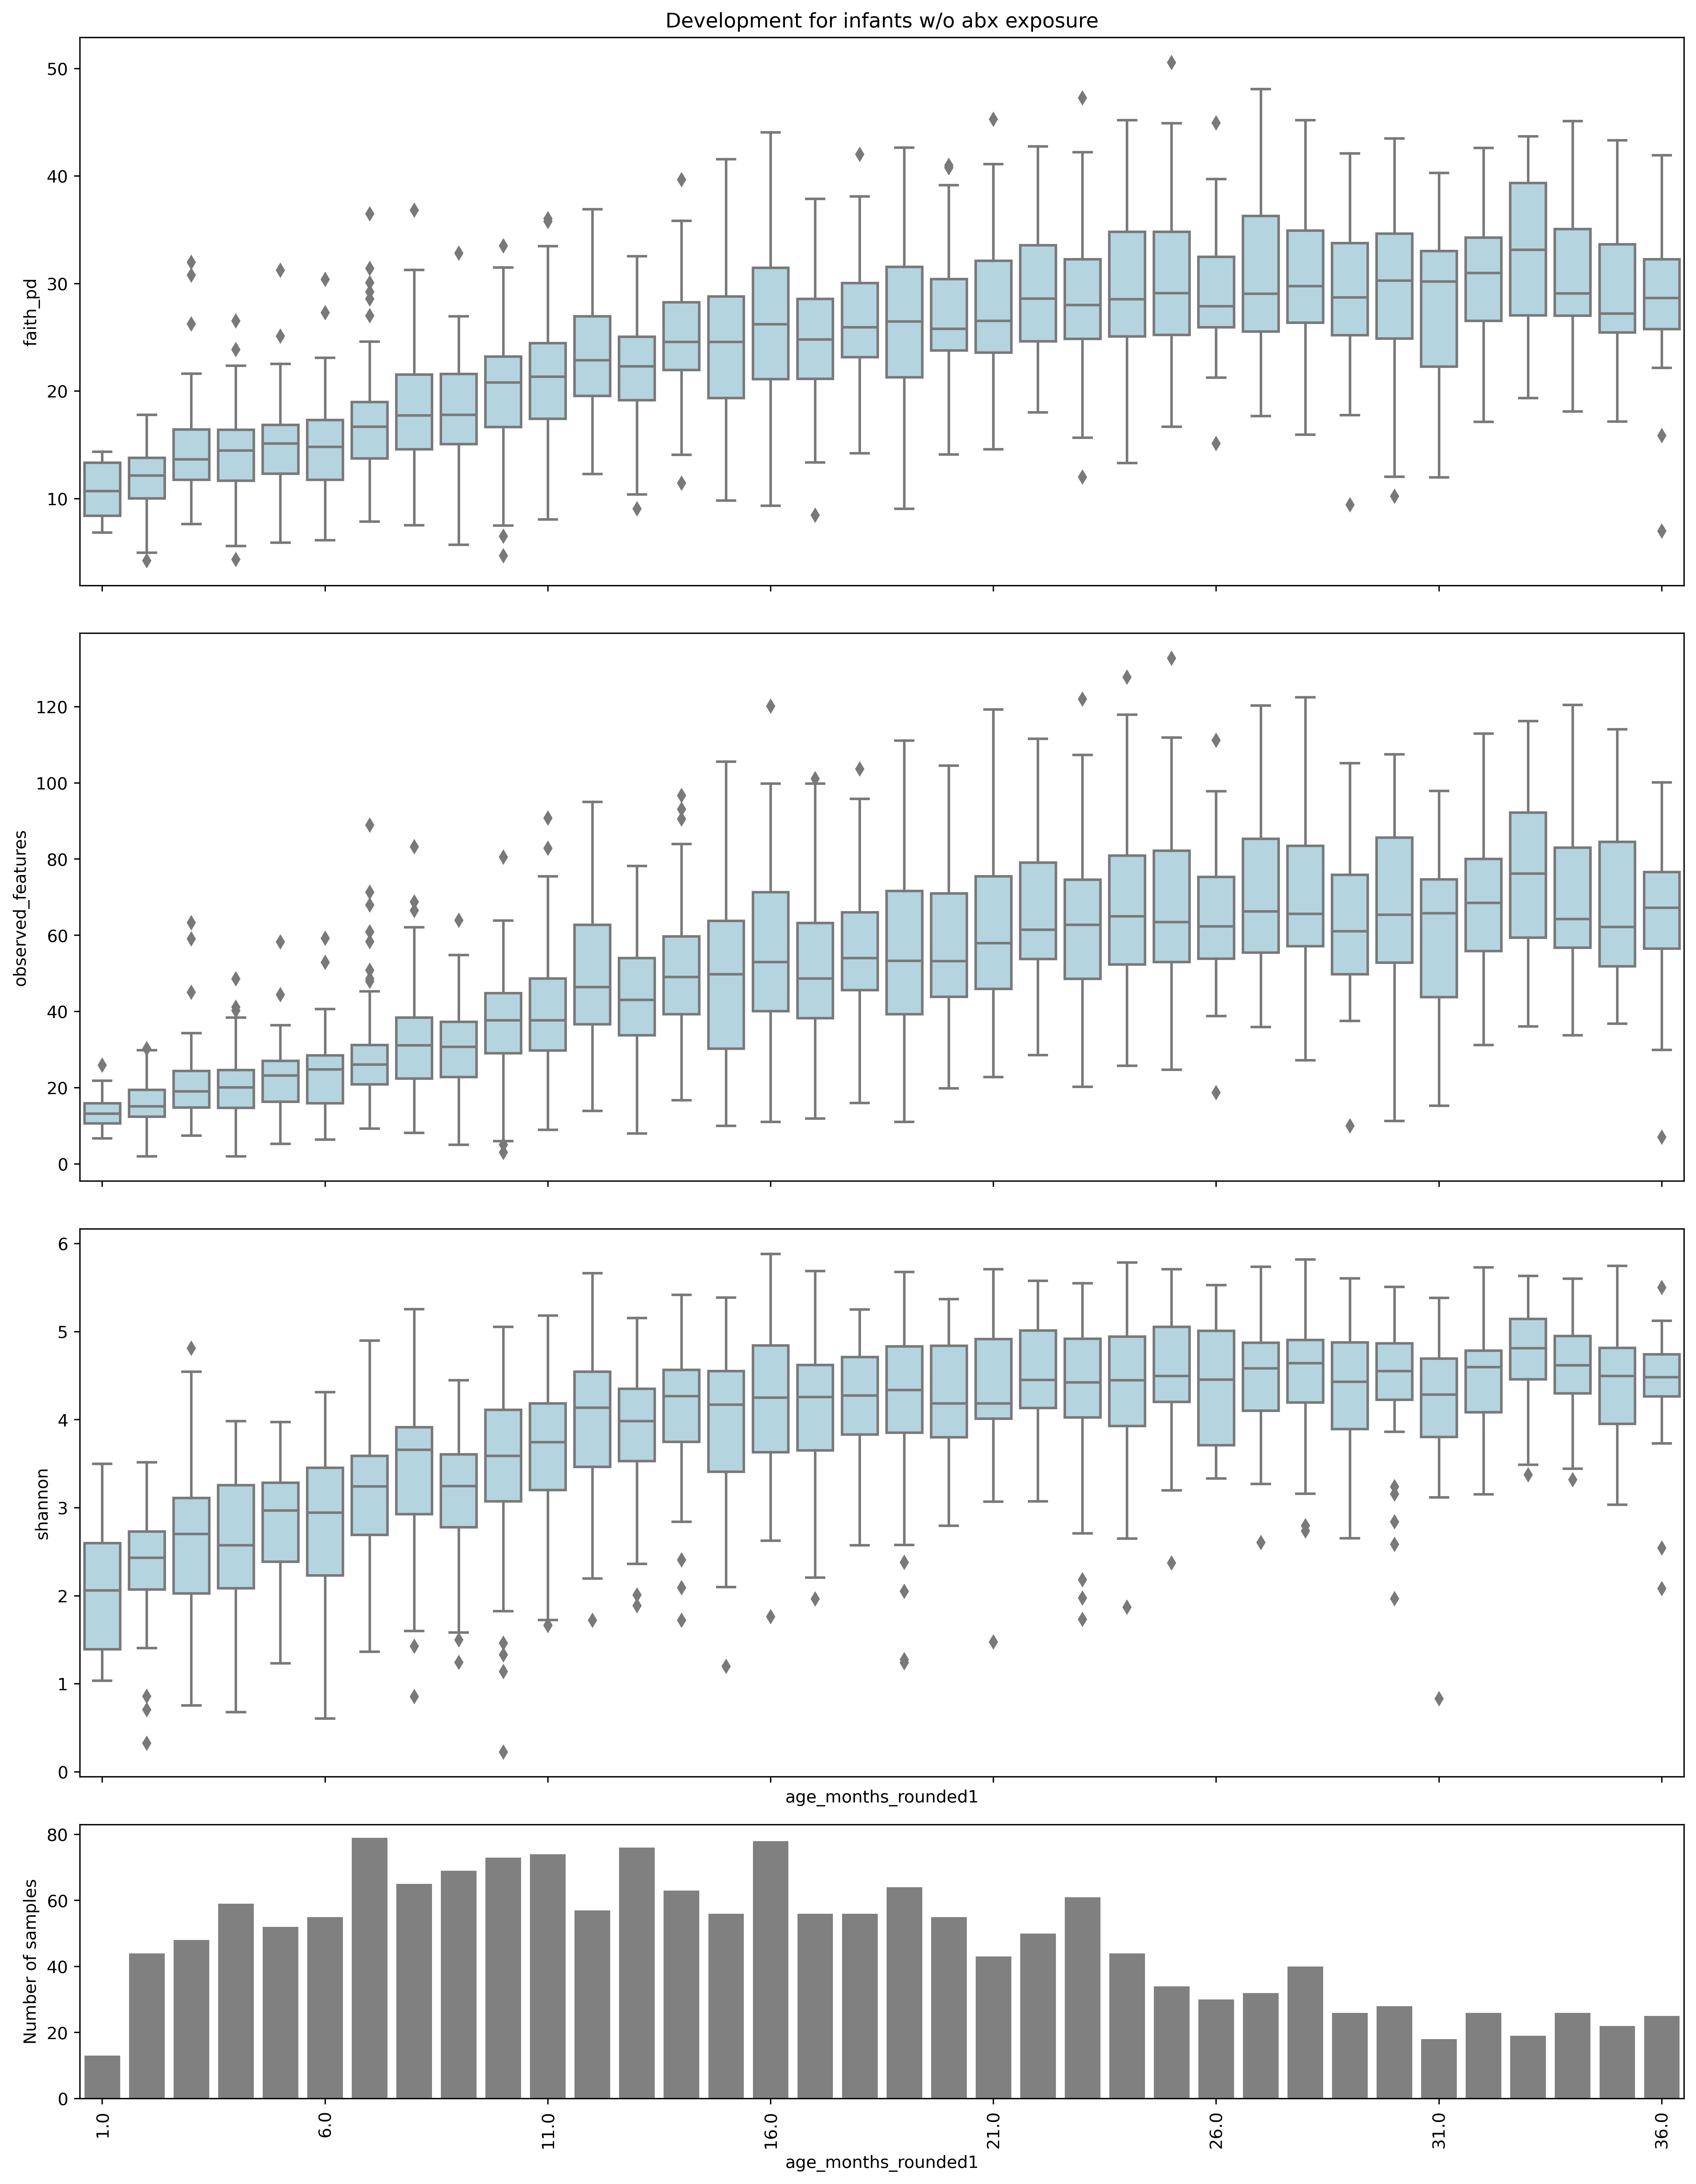

In [6]:
x_axis = "age_months_rounded1"
boxplot_all_div_metrics_over_time(noabx, div_metrics, x_axis, path_to_output)

## Diversity in all noabx infants split by covariates

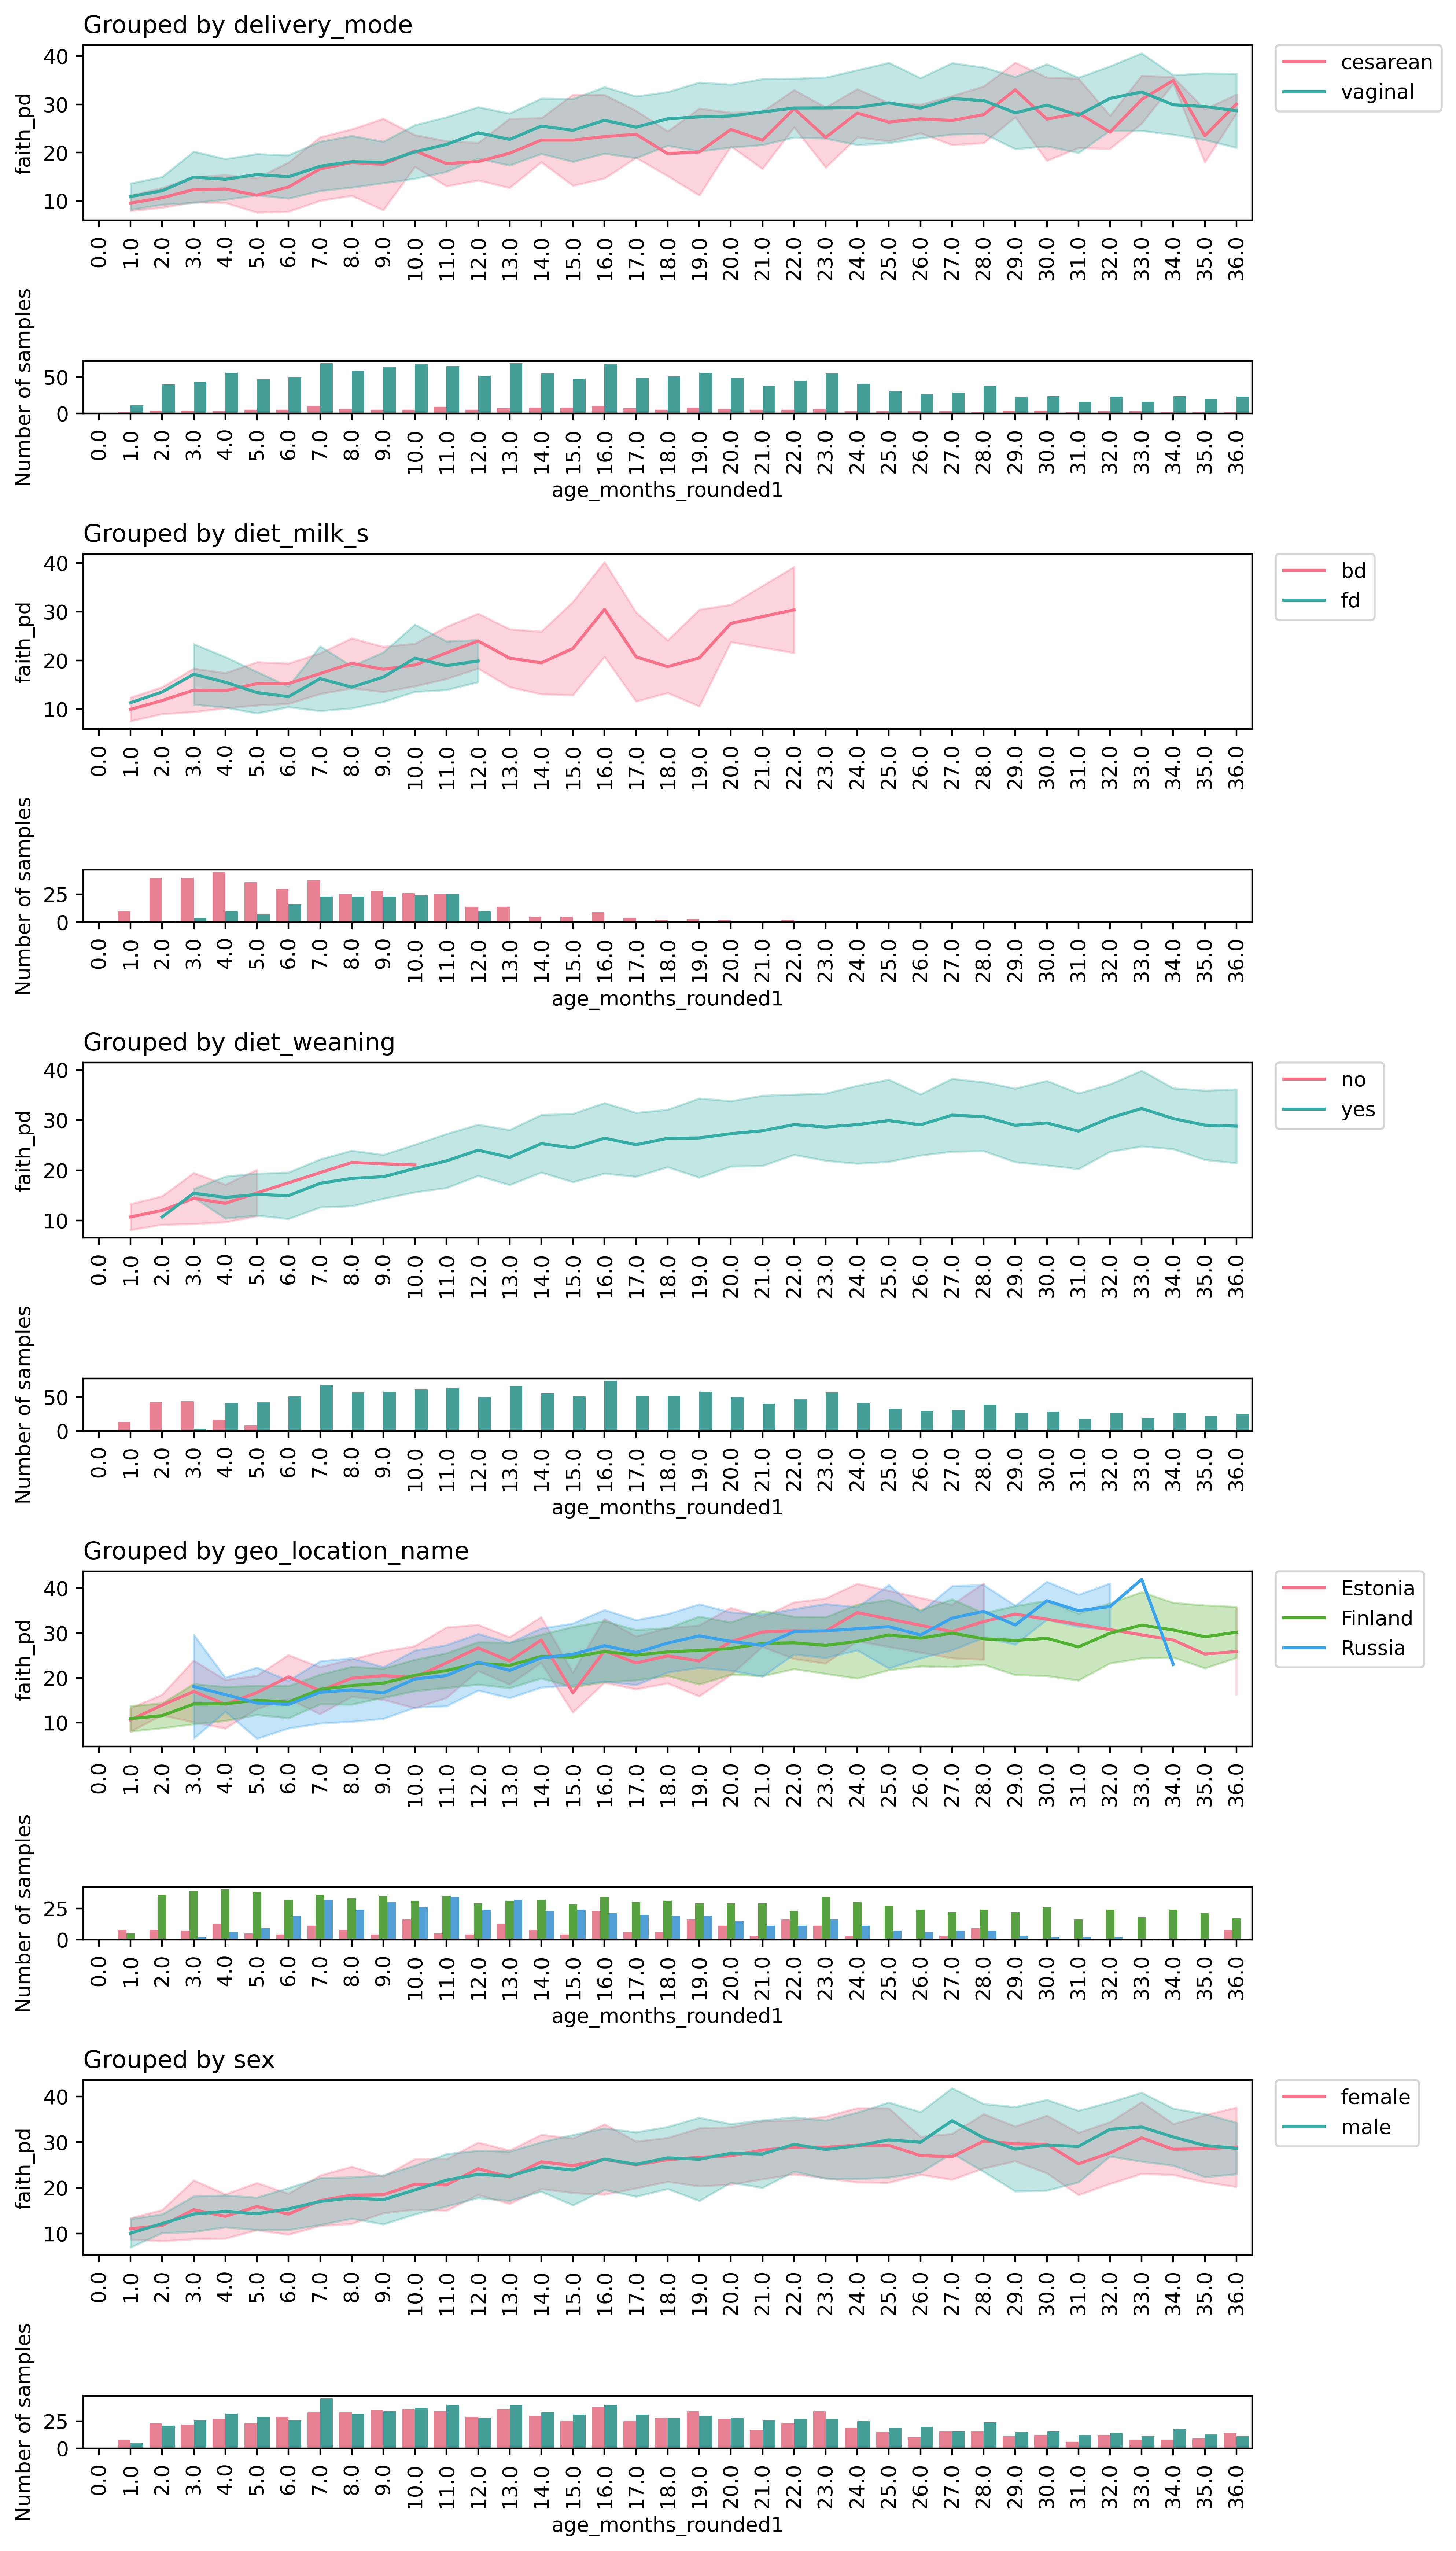

In [7]:
metric = "div_alpha_faith_pd"
group_by_values = [
    "delivery_mode",
    "diet_milk_s",
    "diet_weaning",
    "geo_location_name",
    "sex",
]
lineplot_all_div_metrics_over_time(
    noabx, metric, x_axis, group_by_values, path_to_output
)

## Abx/ no abx effect on alpha diversity over time

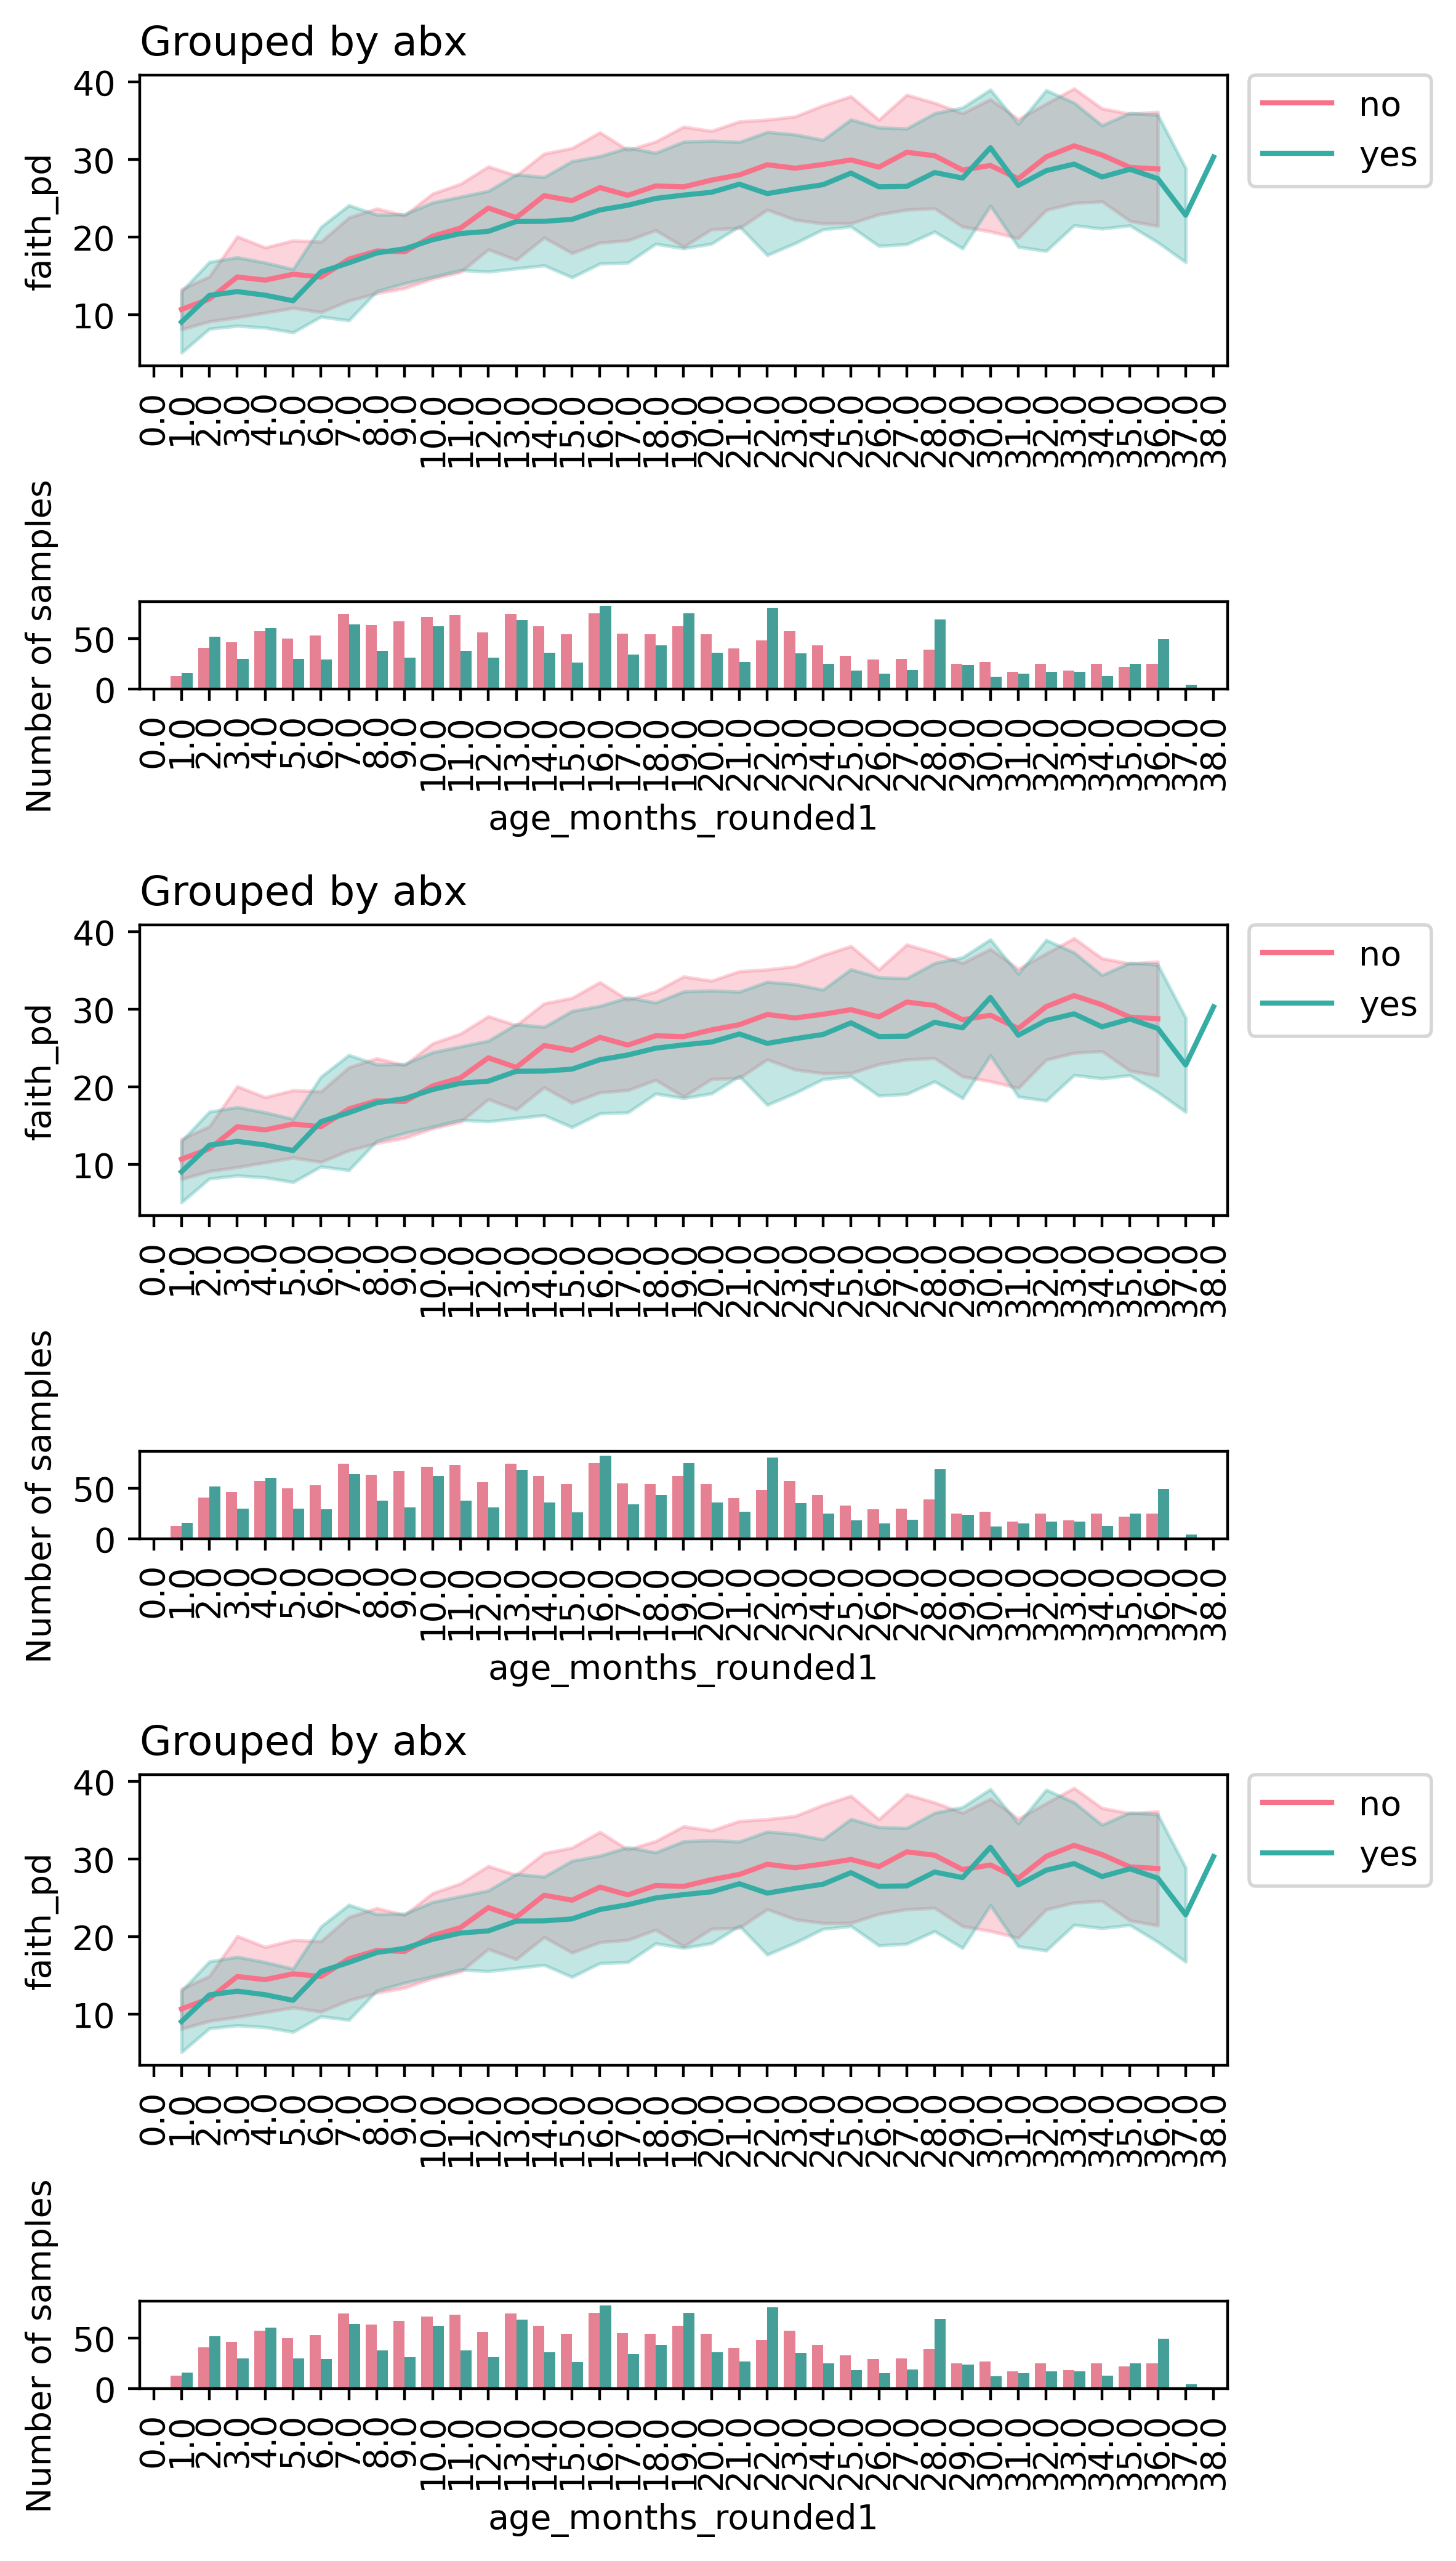

In [8]:
# add simple abx no and yes feature
md_df["abx"] = "no"
md_df.loc[md_df["abx_max_count_ever"] > 0.0, "abx"] = "yes"

group_by_values = ["abx", "abx", "abx"]
lineplot_all_div_metrics_over_time(
    md_df, metric, x_axis, group_by_values, path_to_output
)

<Axes: >

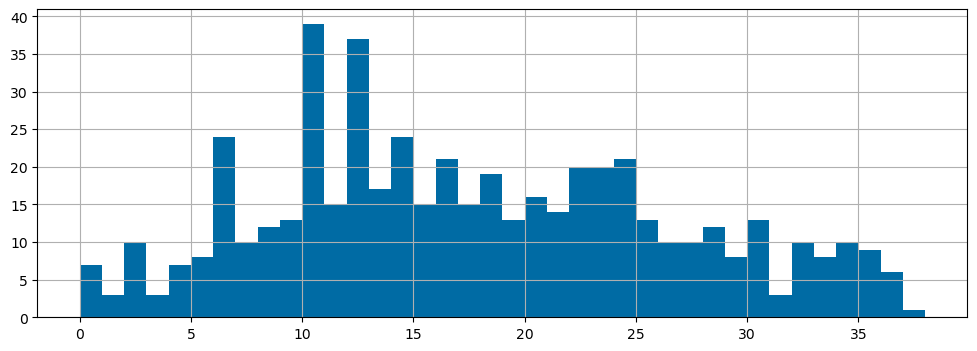

In [9]:
# get density of abx events over time
abx_df["abx_start_age_months_rounded1"] = abx_df["abx_start_age_months"].round()
abx_df["abx_start_age_months_rounded1"].hist(bins=range(0, 39), figsize=(12, 4))

In [11]:
# for i in [3, 6, 12, 15]:
#     print(i)
#     noabx.loc[noabx["age_months_rounded1"]==i, "div_alpha_faith_pd"].plot(kind="hist", bins=40)
#     plt.show()

# Number of abx courses per host

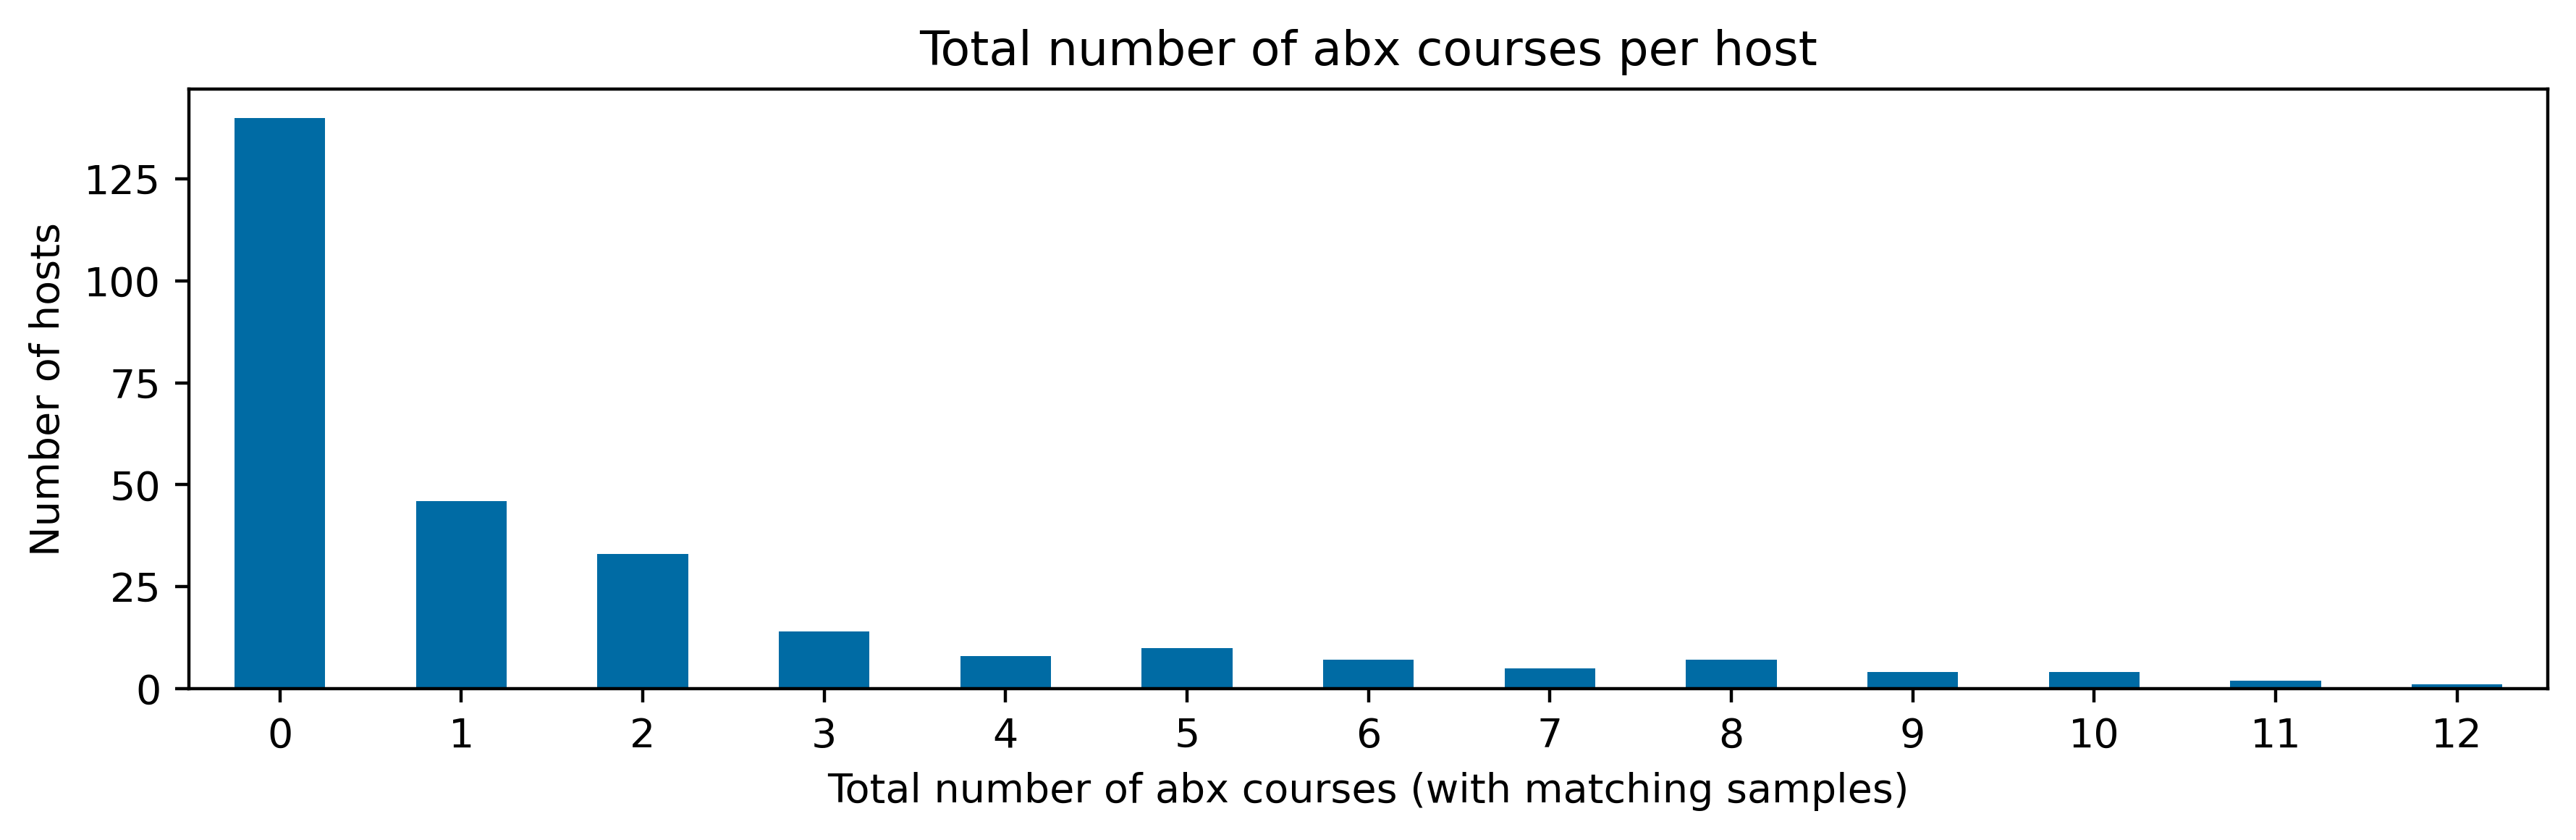

In [12]:
# select only unique samples with host_id and "abx_max_count_ever"
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=400)

md_df_unique = md_df.drop_duplicates(["host_id", "max_abx_w_microbiome"]).copy()
md_df_unique.groupby("max_abx_w_microbiome")["host_id"].count().plot(kind="bar", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_ylabel("Number of hosts")
ax.set_xlabel("Total number of abx courses (with matching samples)")
ax.set_title("Total number of abx courses per host")
plt.tight_layout()
filename = os.path.join(path_to_output, "nb_abx_courses_per_host.png")
plt.savefig(filename, dpi=400, bbox_inches="tight")
plt.show()

## Number of abx courses per sample

In [13]:
print(md_df.shape)
md_df_s = md_df[md_df["abx_any_last_t_dmonths"] <= 1.0].copy()
print(md_df_s.shape)

cols_to_keep = ["host_id", "abx_any_cumcount"]
md_df_s = md_df_s[cols_to_keep].copy()
md_df_s.head()

(3003, 31)
(271, 31)


host_id  abx_any_cumcount
1794  E007980               1.0
1714  E008241               1.0
1647  E019187               1.0
1605  E022083               1.0
1091  E028794               1.0

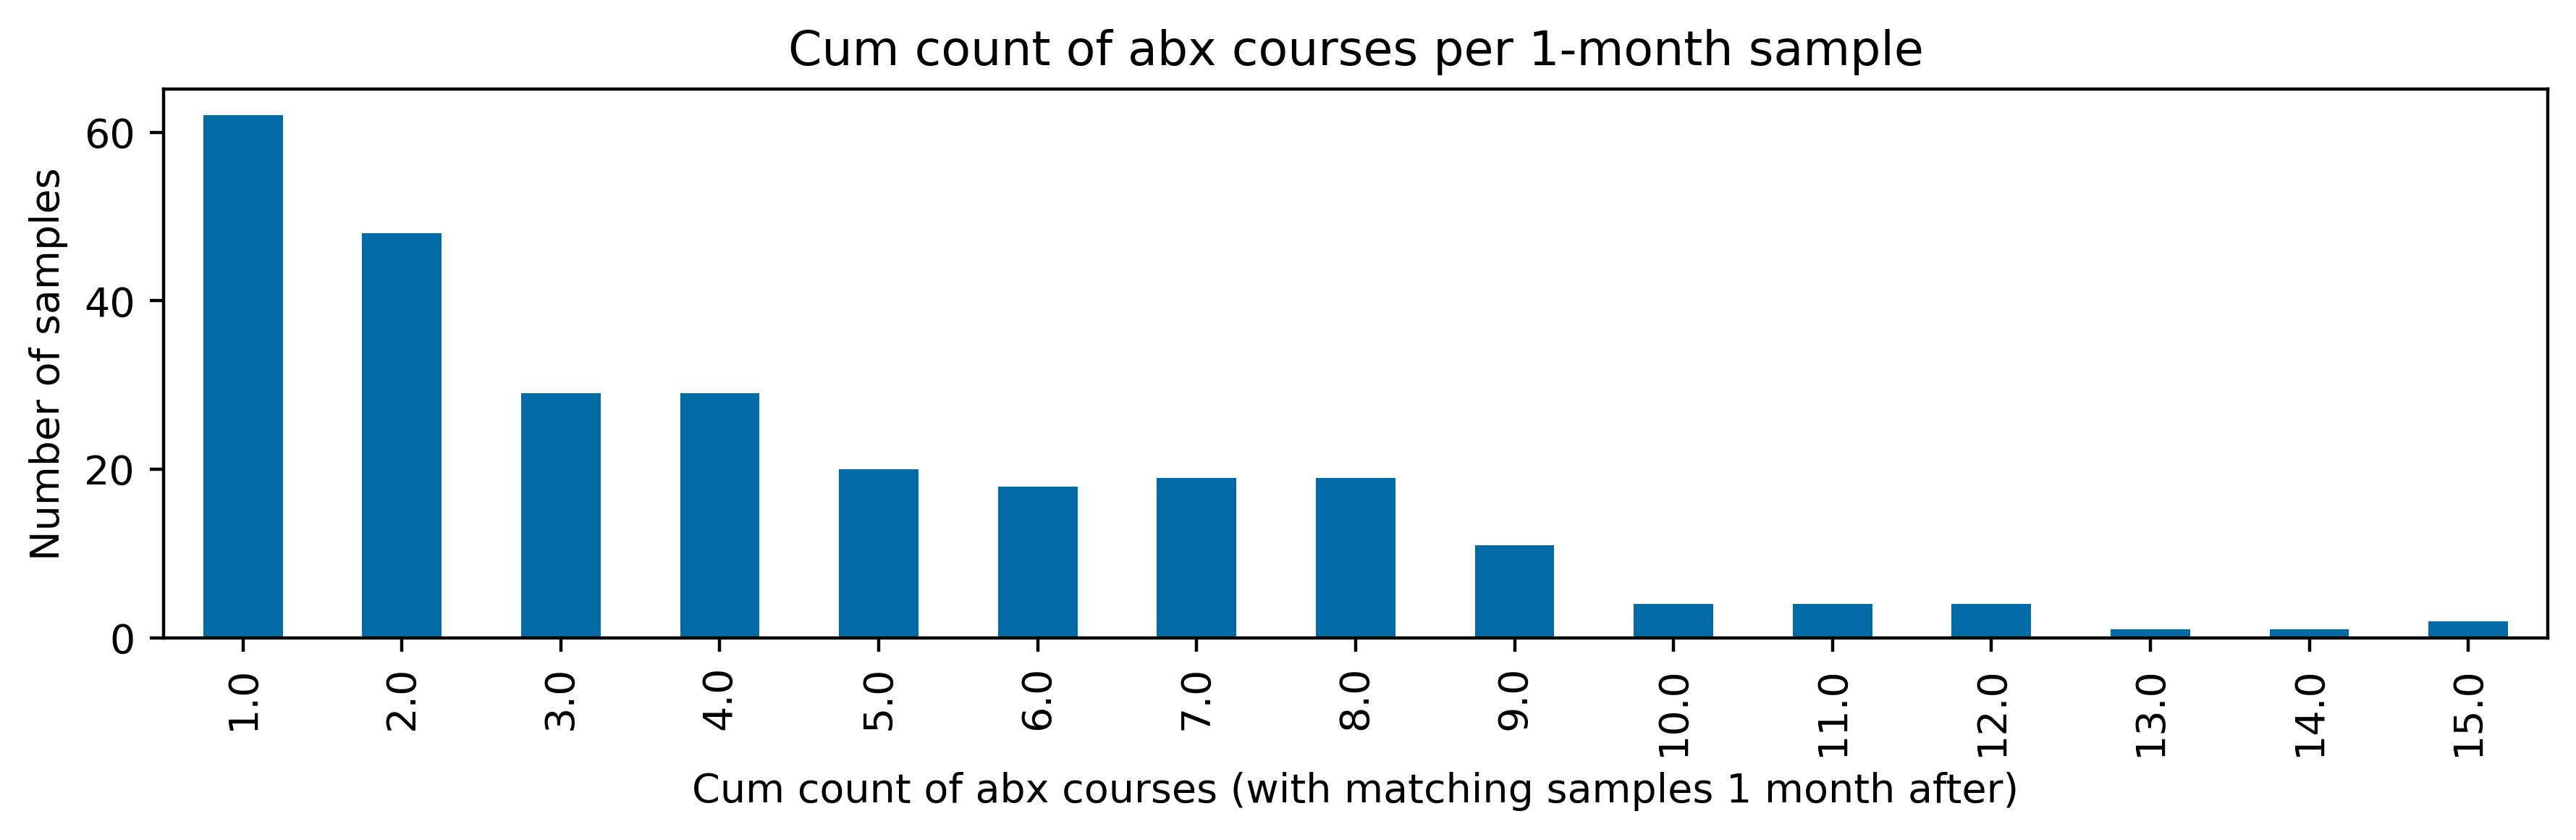

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=400)
md_df_sp = md_df_s.reset_index()
md_df_sp.groupby("abx_any_cumcount")["index"].count().plot(kind="bar", ax=ax)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_ylabel("Number of samples")
ax.set_xlabel("Cum count of abx courses (with matching samples 1 month after)")
ax.set_title("Cum count of abx courses per 1-month sample")
plt.tight_layout()
# filename = os.path.join(path_to_output, "nb_abx_courses_per_host.png")
# plt.savefig(filename, dpi=400, bbox_inches="tight")
plt.show()

## Effect of n-th abx exposure on alpha diversity

### Unmatched 1st abx - few immediate effect observable (confounded by many covariates)

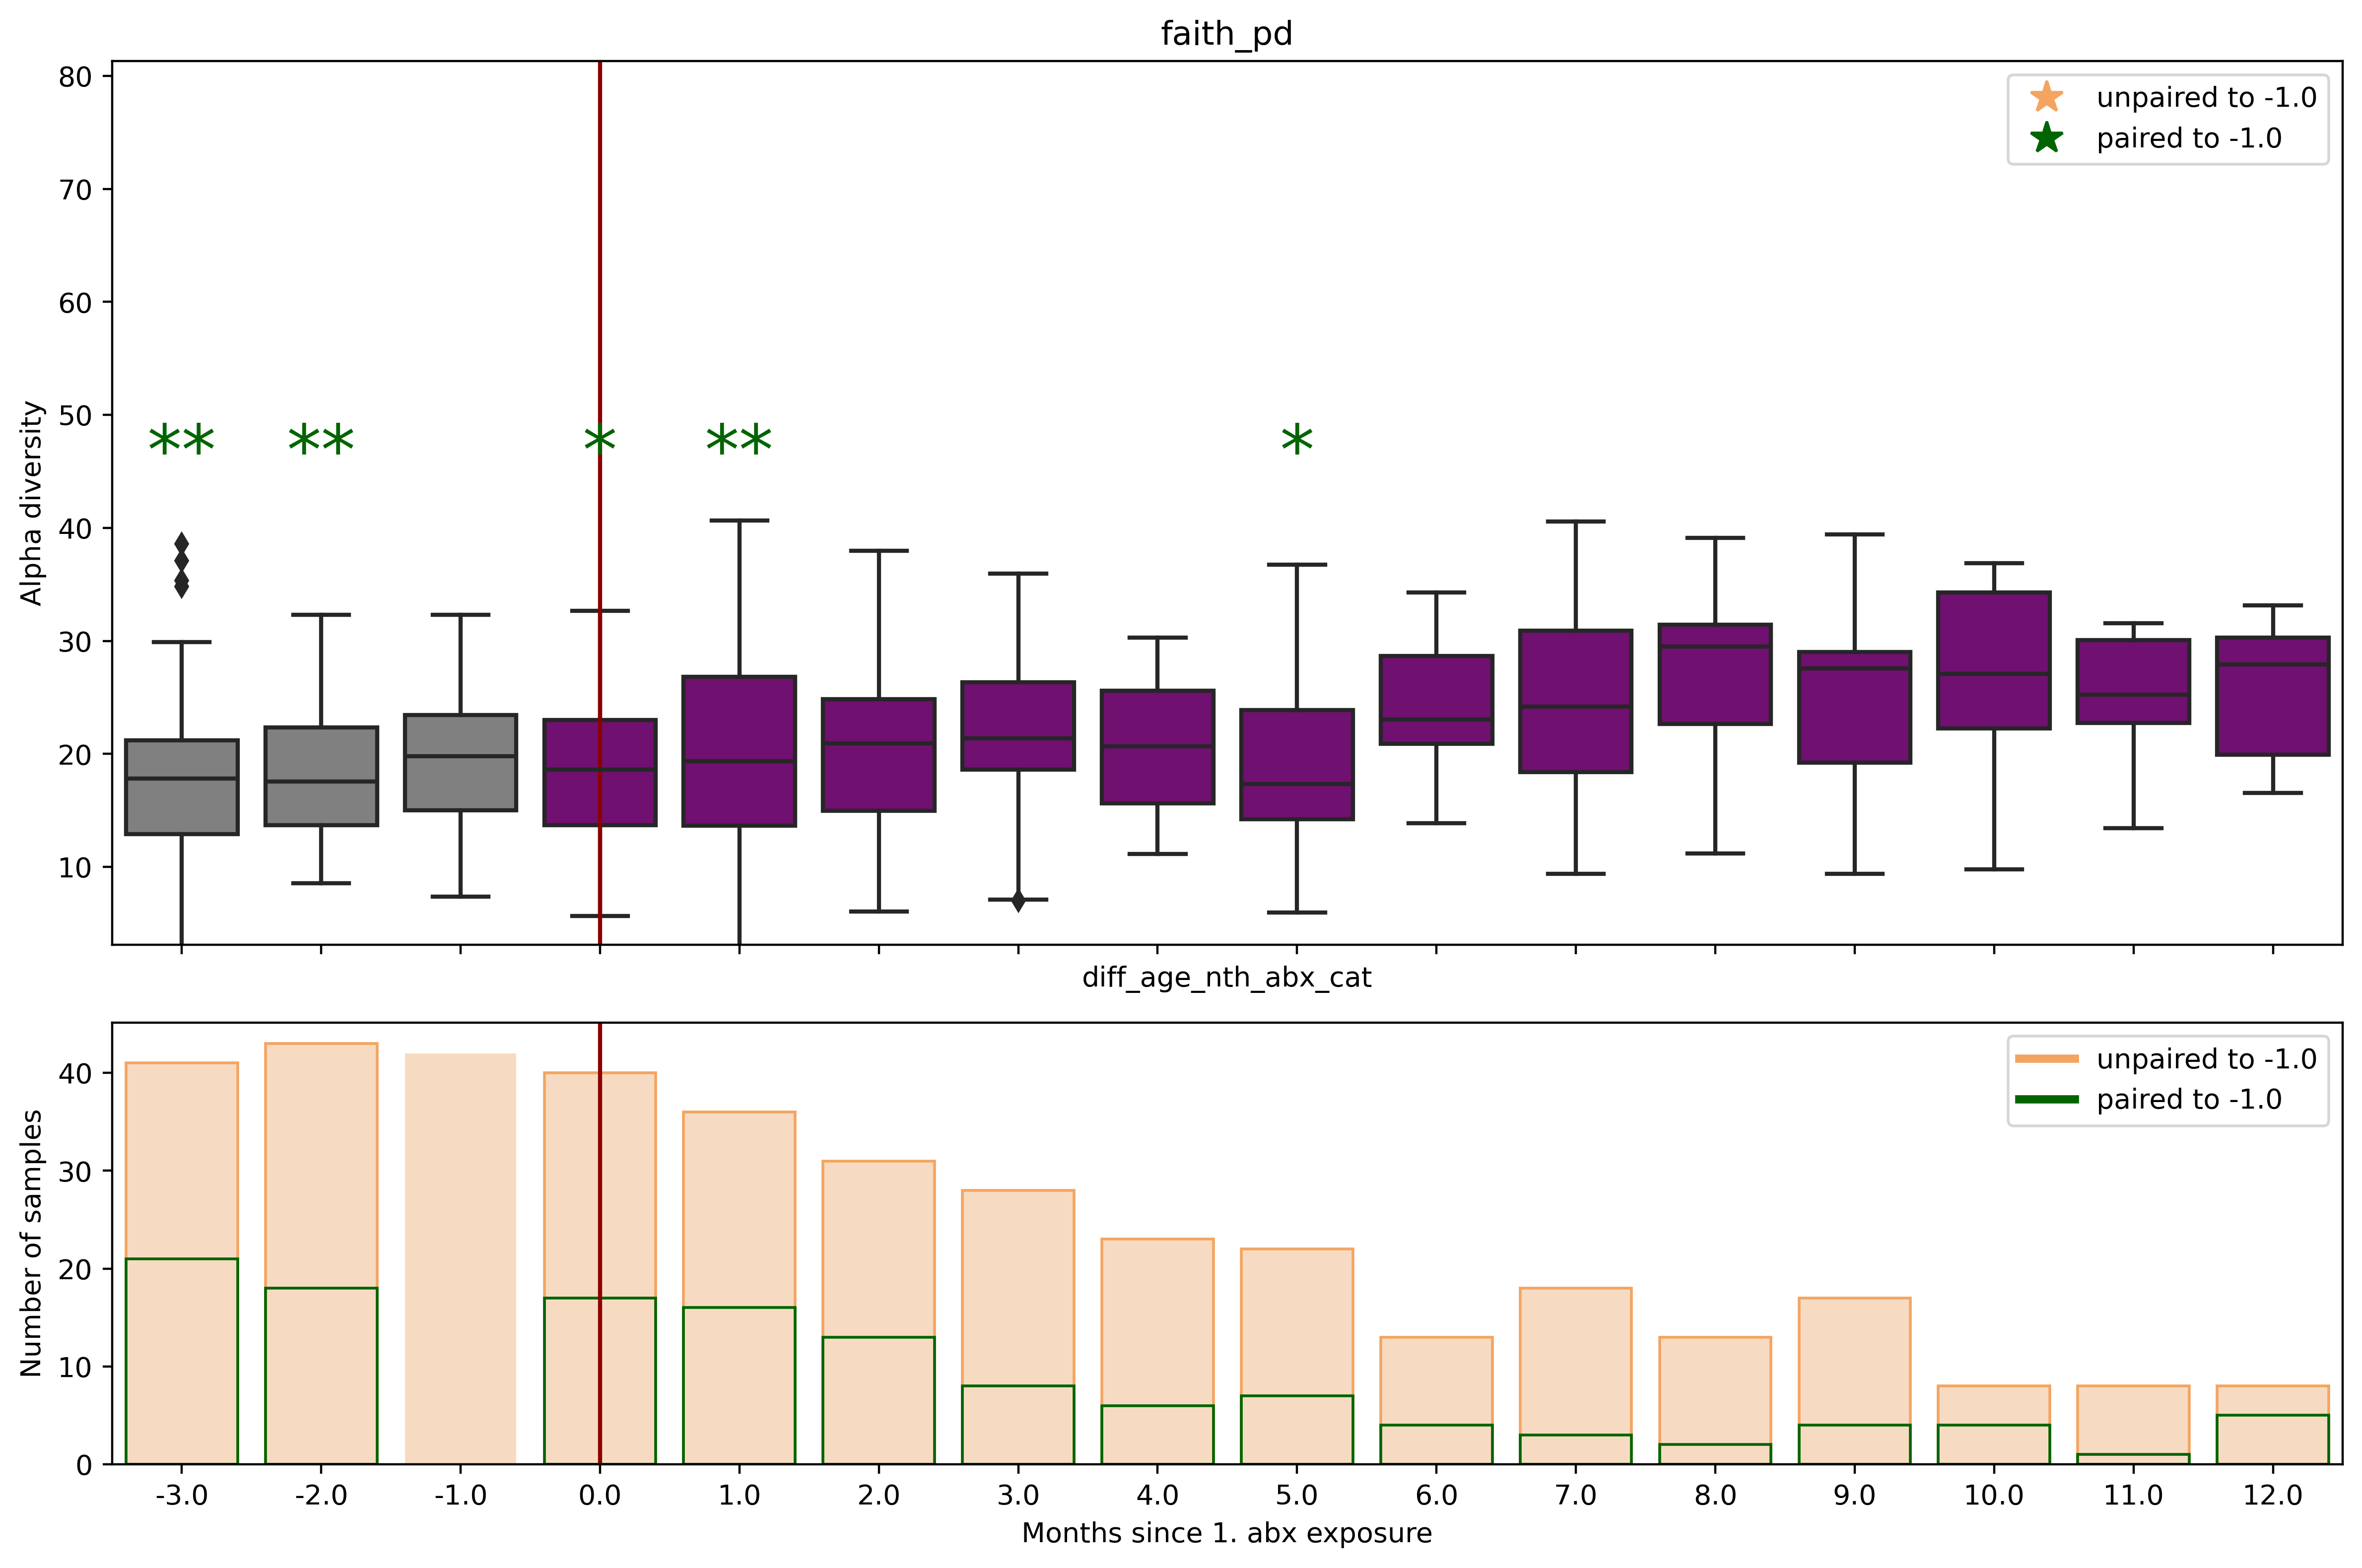

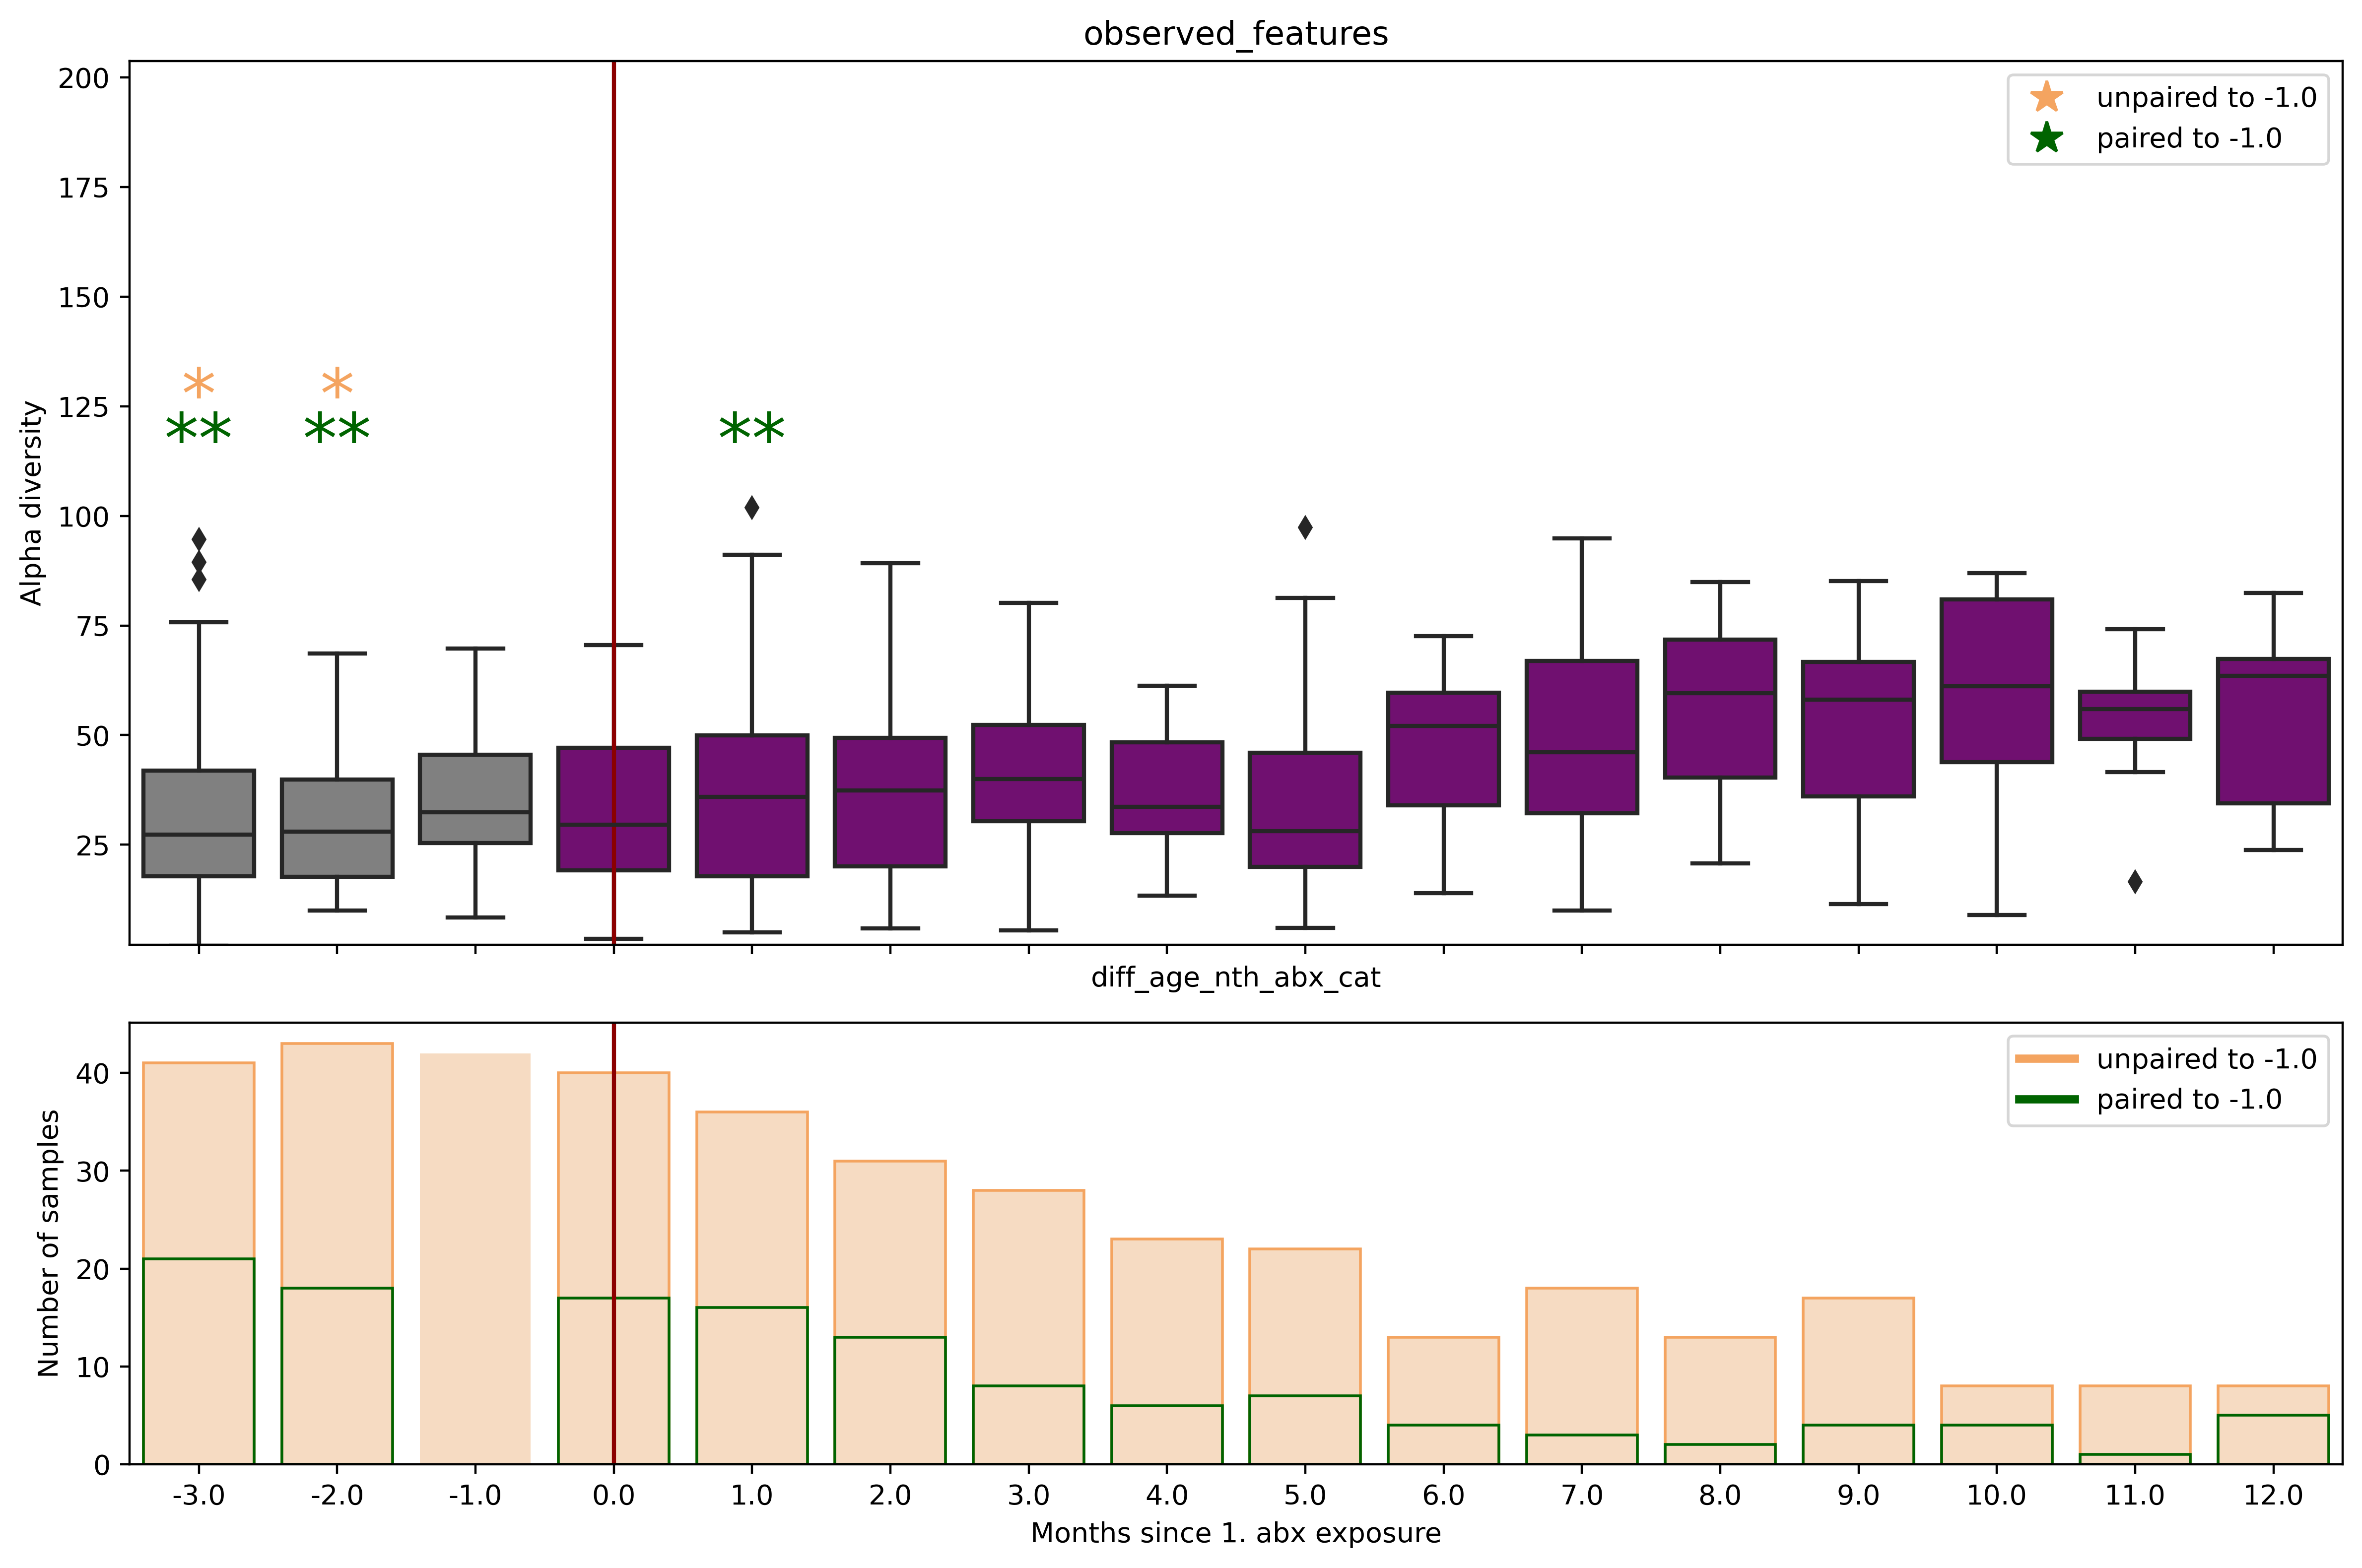

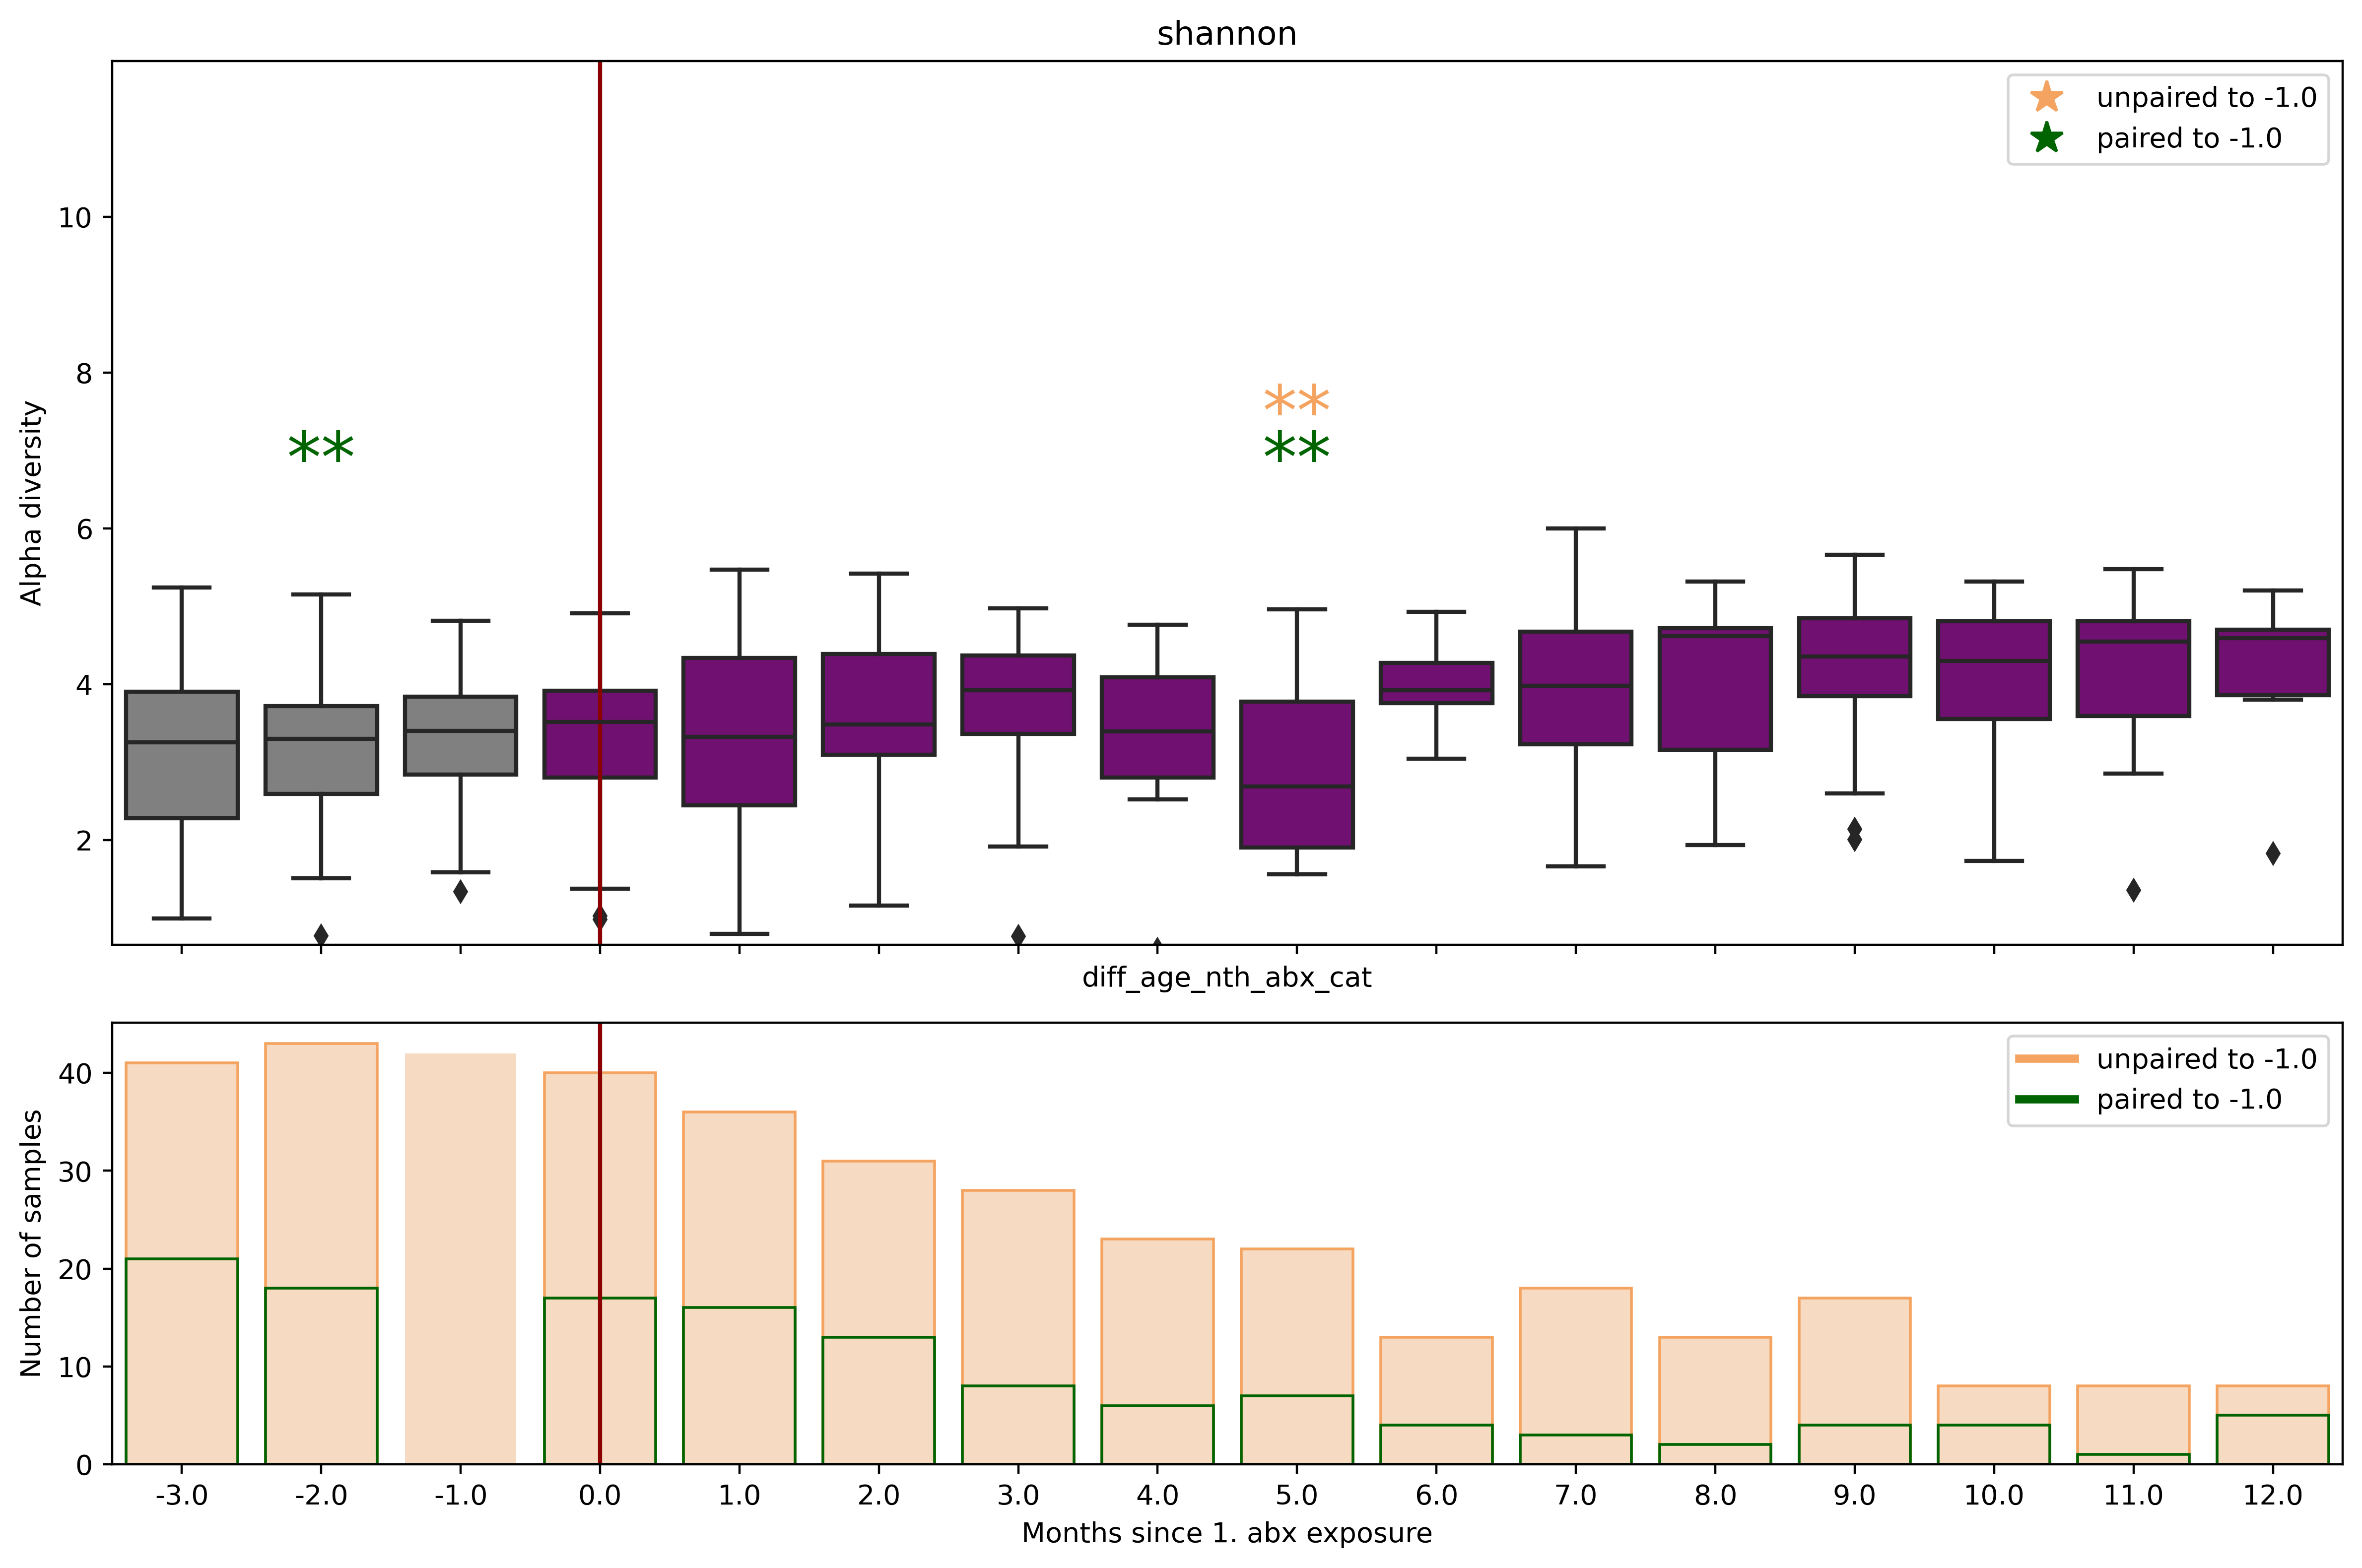

In [15]:
# without proper matching no effect from abx visible - probably confounded by age, diet, delivery mode
n = 1
# only select samples that are around n-th abx exposure
abx_nth_samples = select_samples_around_nth_abx_exposure(md_df, abx_df, n=n)

fig_unm, dic_kw_unm = plot_diversity_difference(
    abx_nth_samples, n, path_to_output, matched=False
)

### Matched: 1st to 3rd abx exposure effect on Faith PD 

(similar effects can be observed for different alpha div metrics: Faith PD and Observed Features most similar and Shannon slightly less pronounced )

In [16]:
matching_vars = [
    "age_months_rounded1",
    "delivery_mode",
    "diet_milk_s",
    # "geo_location_name",
]

Caption draft:

The upper plot shows the difference in alpha diversity between samples that received antibiotics and ones that did not matched by age, delivery mode and diet milk. The red vertical line depicts the timepoint when the 1st (or 2nd) abx exposure was received. The yellow and green stars display significant differences (* p < 0.1, ** p < 0.05) in comparing the distribution of the microbiome before antibiotic exposure (x-axis = -1.0) to after (yellow is a Mann-Whitney U-test, green a Wilcoxon test). The lower plot displays the number of samples available for each time bin.

Number of samples disregarded because of lacking reference in noabx: 1


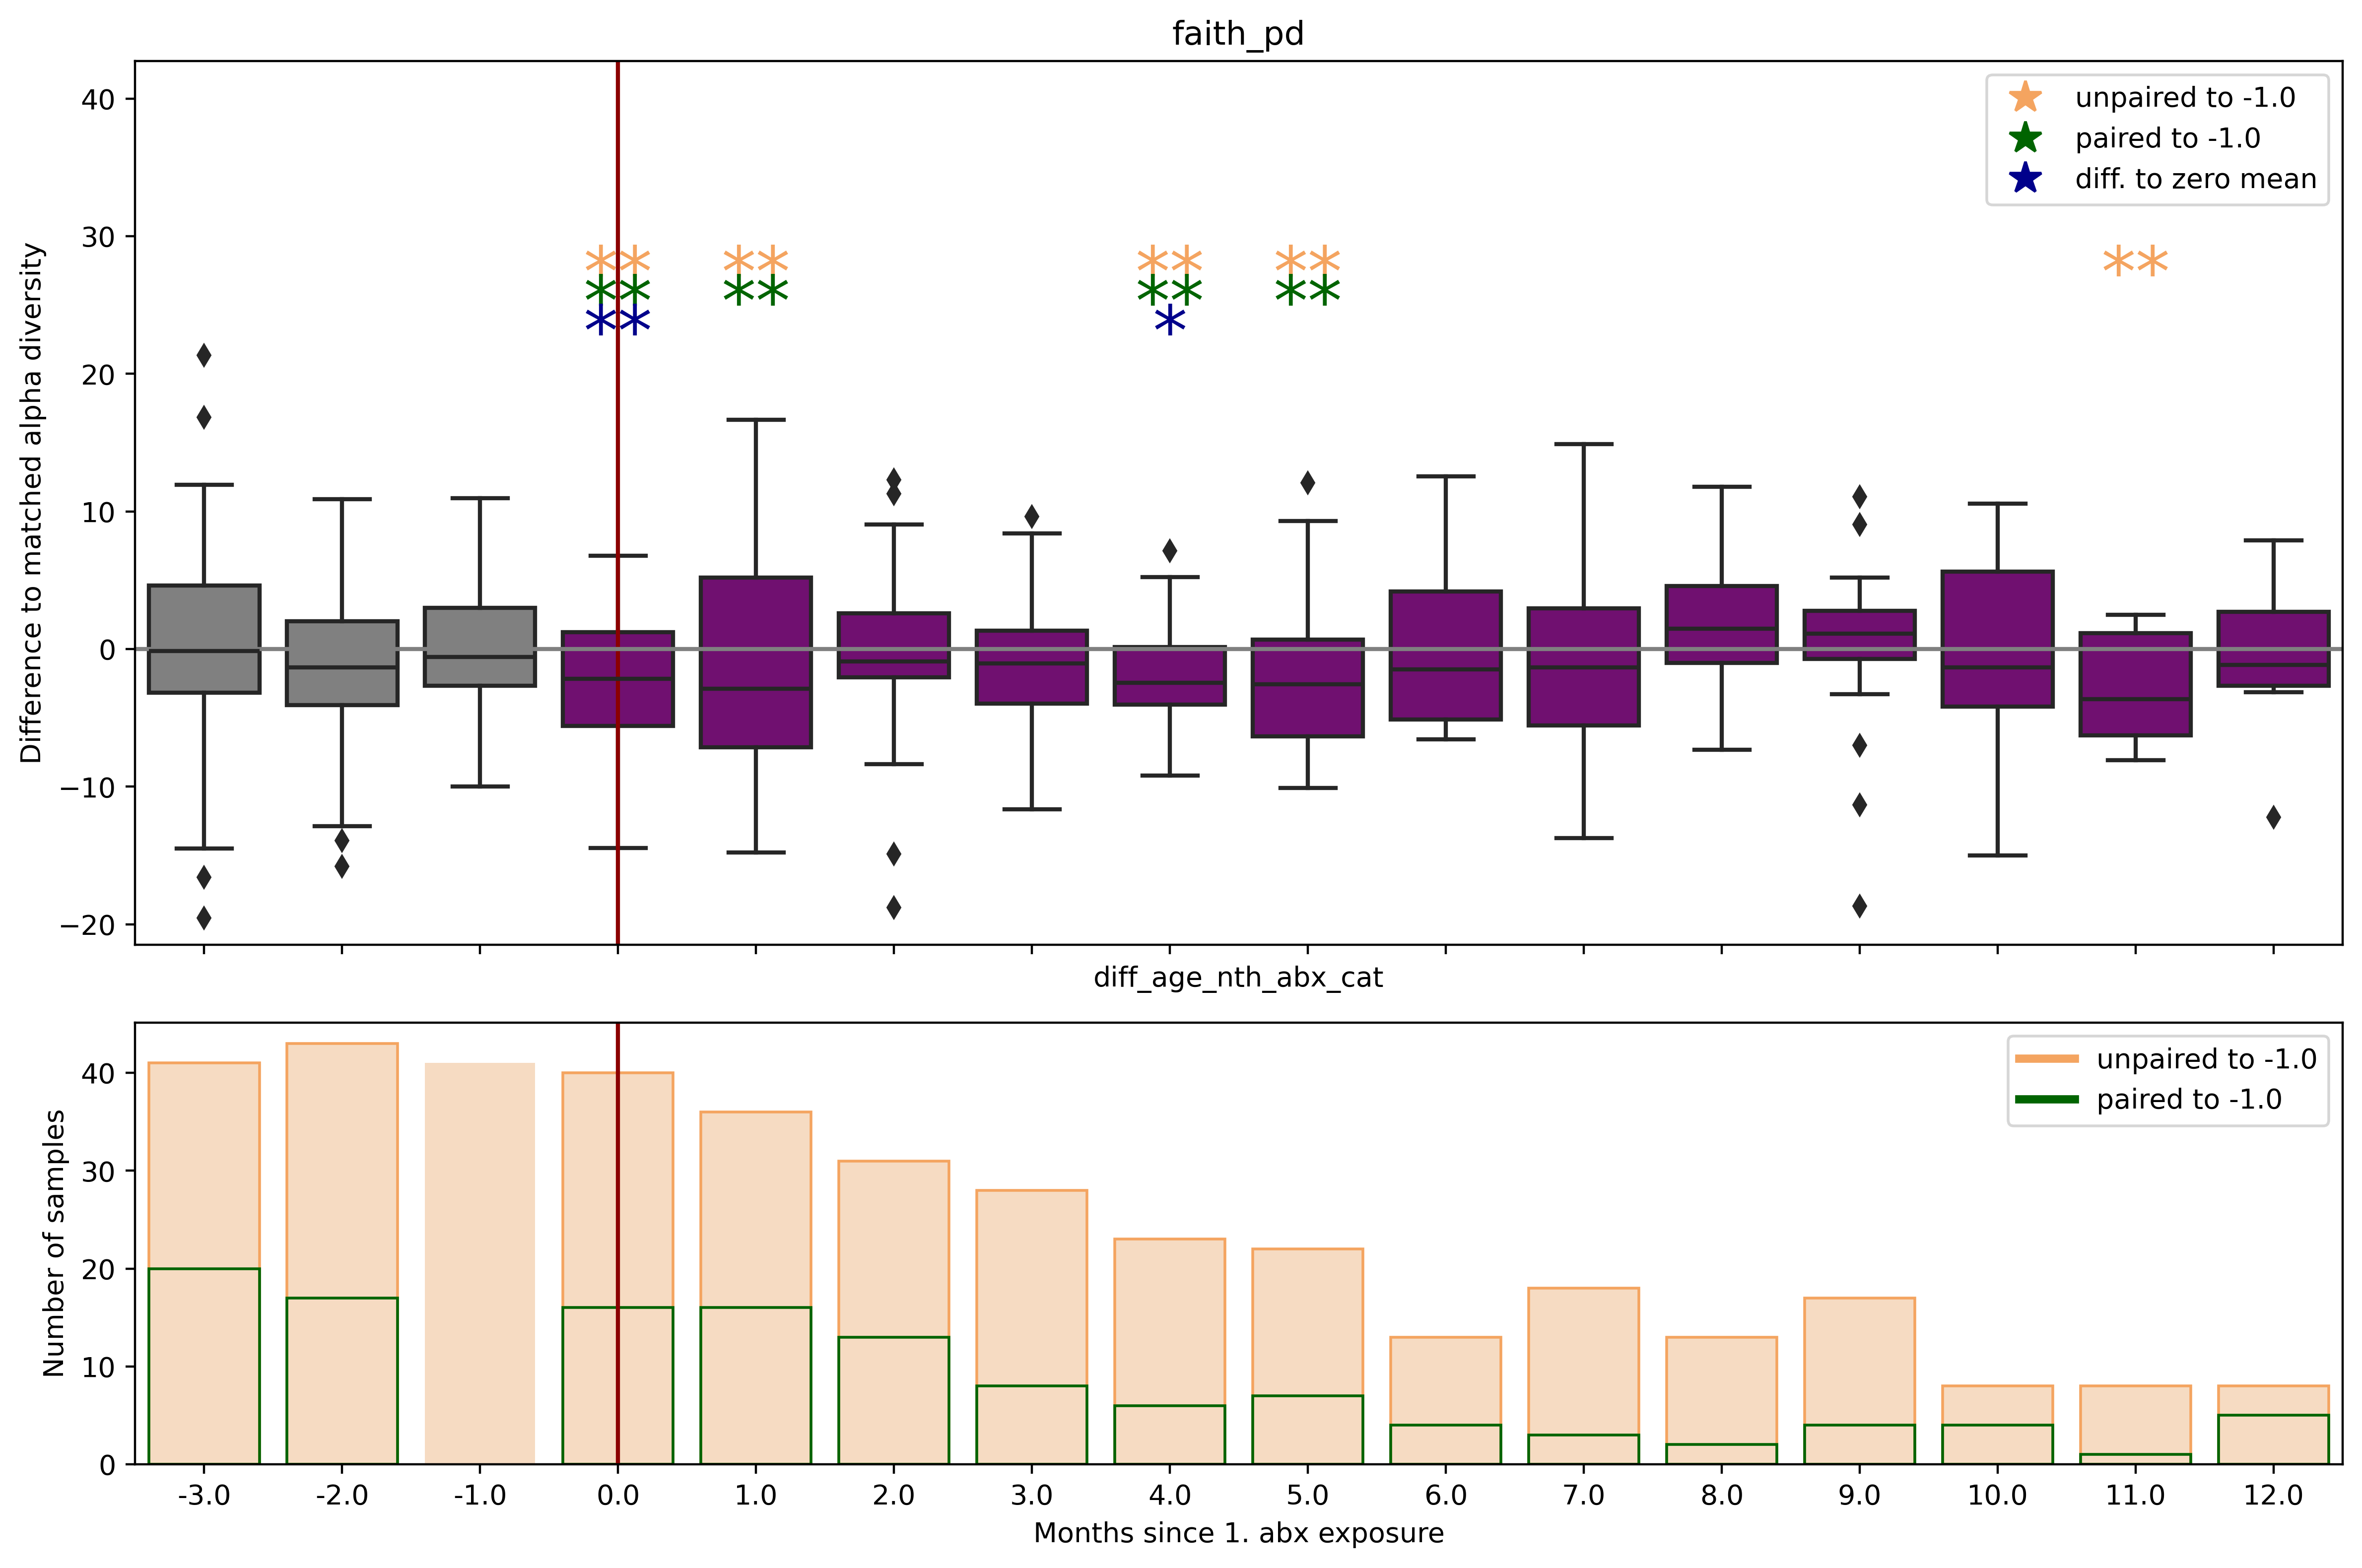

Number of samples disregarded because of lacking reference in noabx: 2


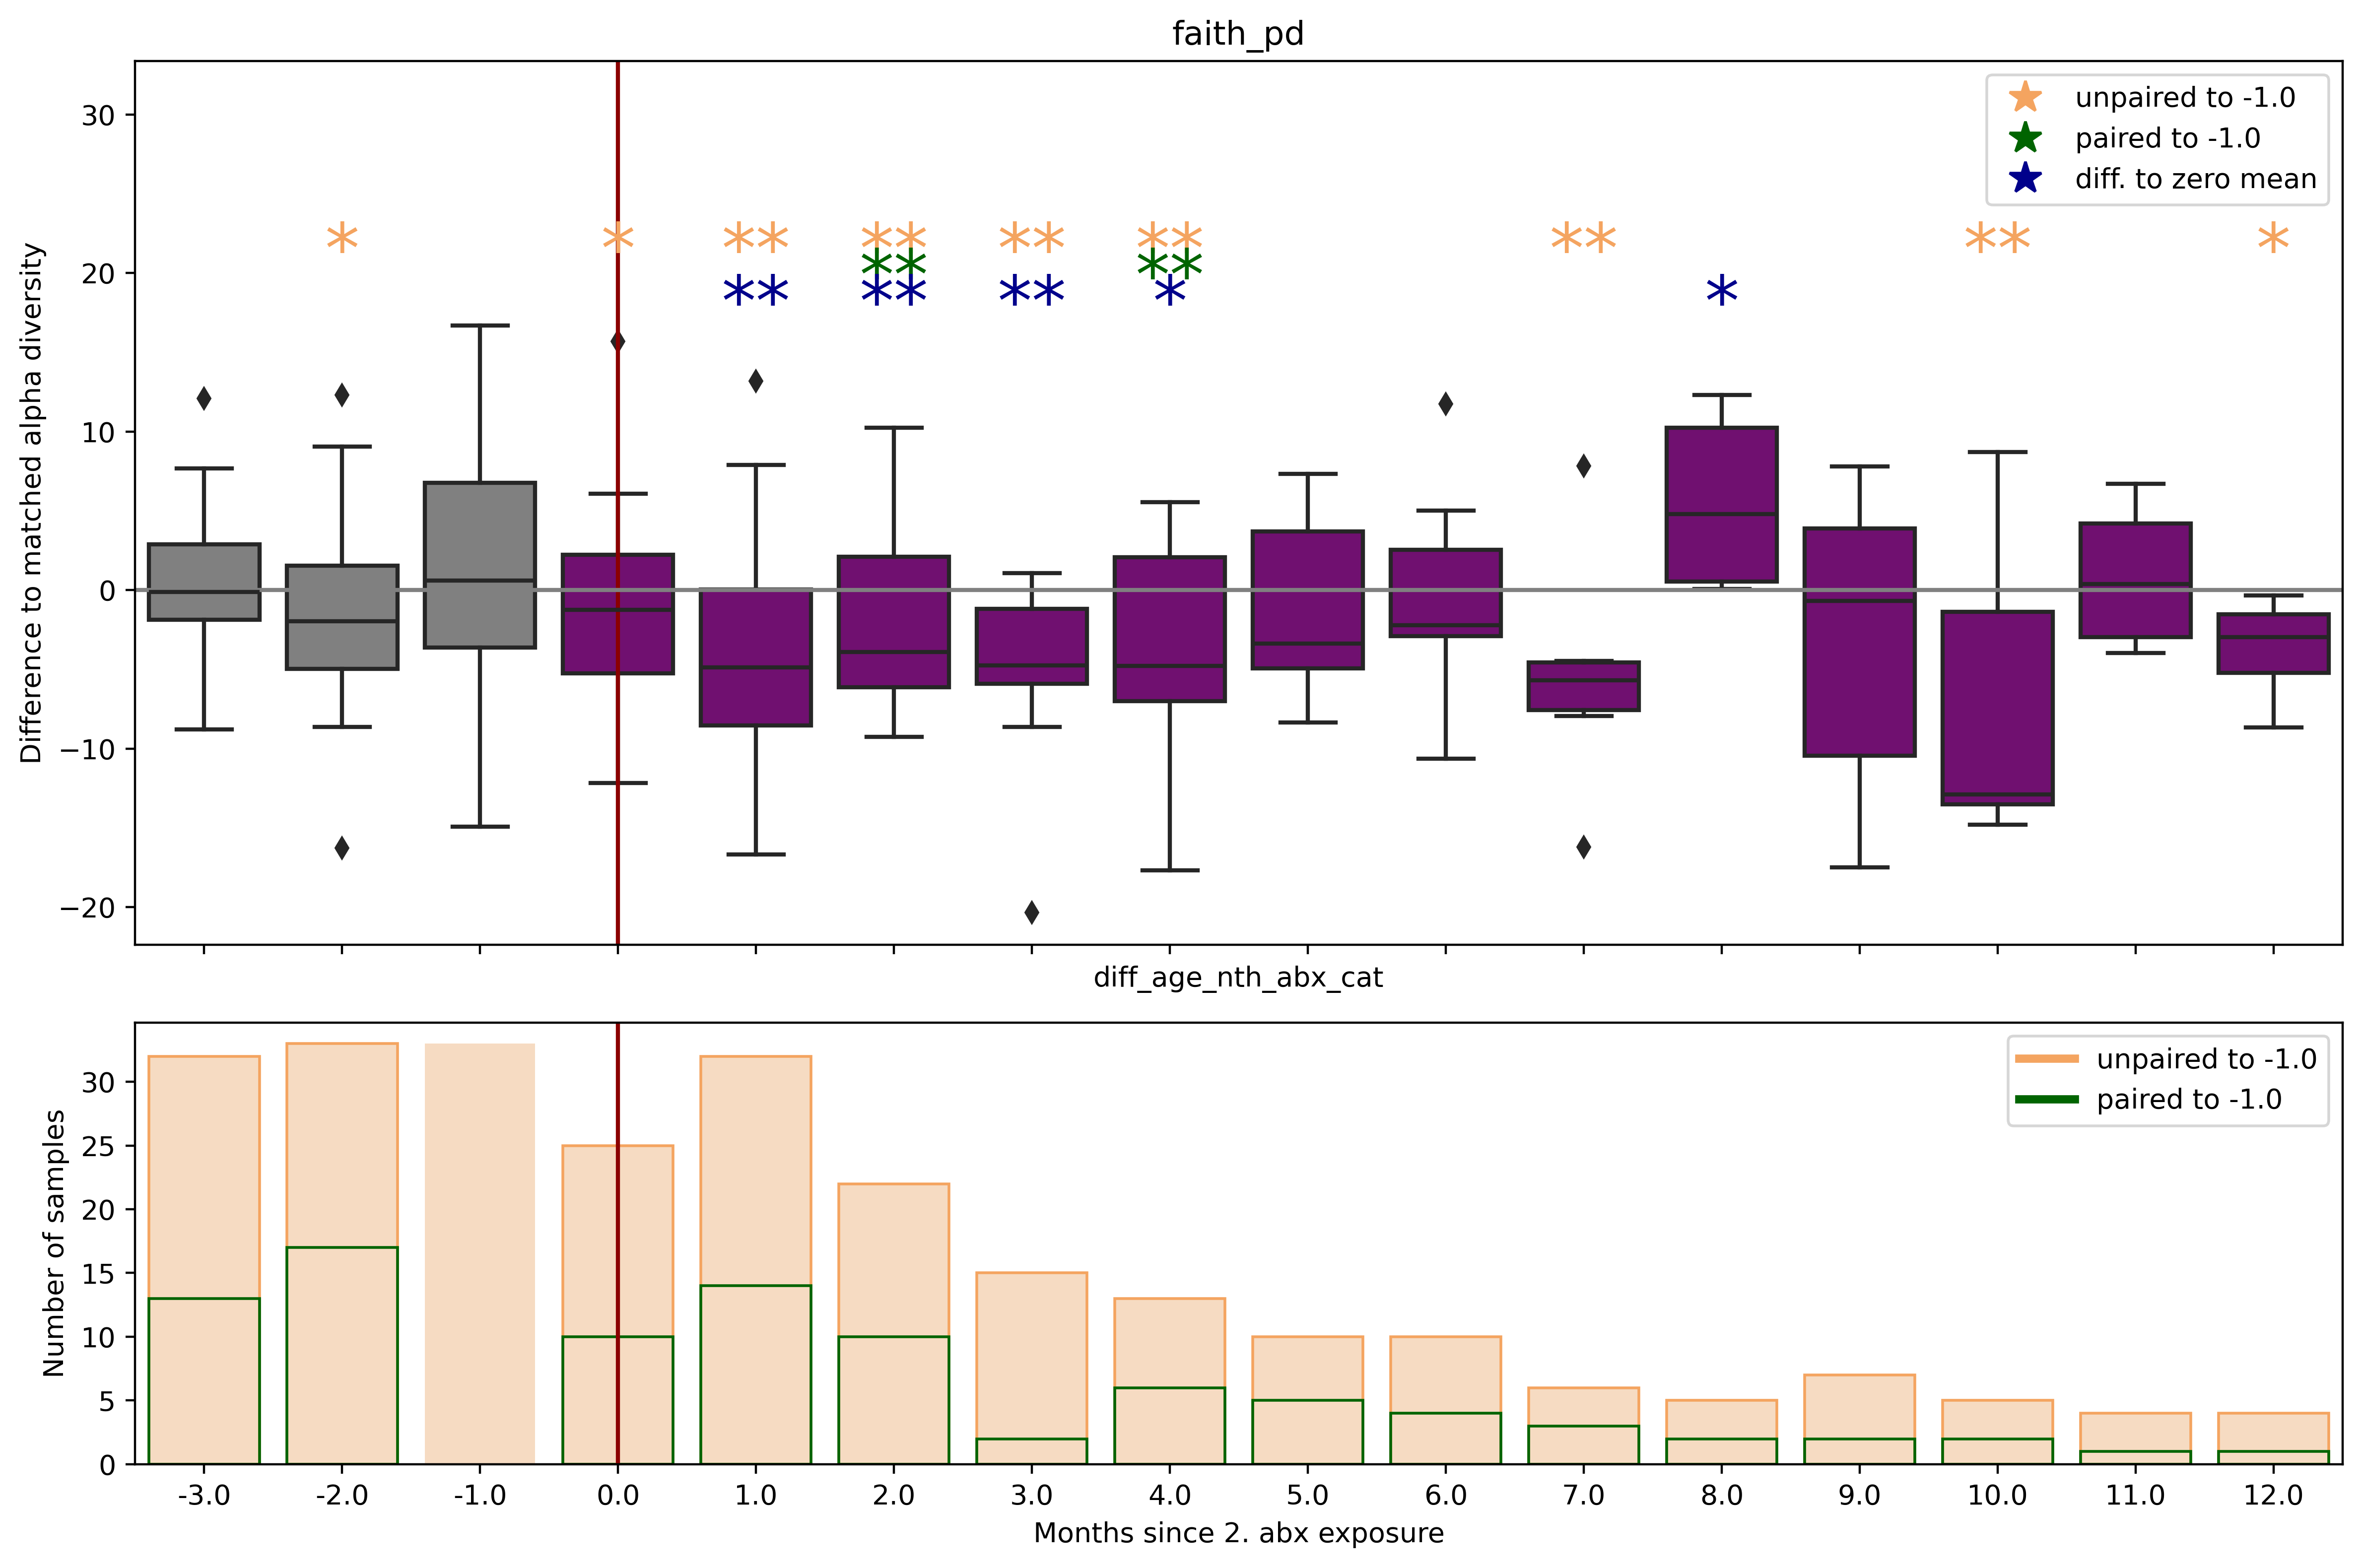

Number of samples disregarded because of lacking reference in noabx: 0


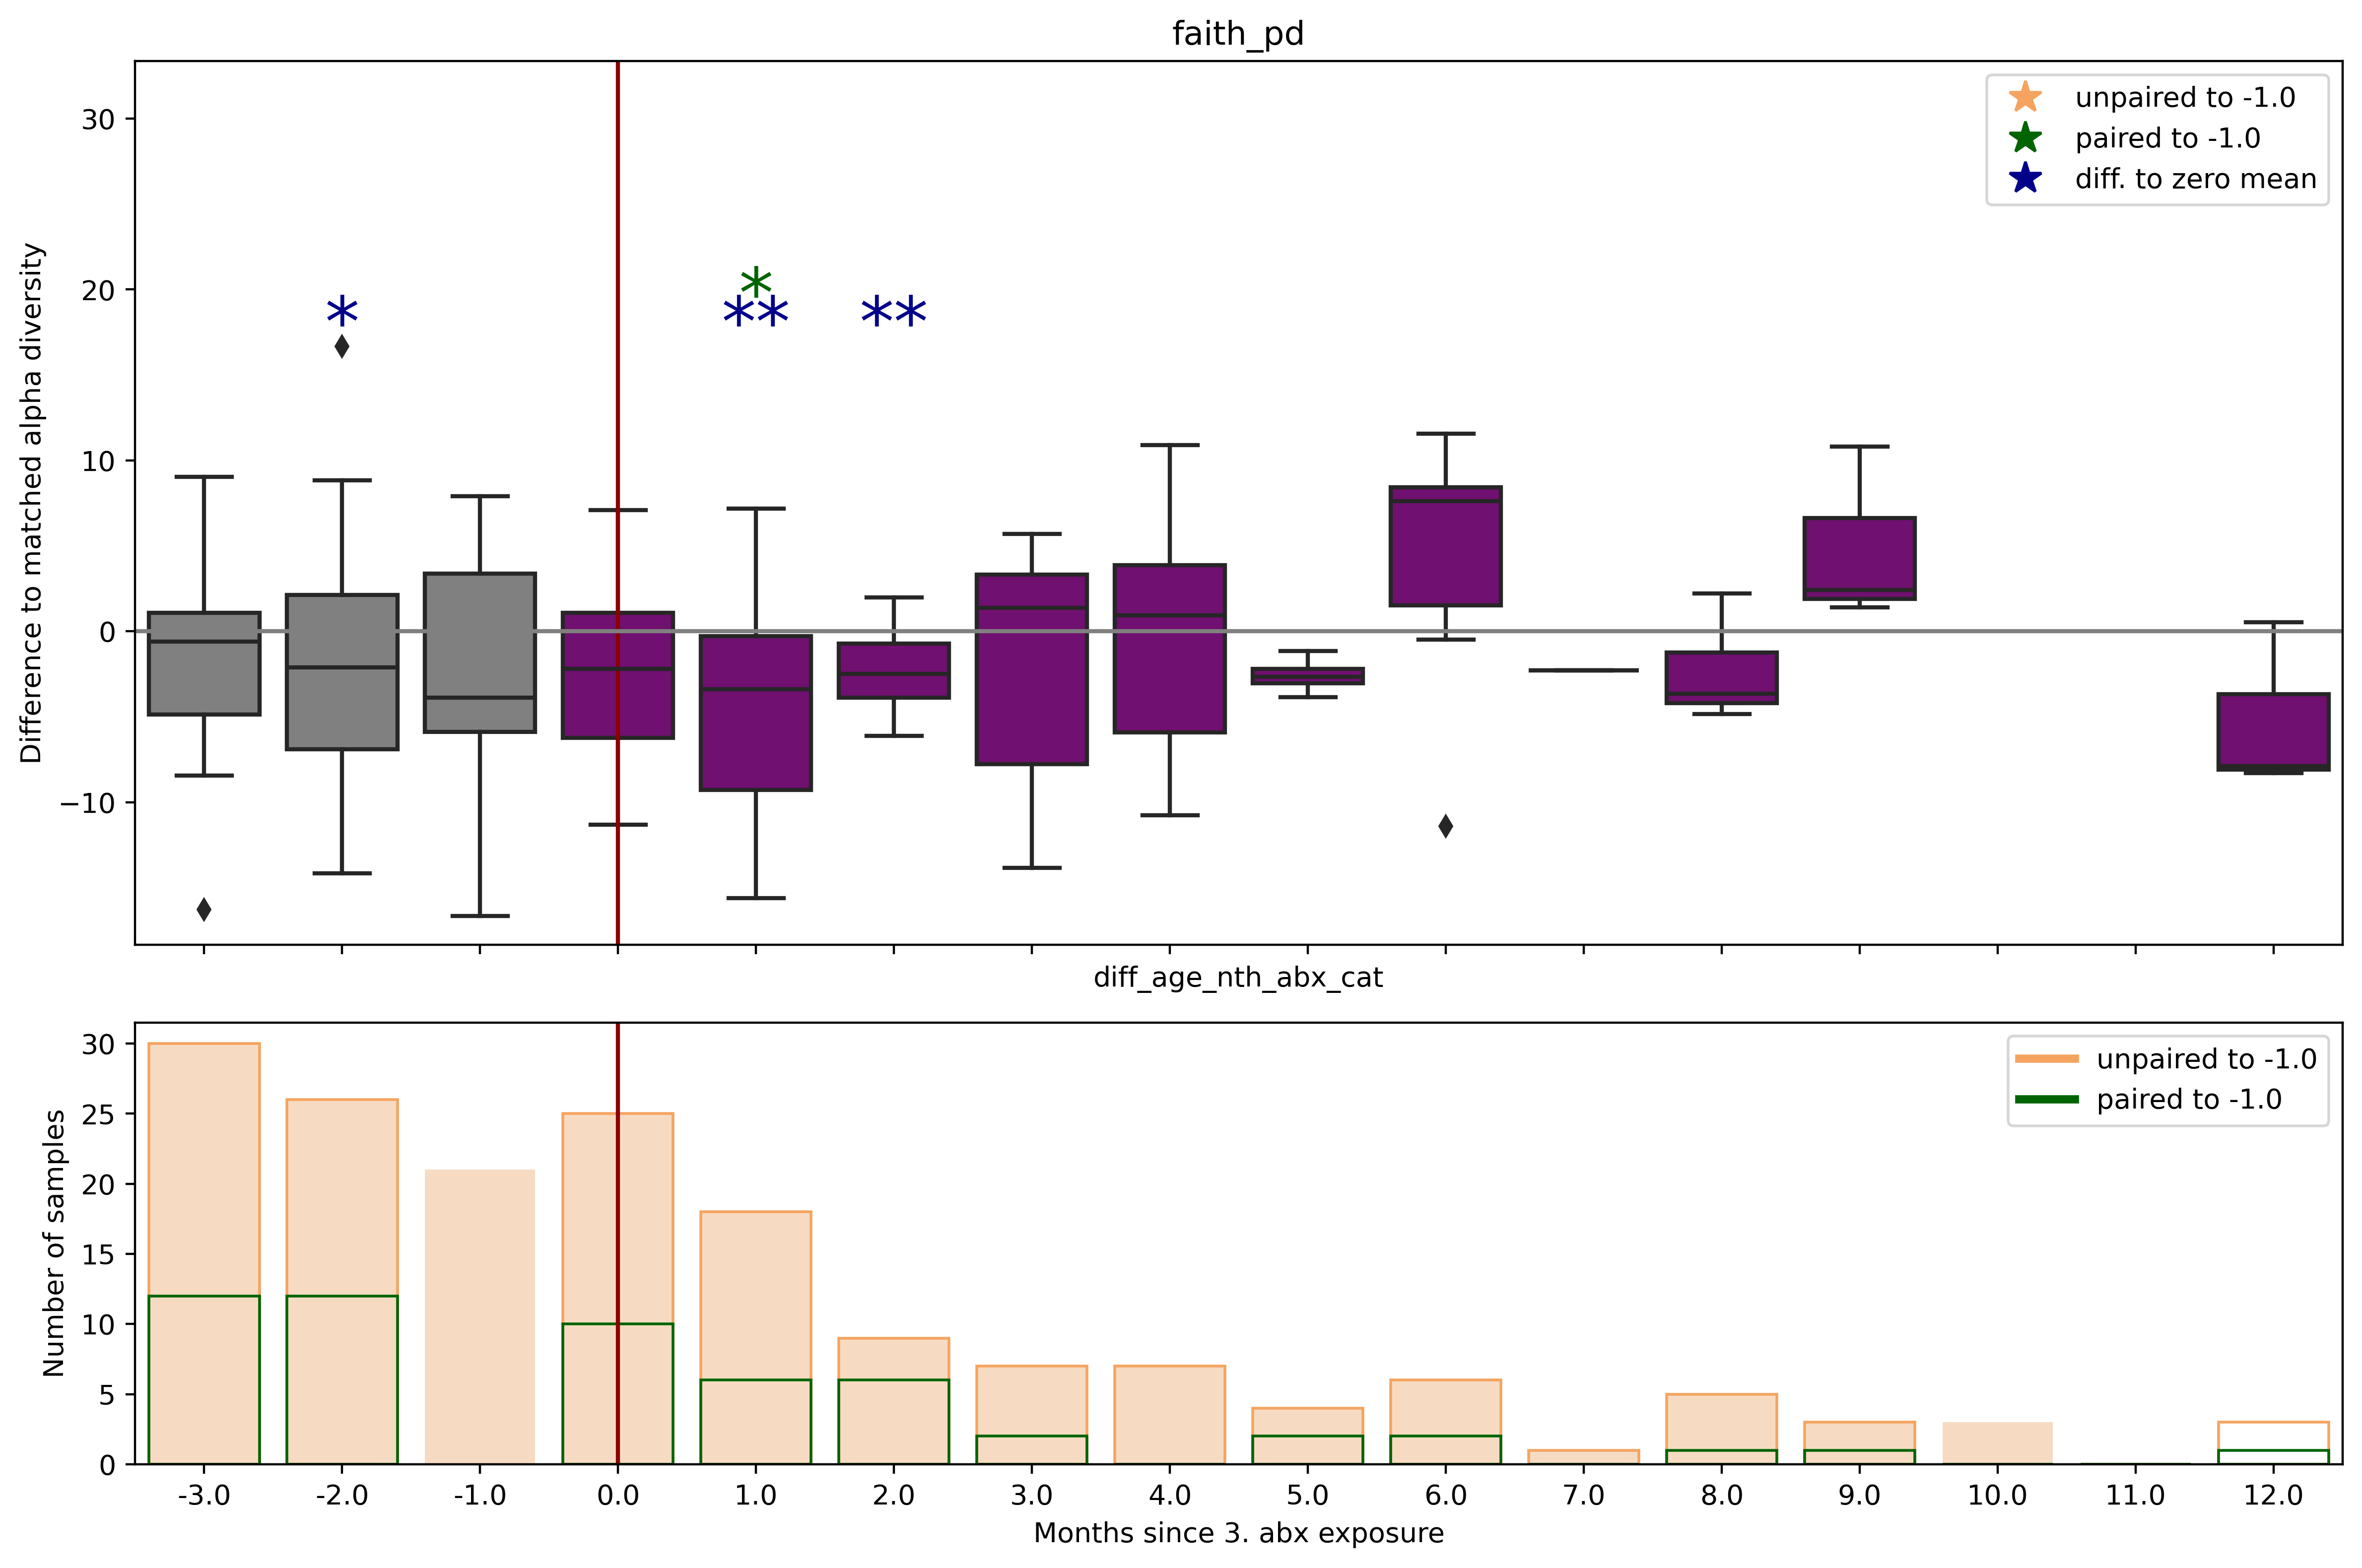

In [17]:
for i in range(1, 4):
    fig_t, dic_kw_t = calculate_nth_abx_effect_on_diversity(
        md_df,
        abx_df,
        i,
        path_to_output,
        cov_groups=matching_vars,
        div_metrics=["div_alpha_faith_pd"],
    )

### Matched: 1st abx exposure effect on all diversity metrics


Number of samples disregarded because of lacking reference in noabx: 1


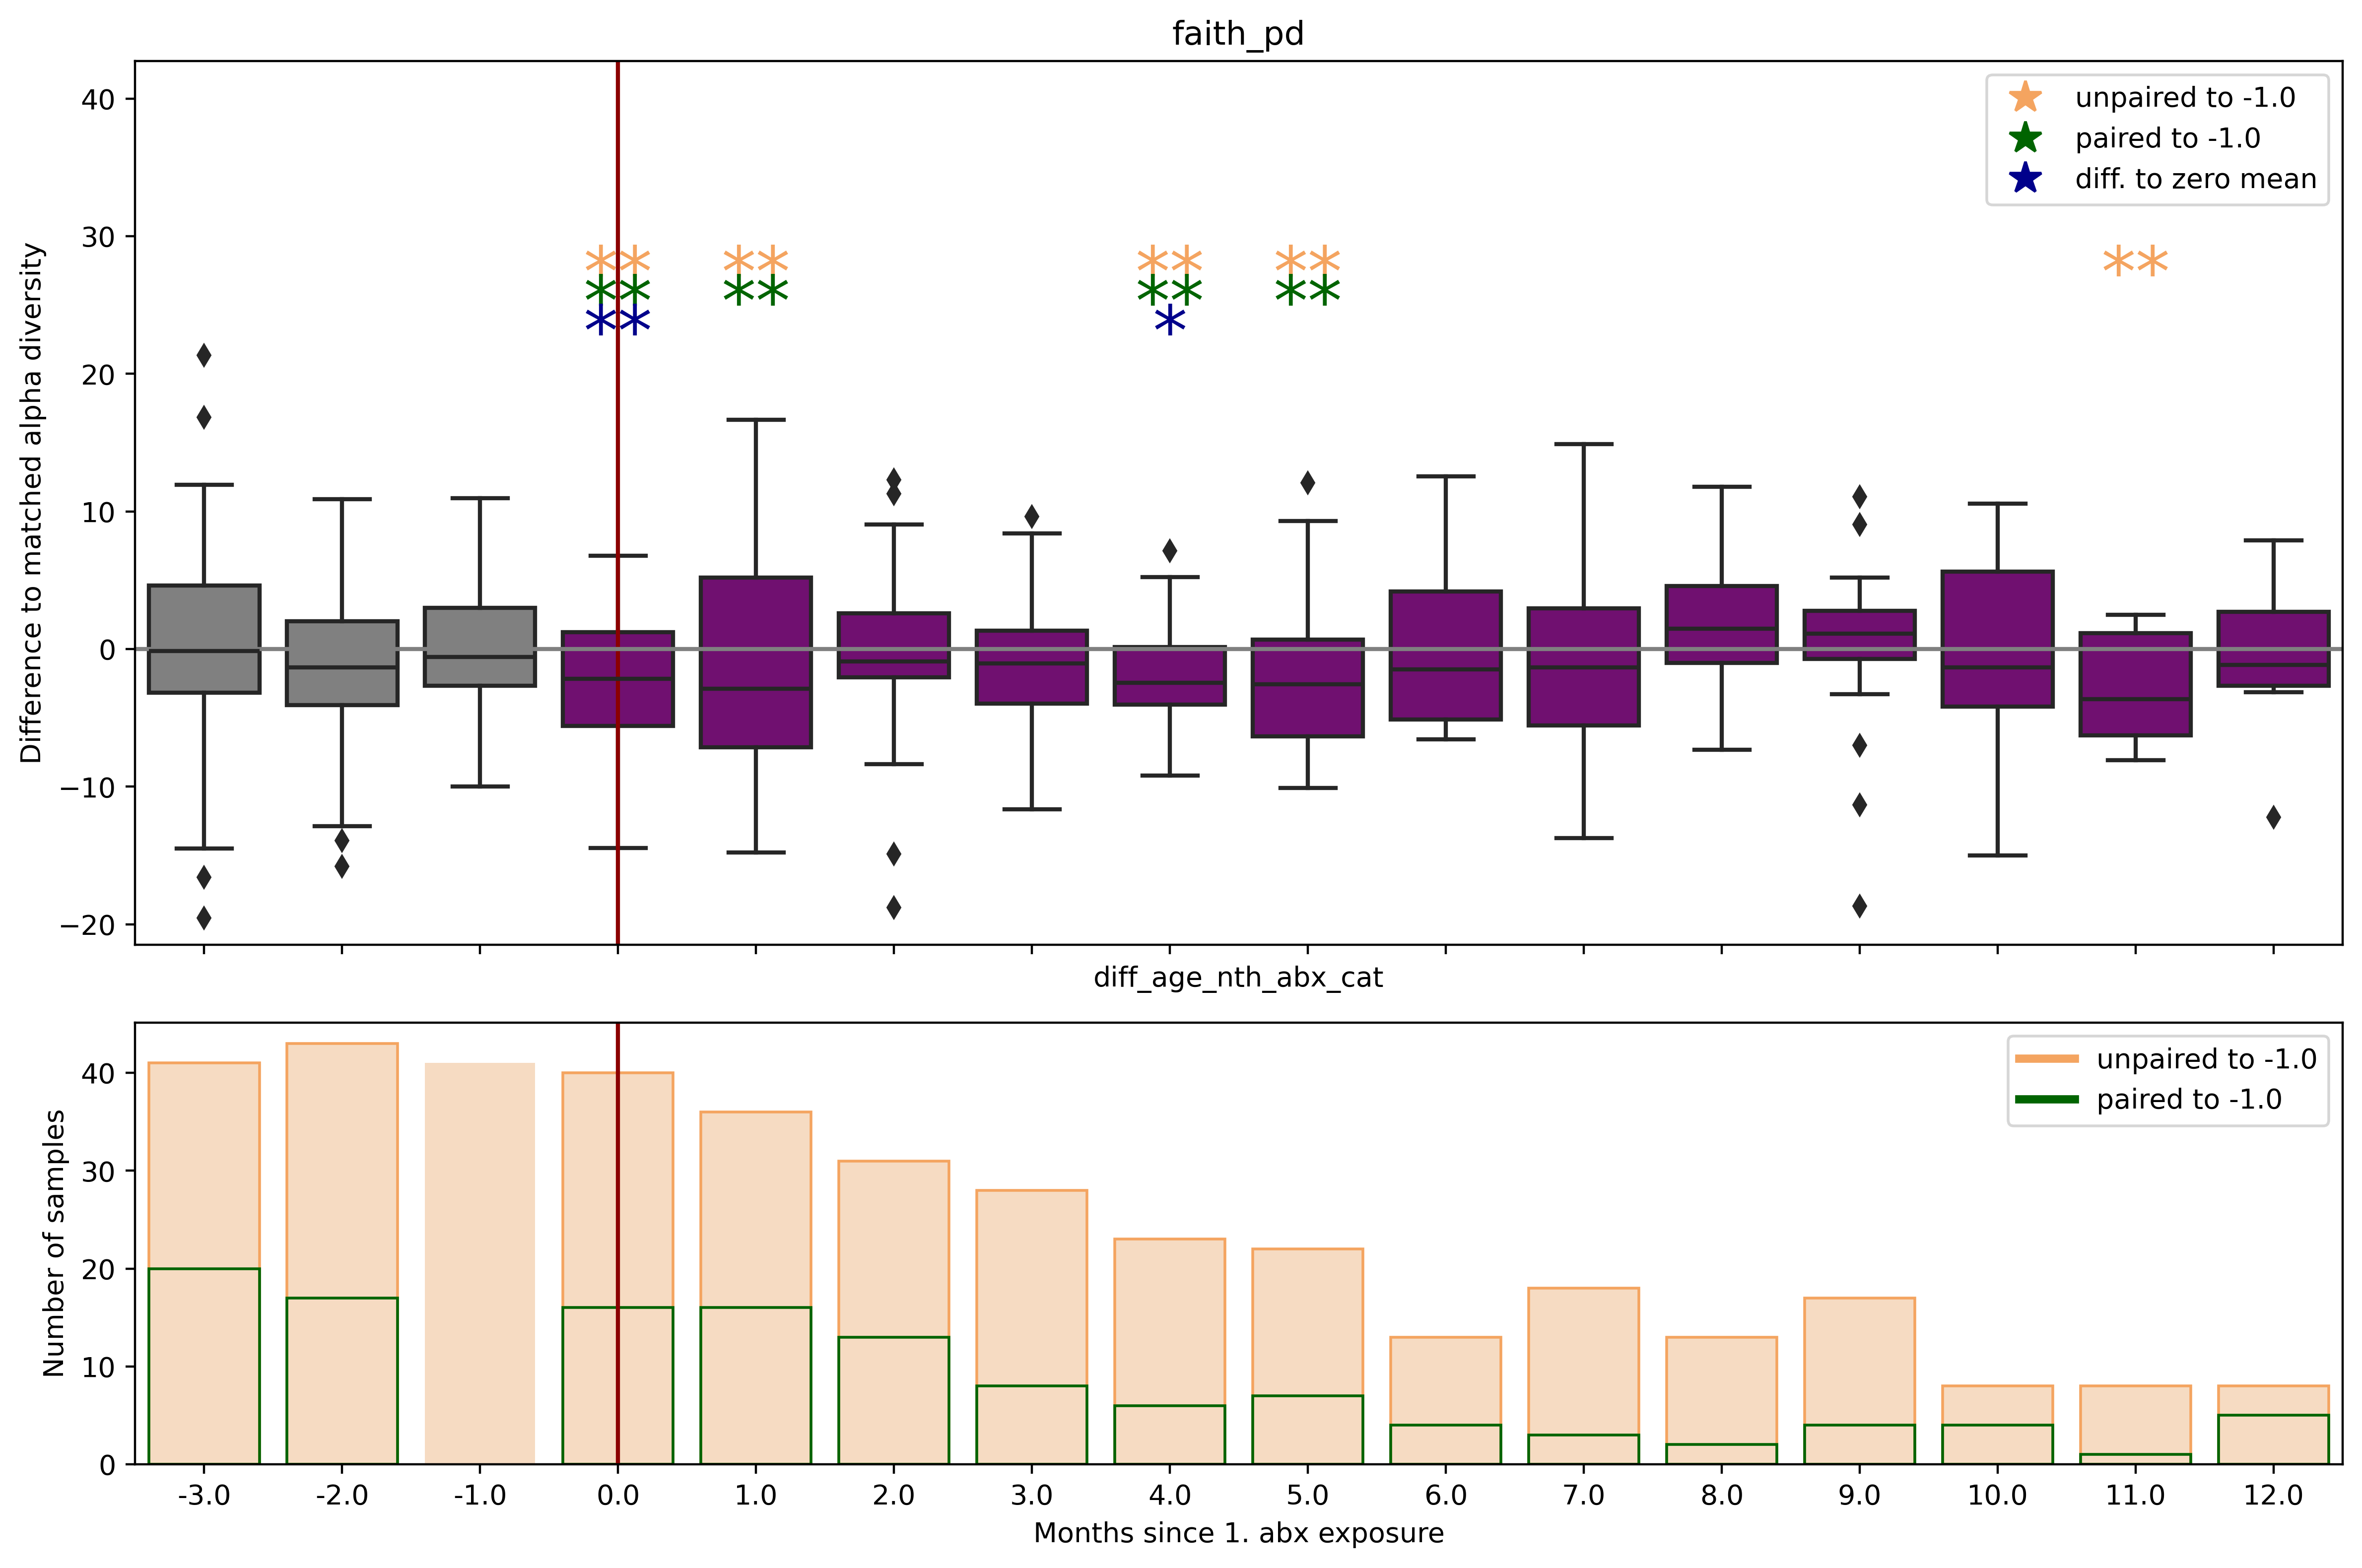

Number of samples disregarded because of lacking reference in noabx: 0


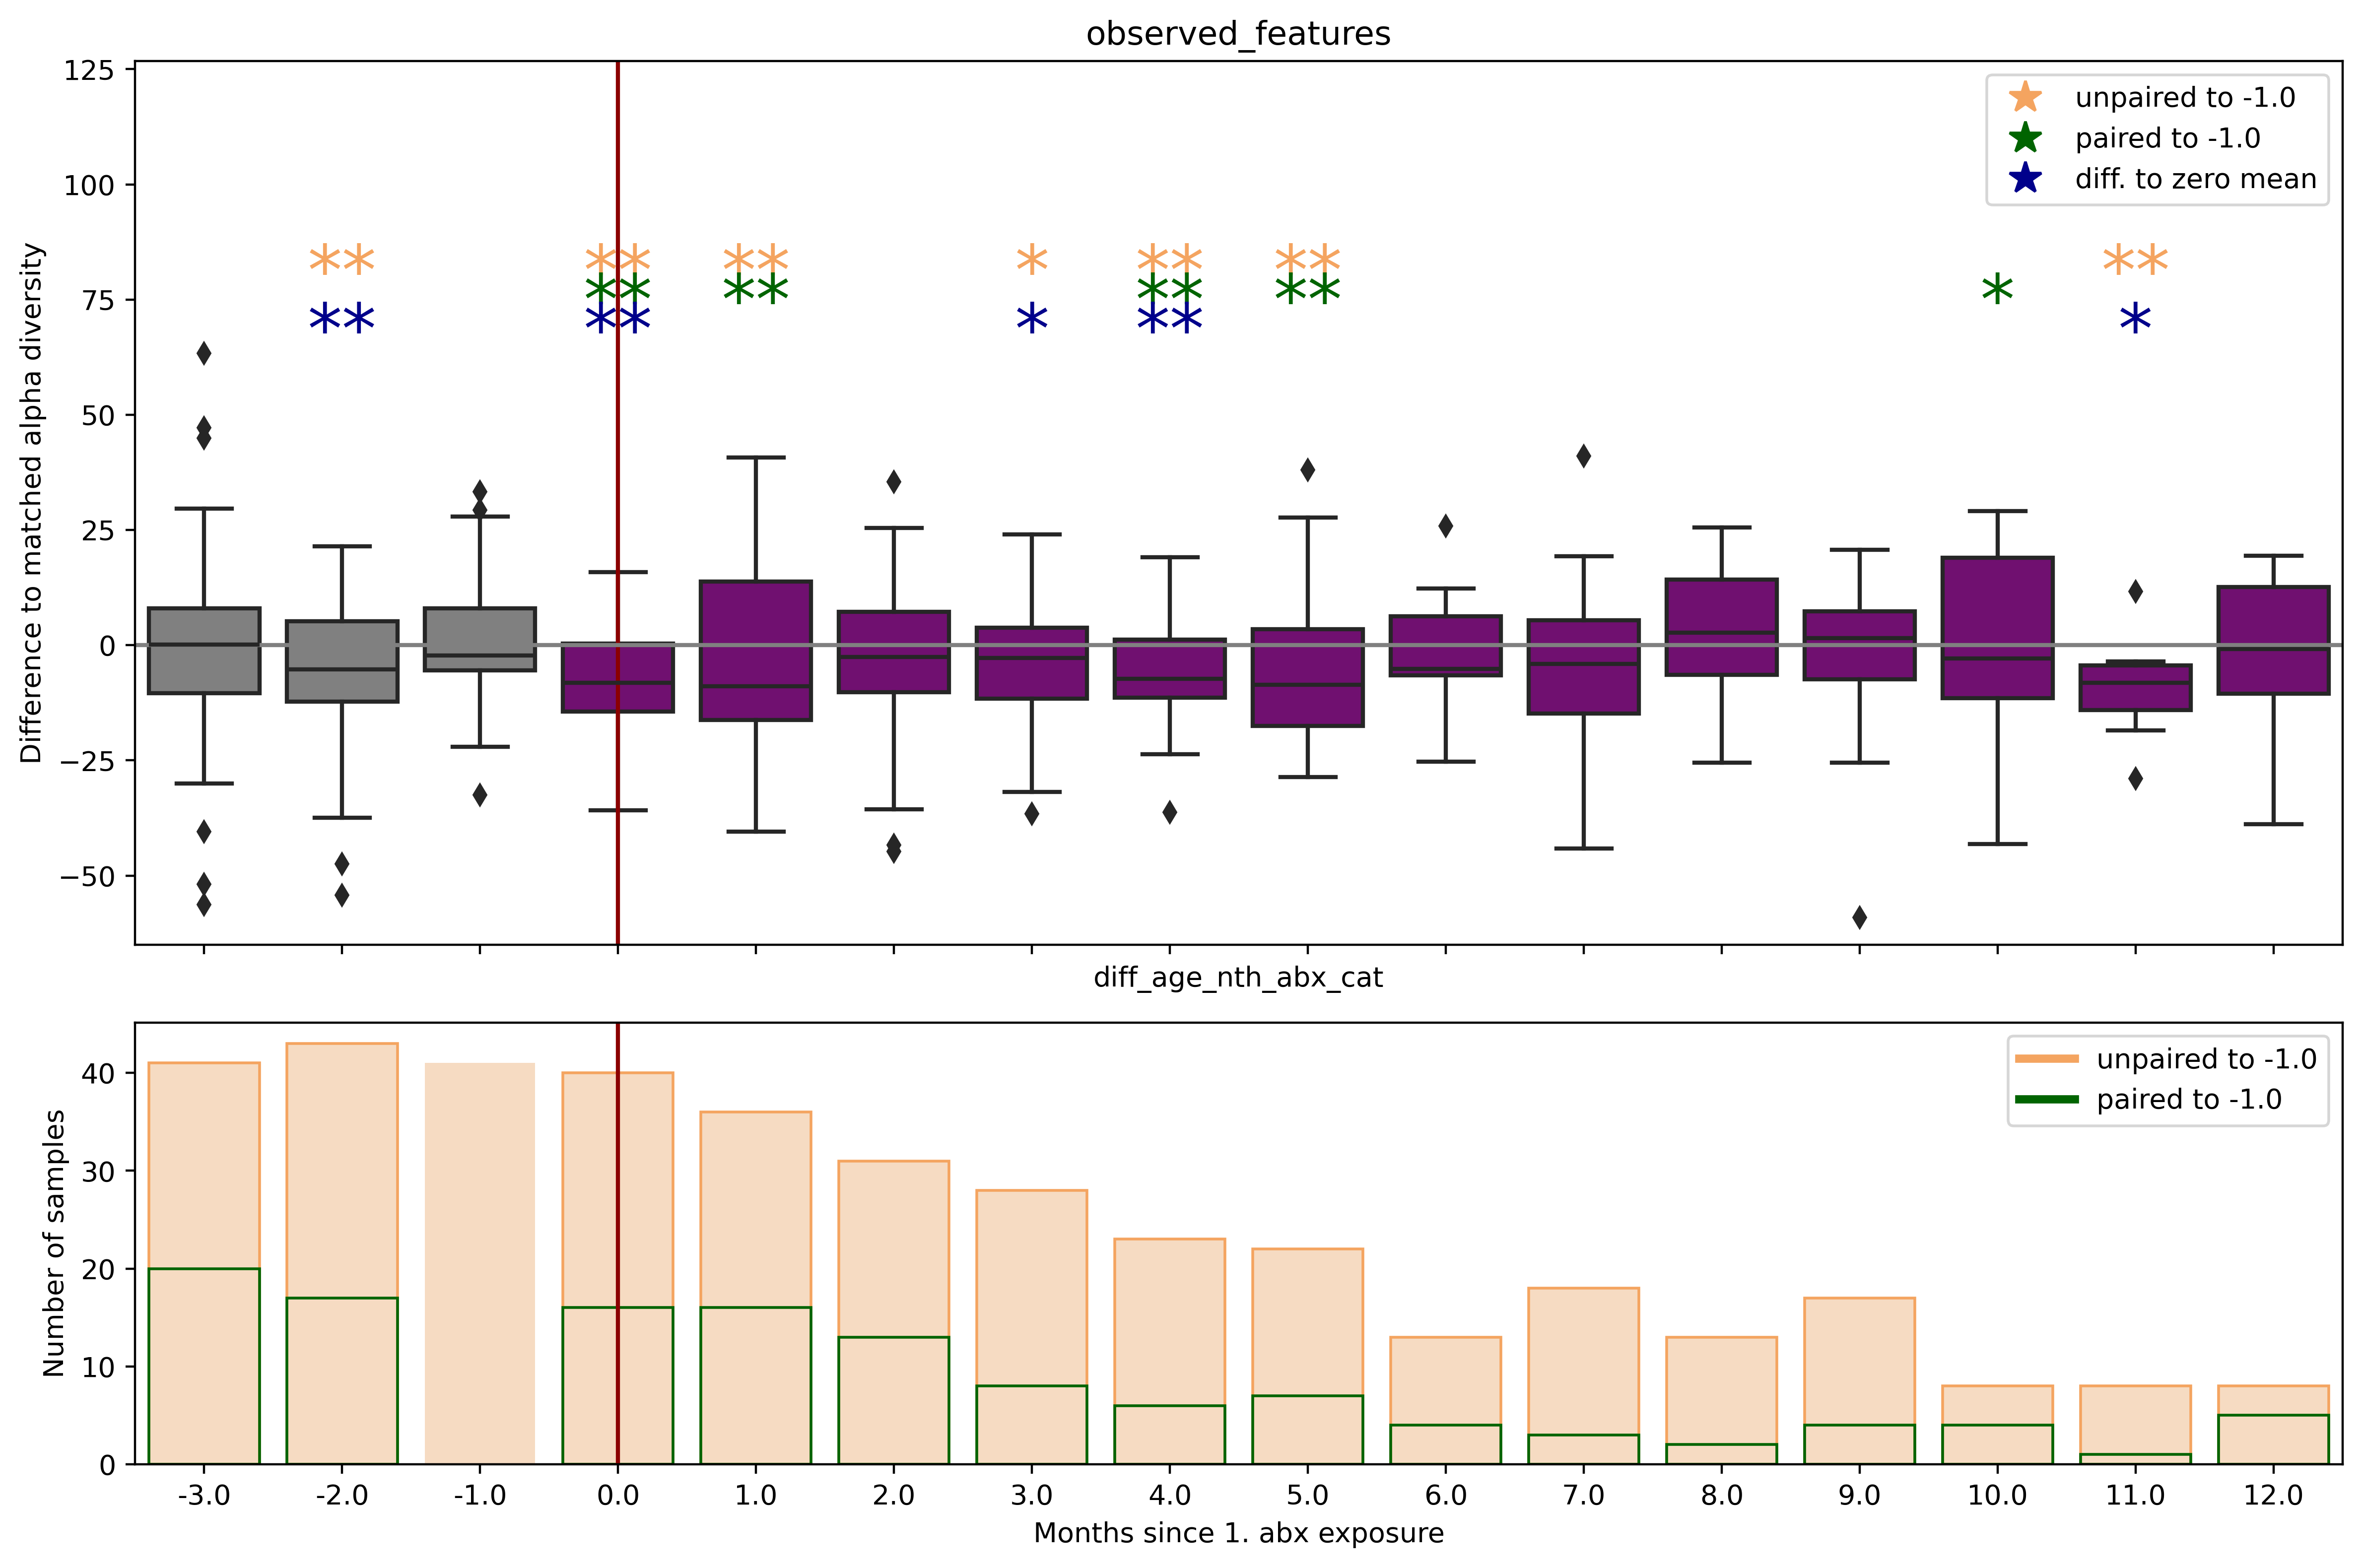

Number of samples disregarded because of lacking reference in noabx: 0


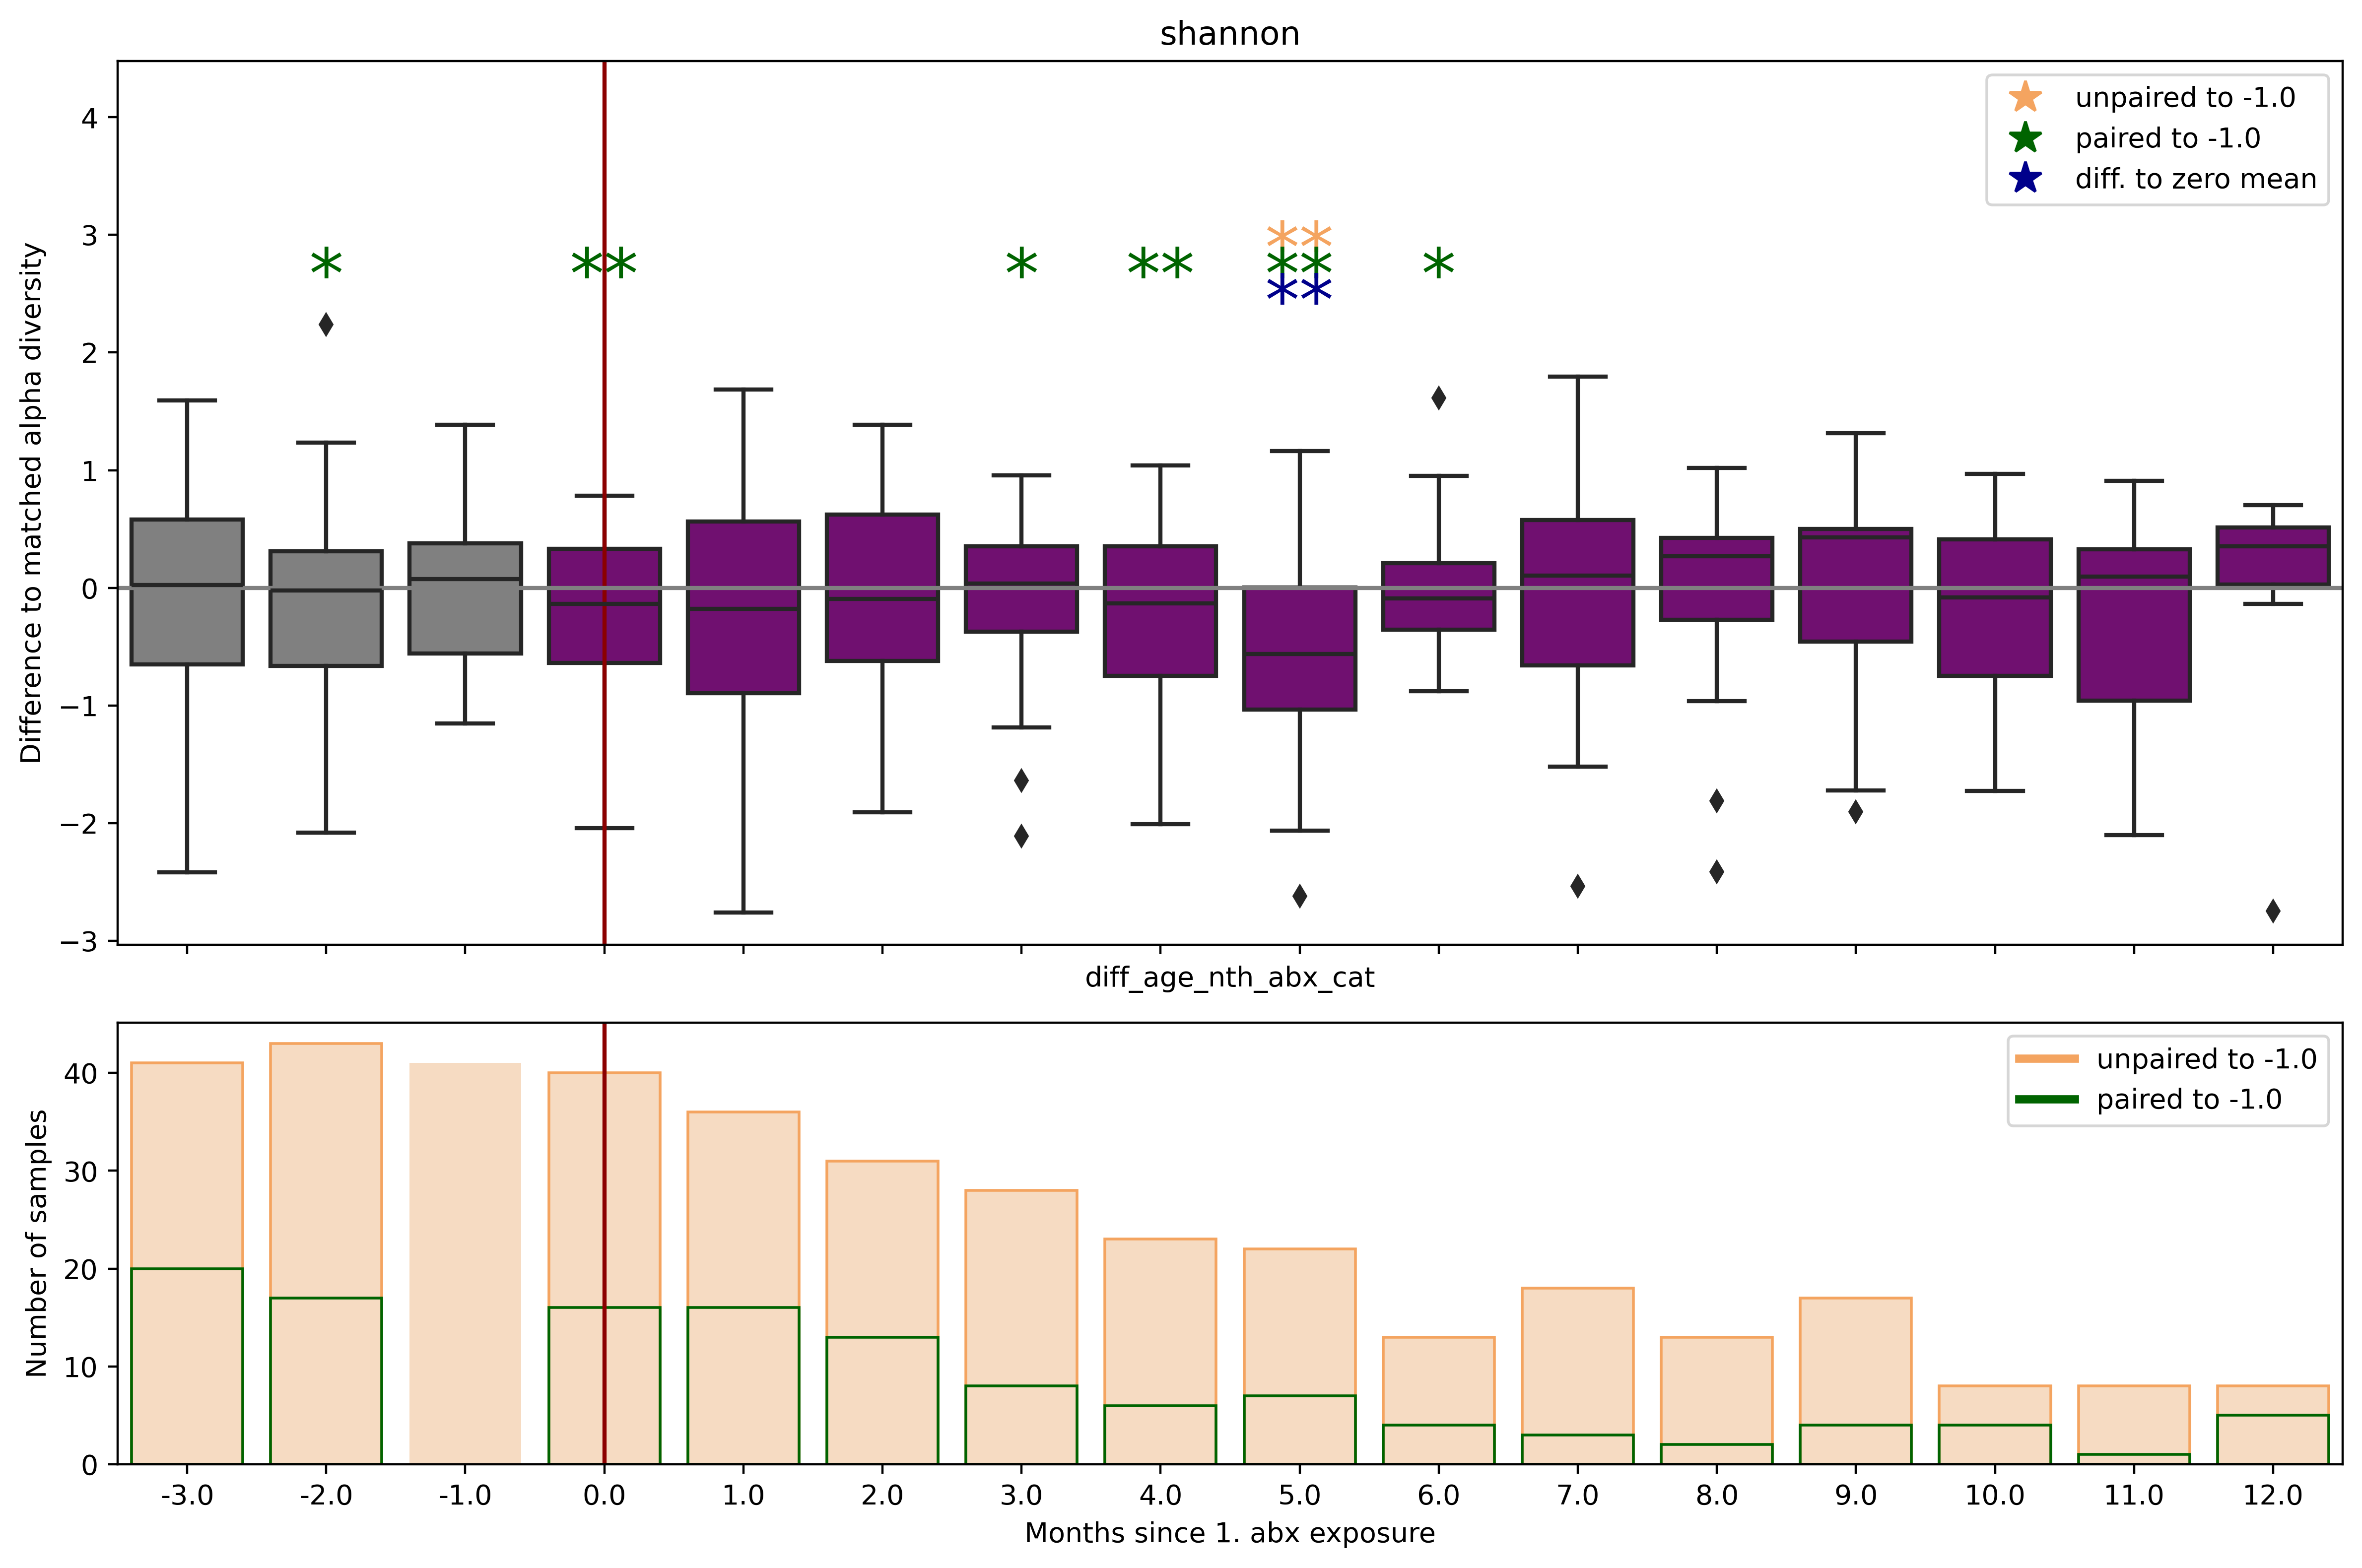

In [18]:
fig_1st, dic_kw_1st = calculate_nth_abx_effect_on_diversity(
    md_df,
    abx_df,
    1,
    path_to_output,
    cov_groups=matching_vars,
)

### Matched 2nd abx effect on all diversity metrics

Number of samples disregarded because of lacking reference in noabx: 2


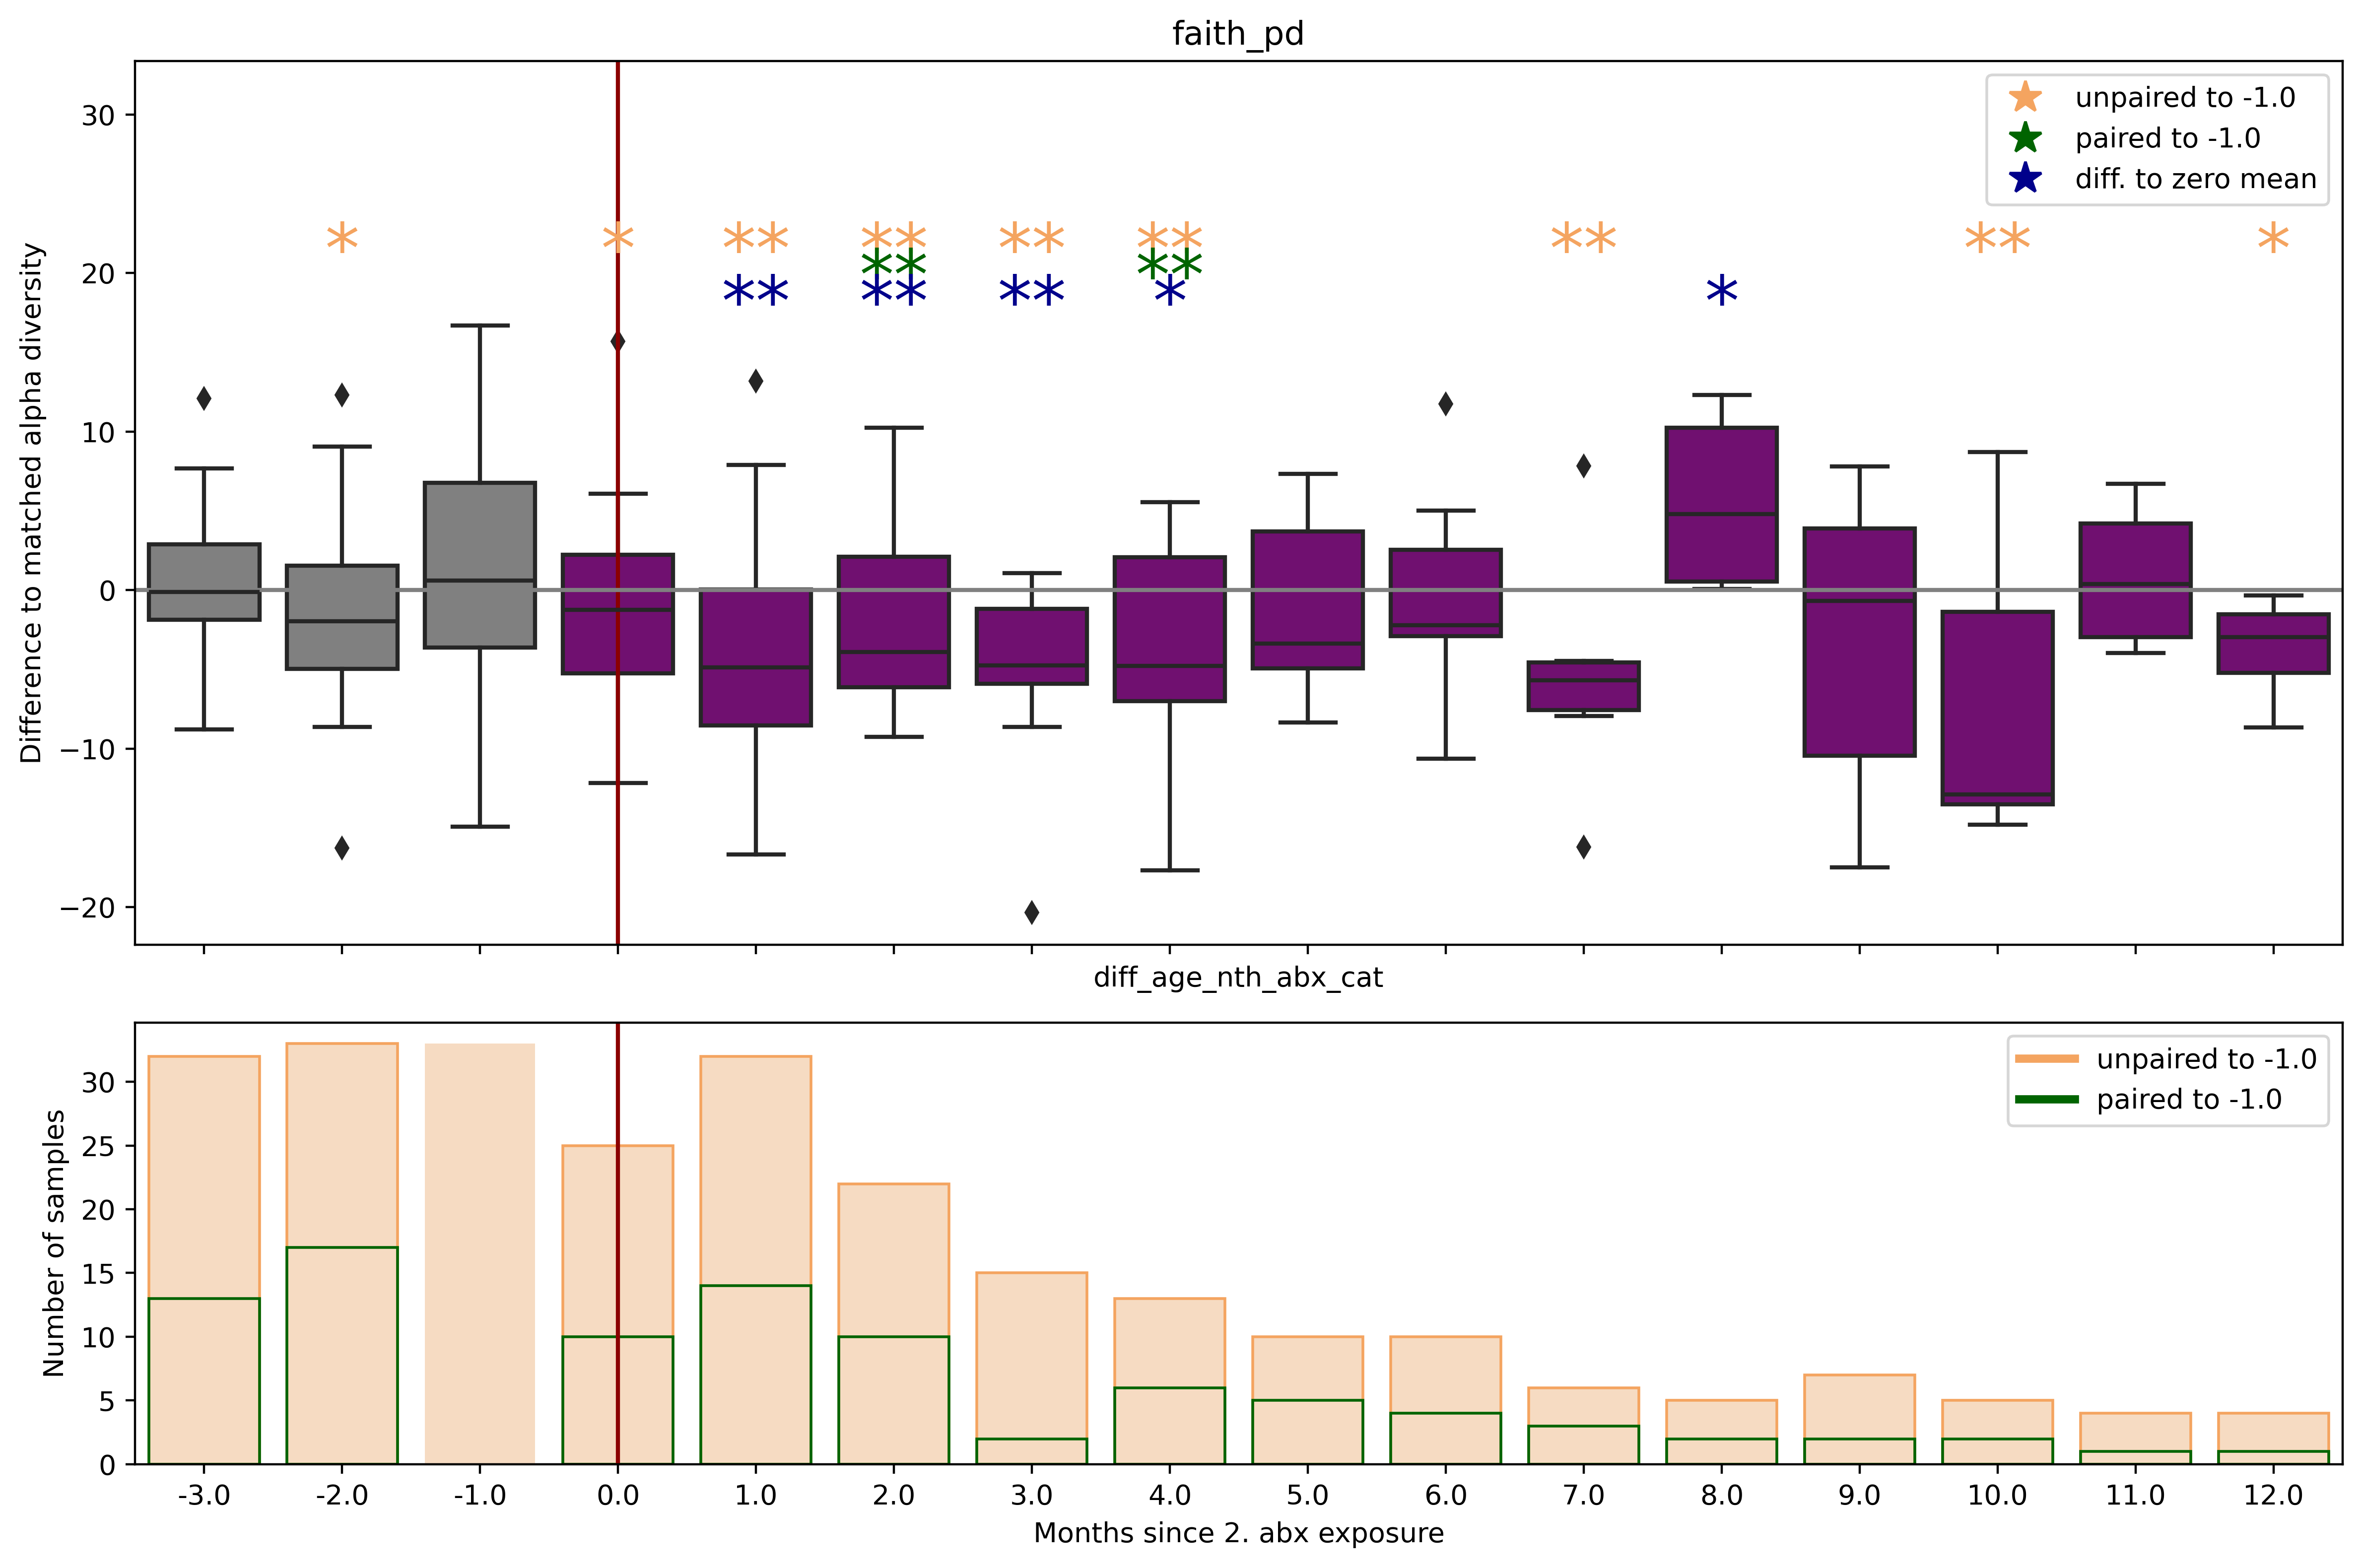

Number of samples disregarded because of lacking reference in noabx: 0


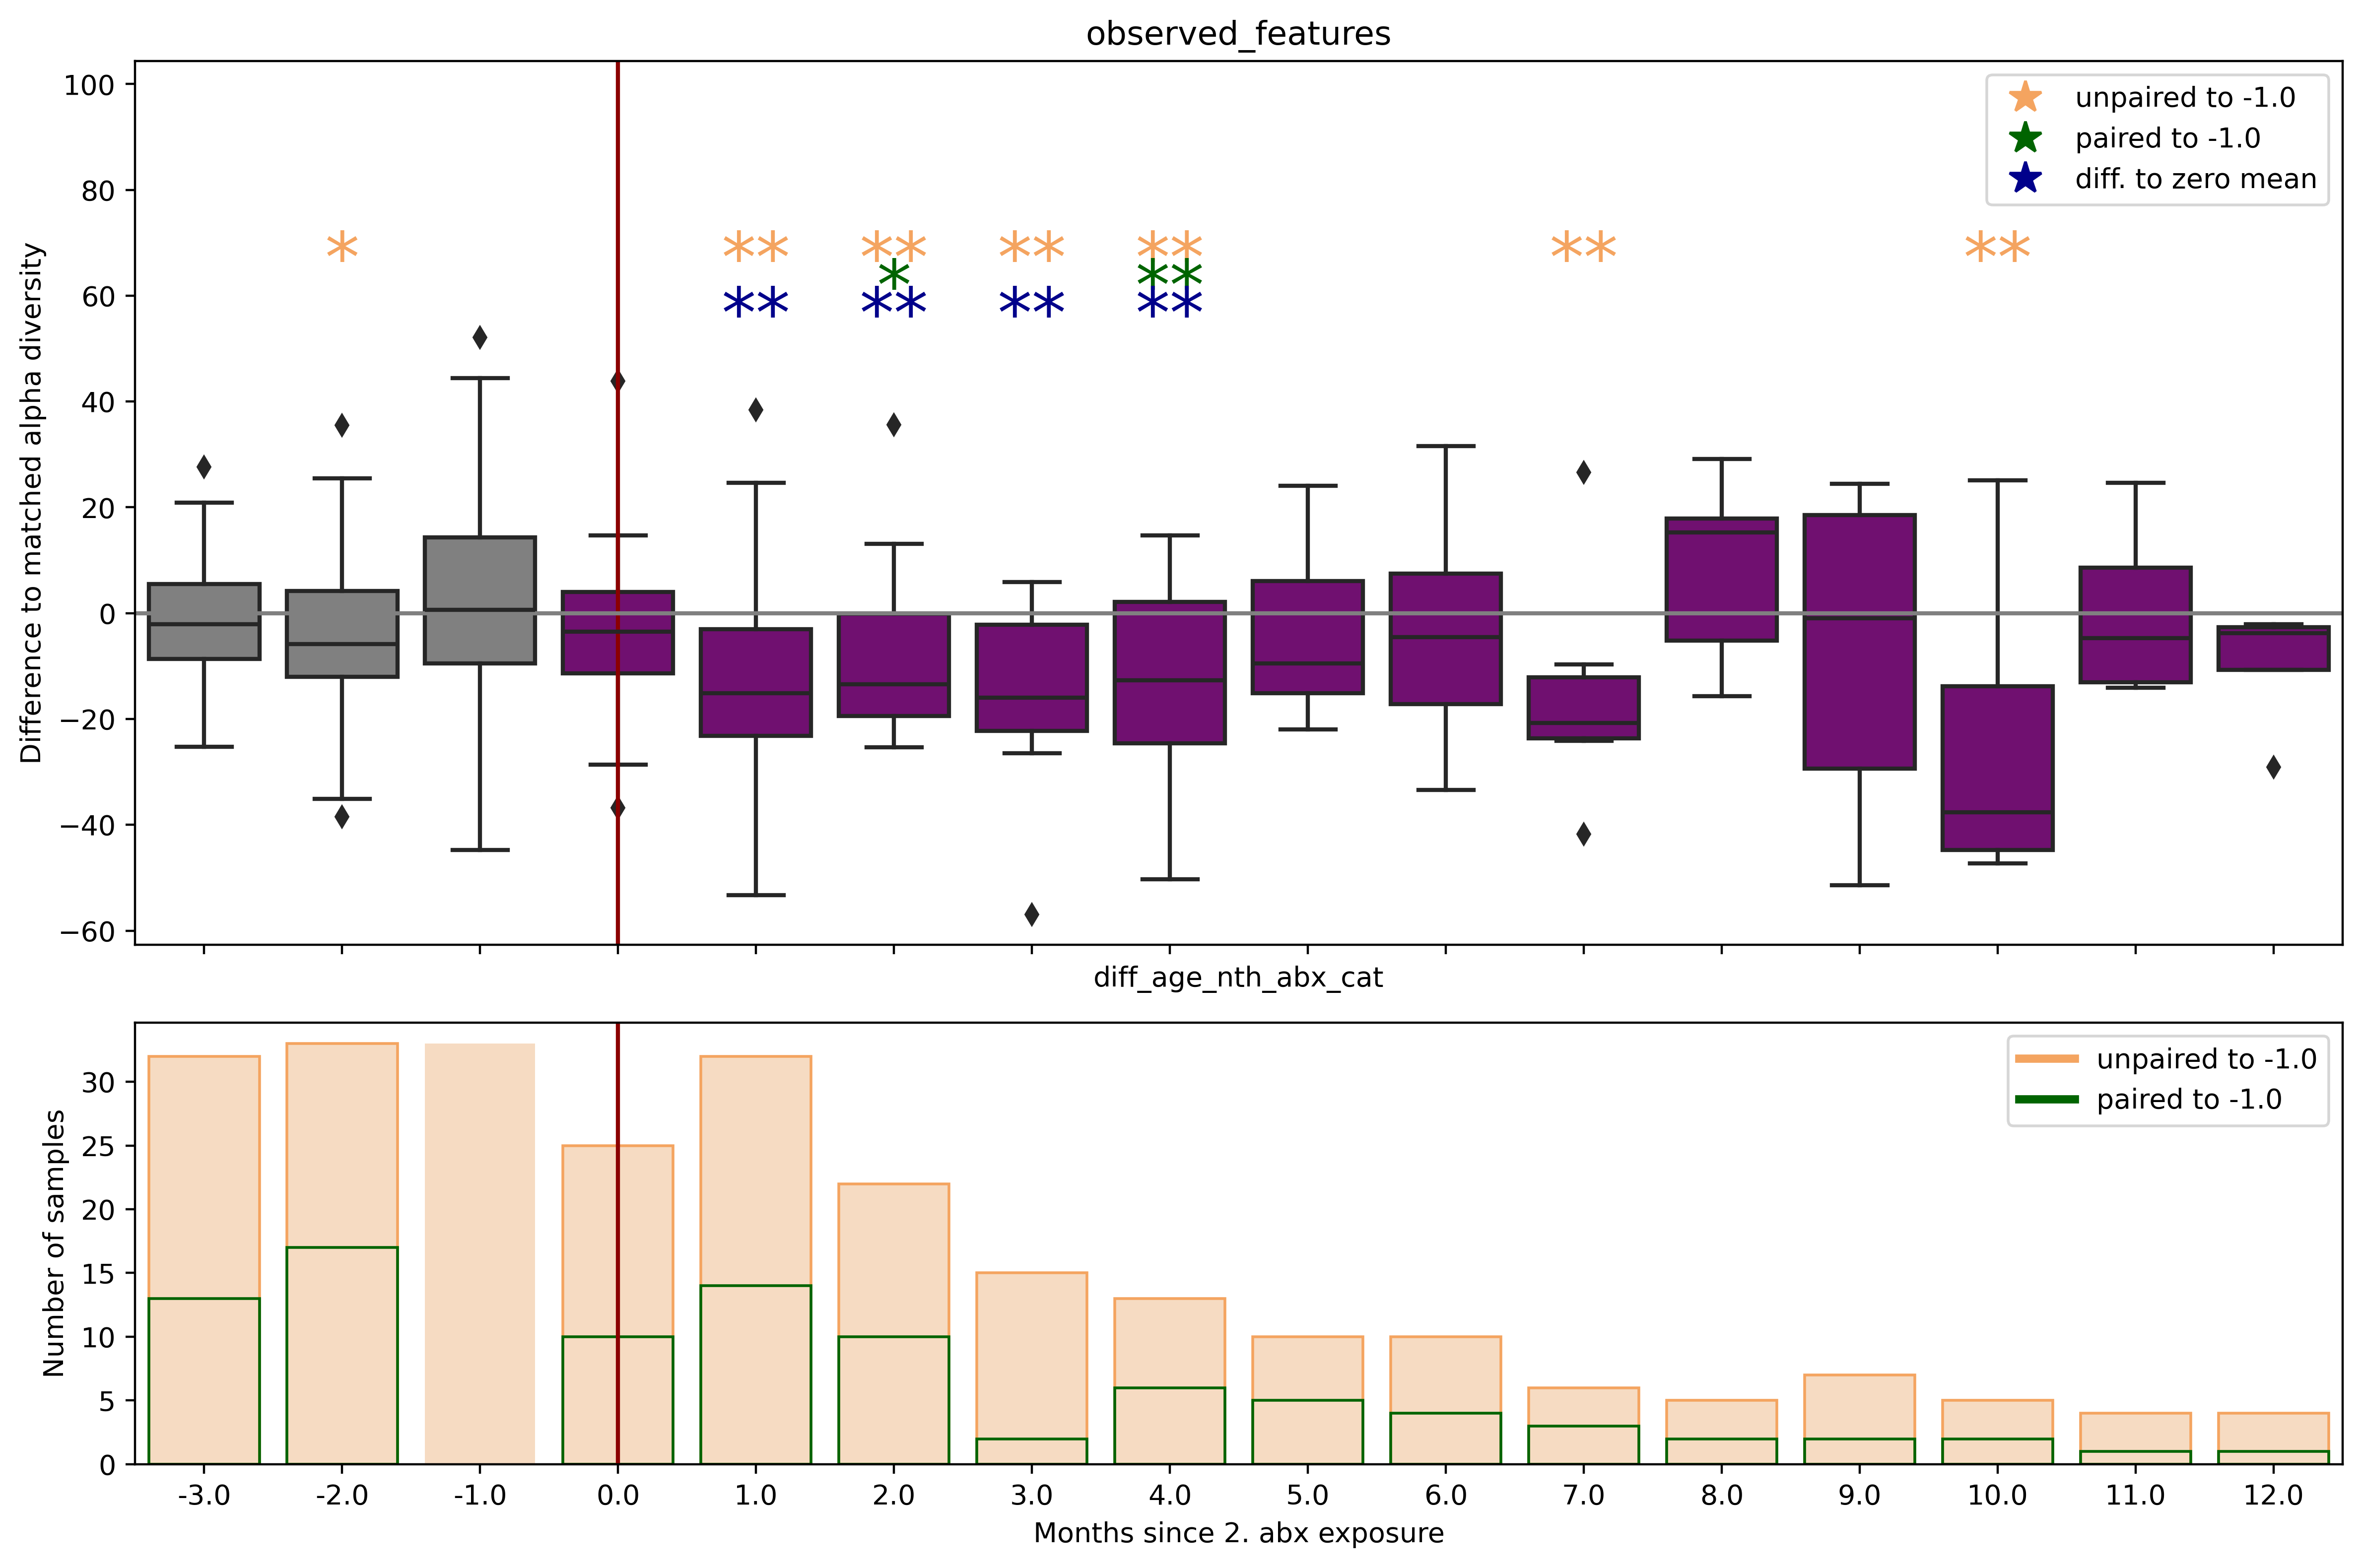

Number of samples disregarded because of lacking reference in noabx: 0


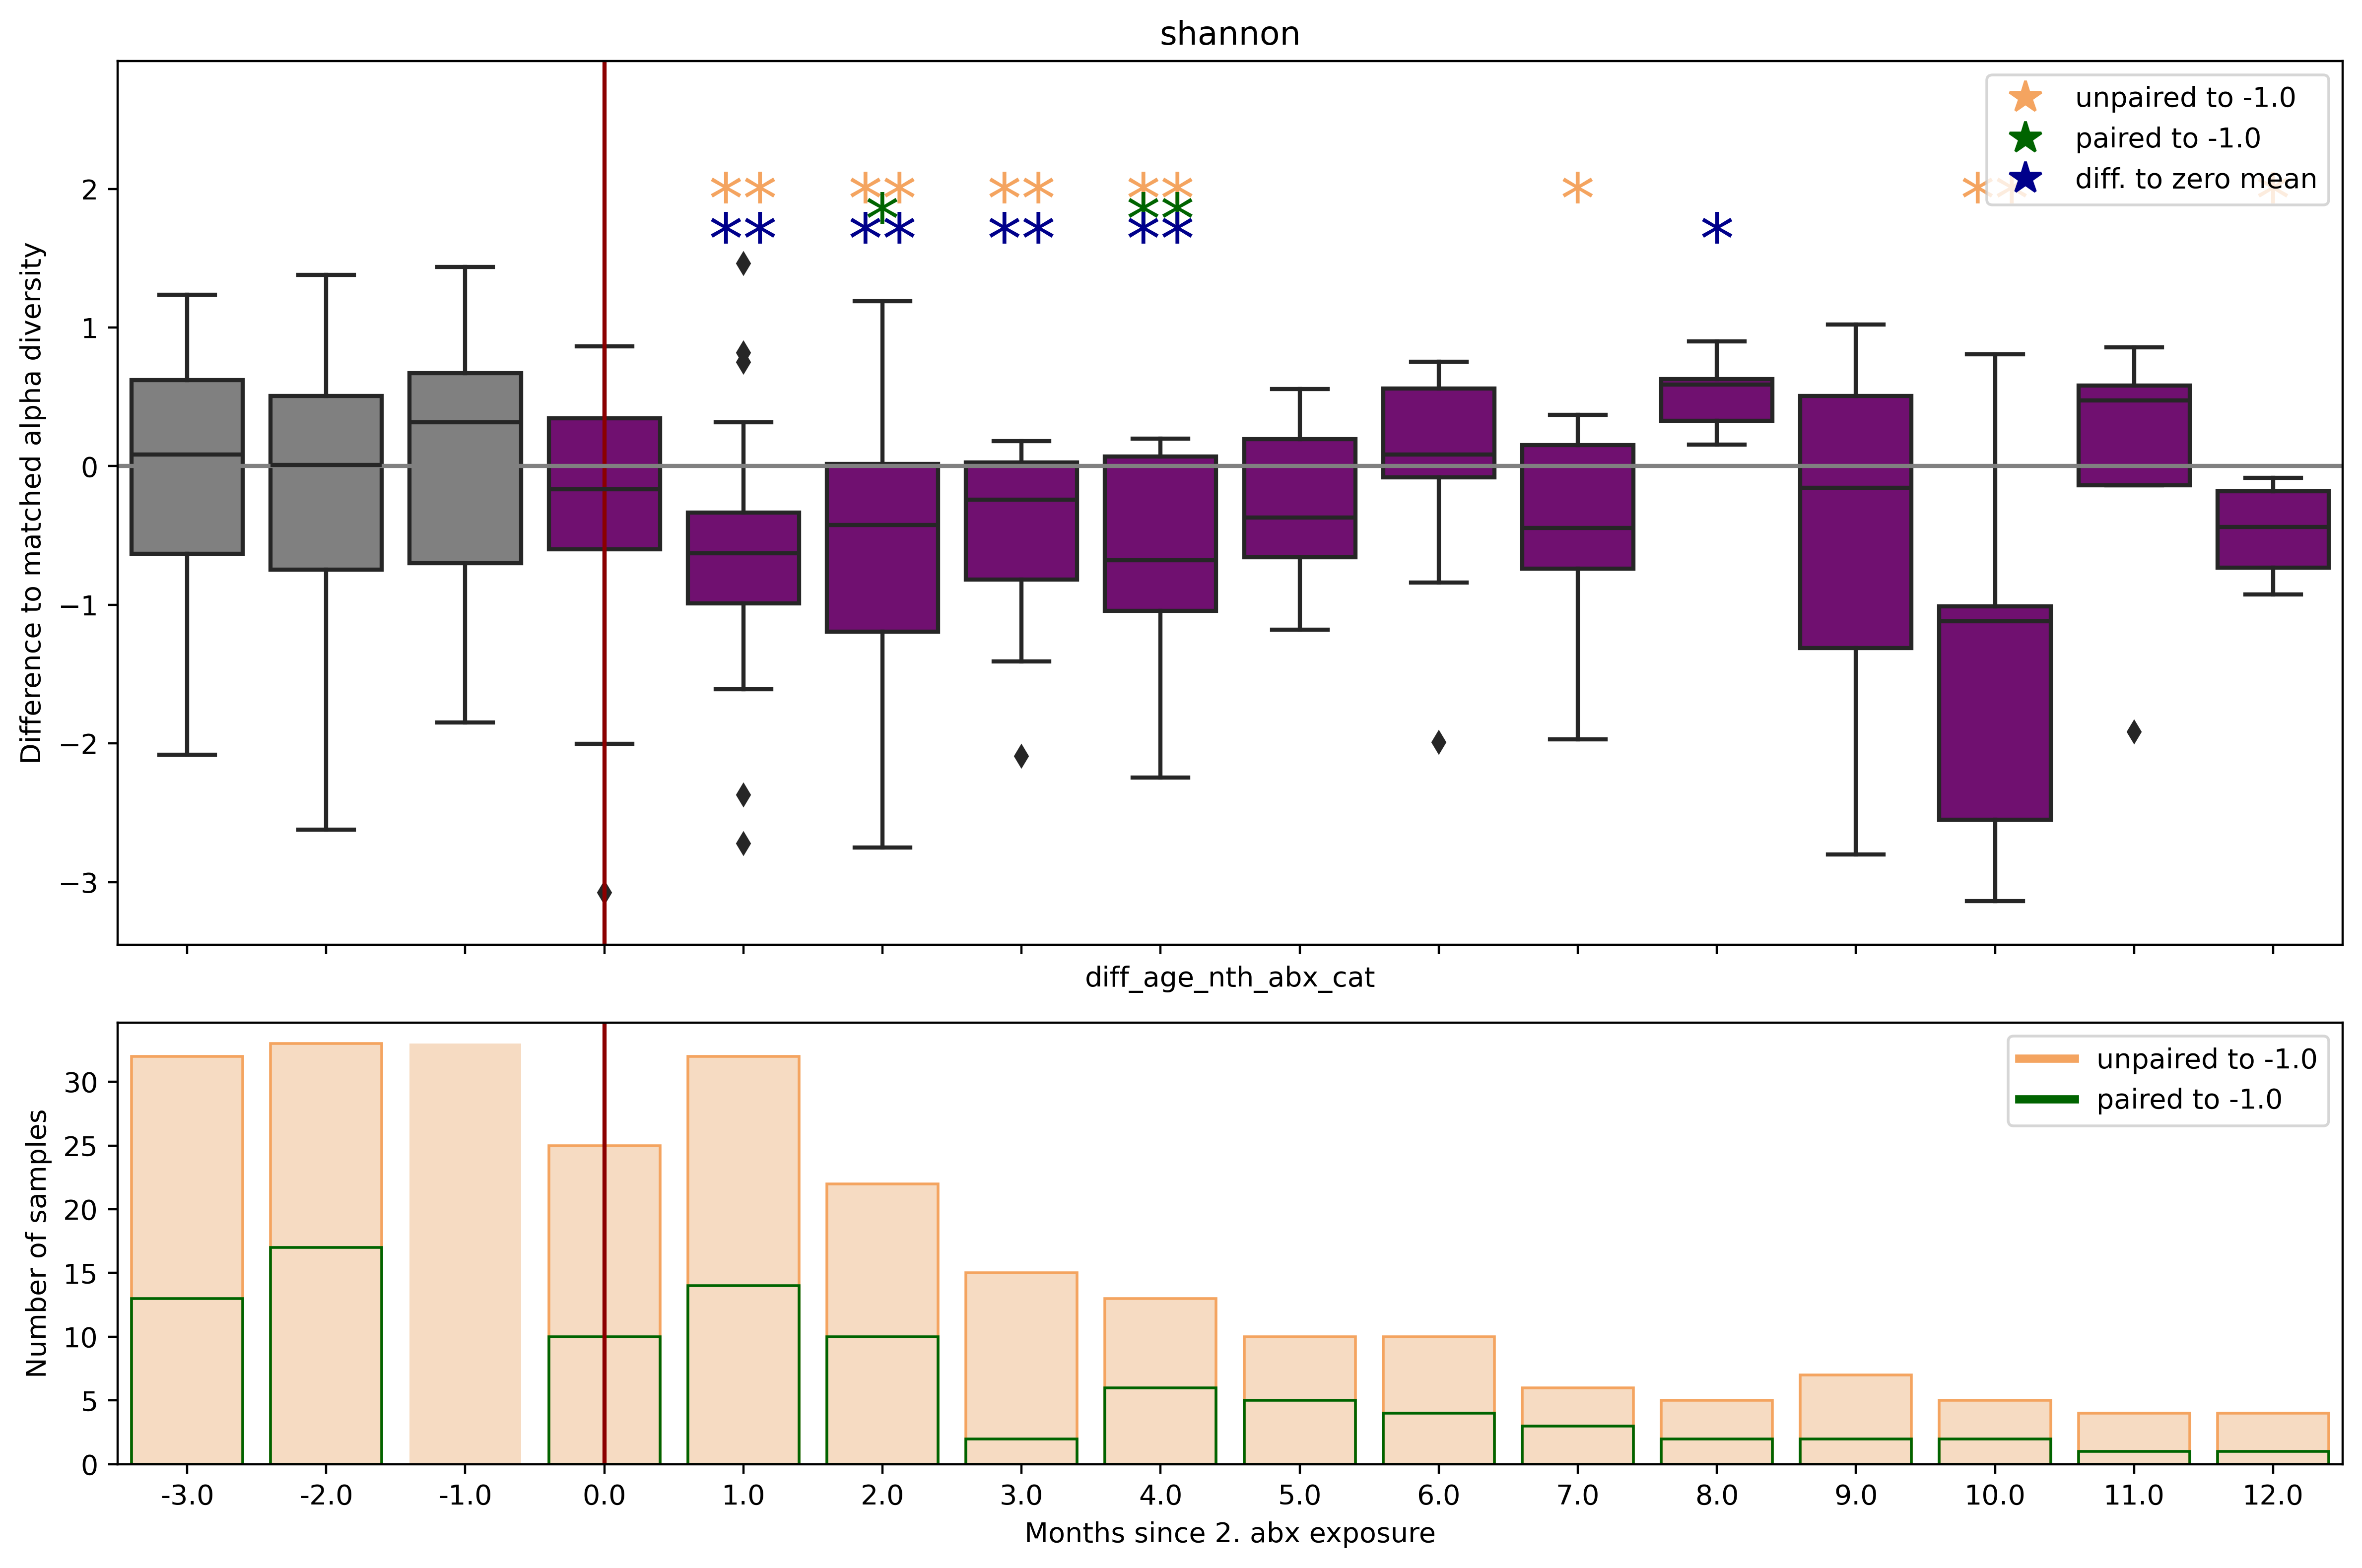

In [19]:
fig_2nd, dic_kw_2nd = calculate_nth_abx_effect_on_diversity(
    md_df,
    abx_df,
    2,
    path_to_output,
    cov_groups=matching_vars,
)

### Matched 3rd abx effect on all diversity metrics

Number of samples disregarded because of lacking reference in noabx: 0


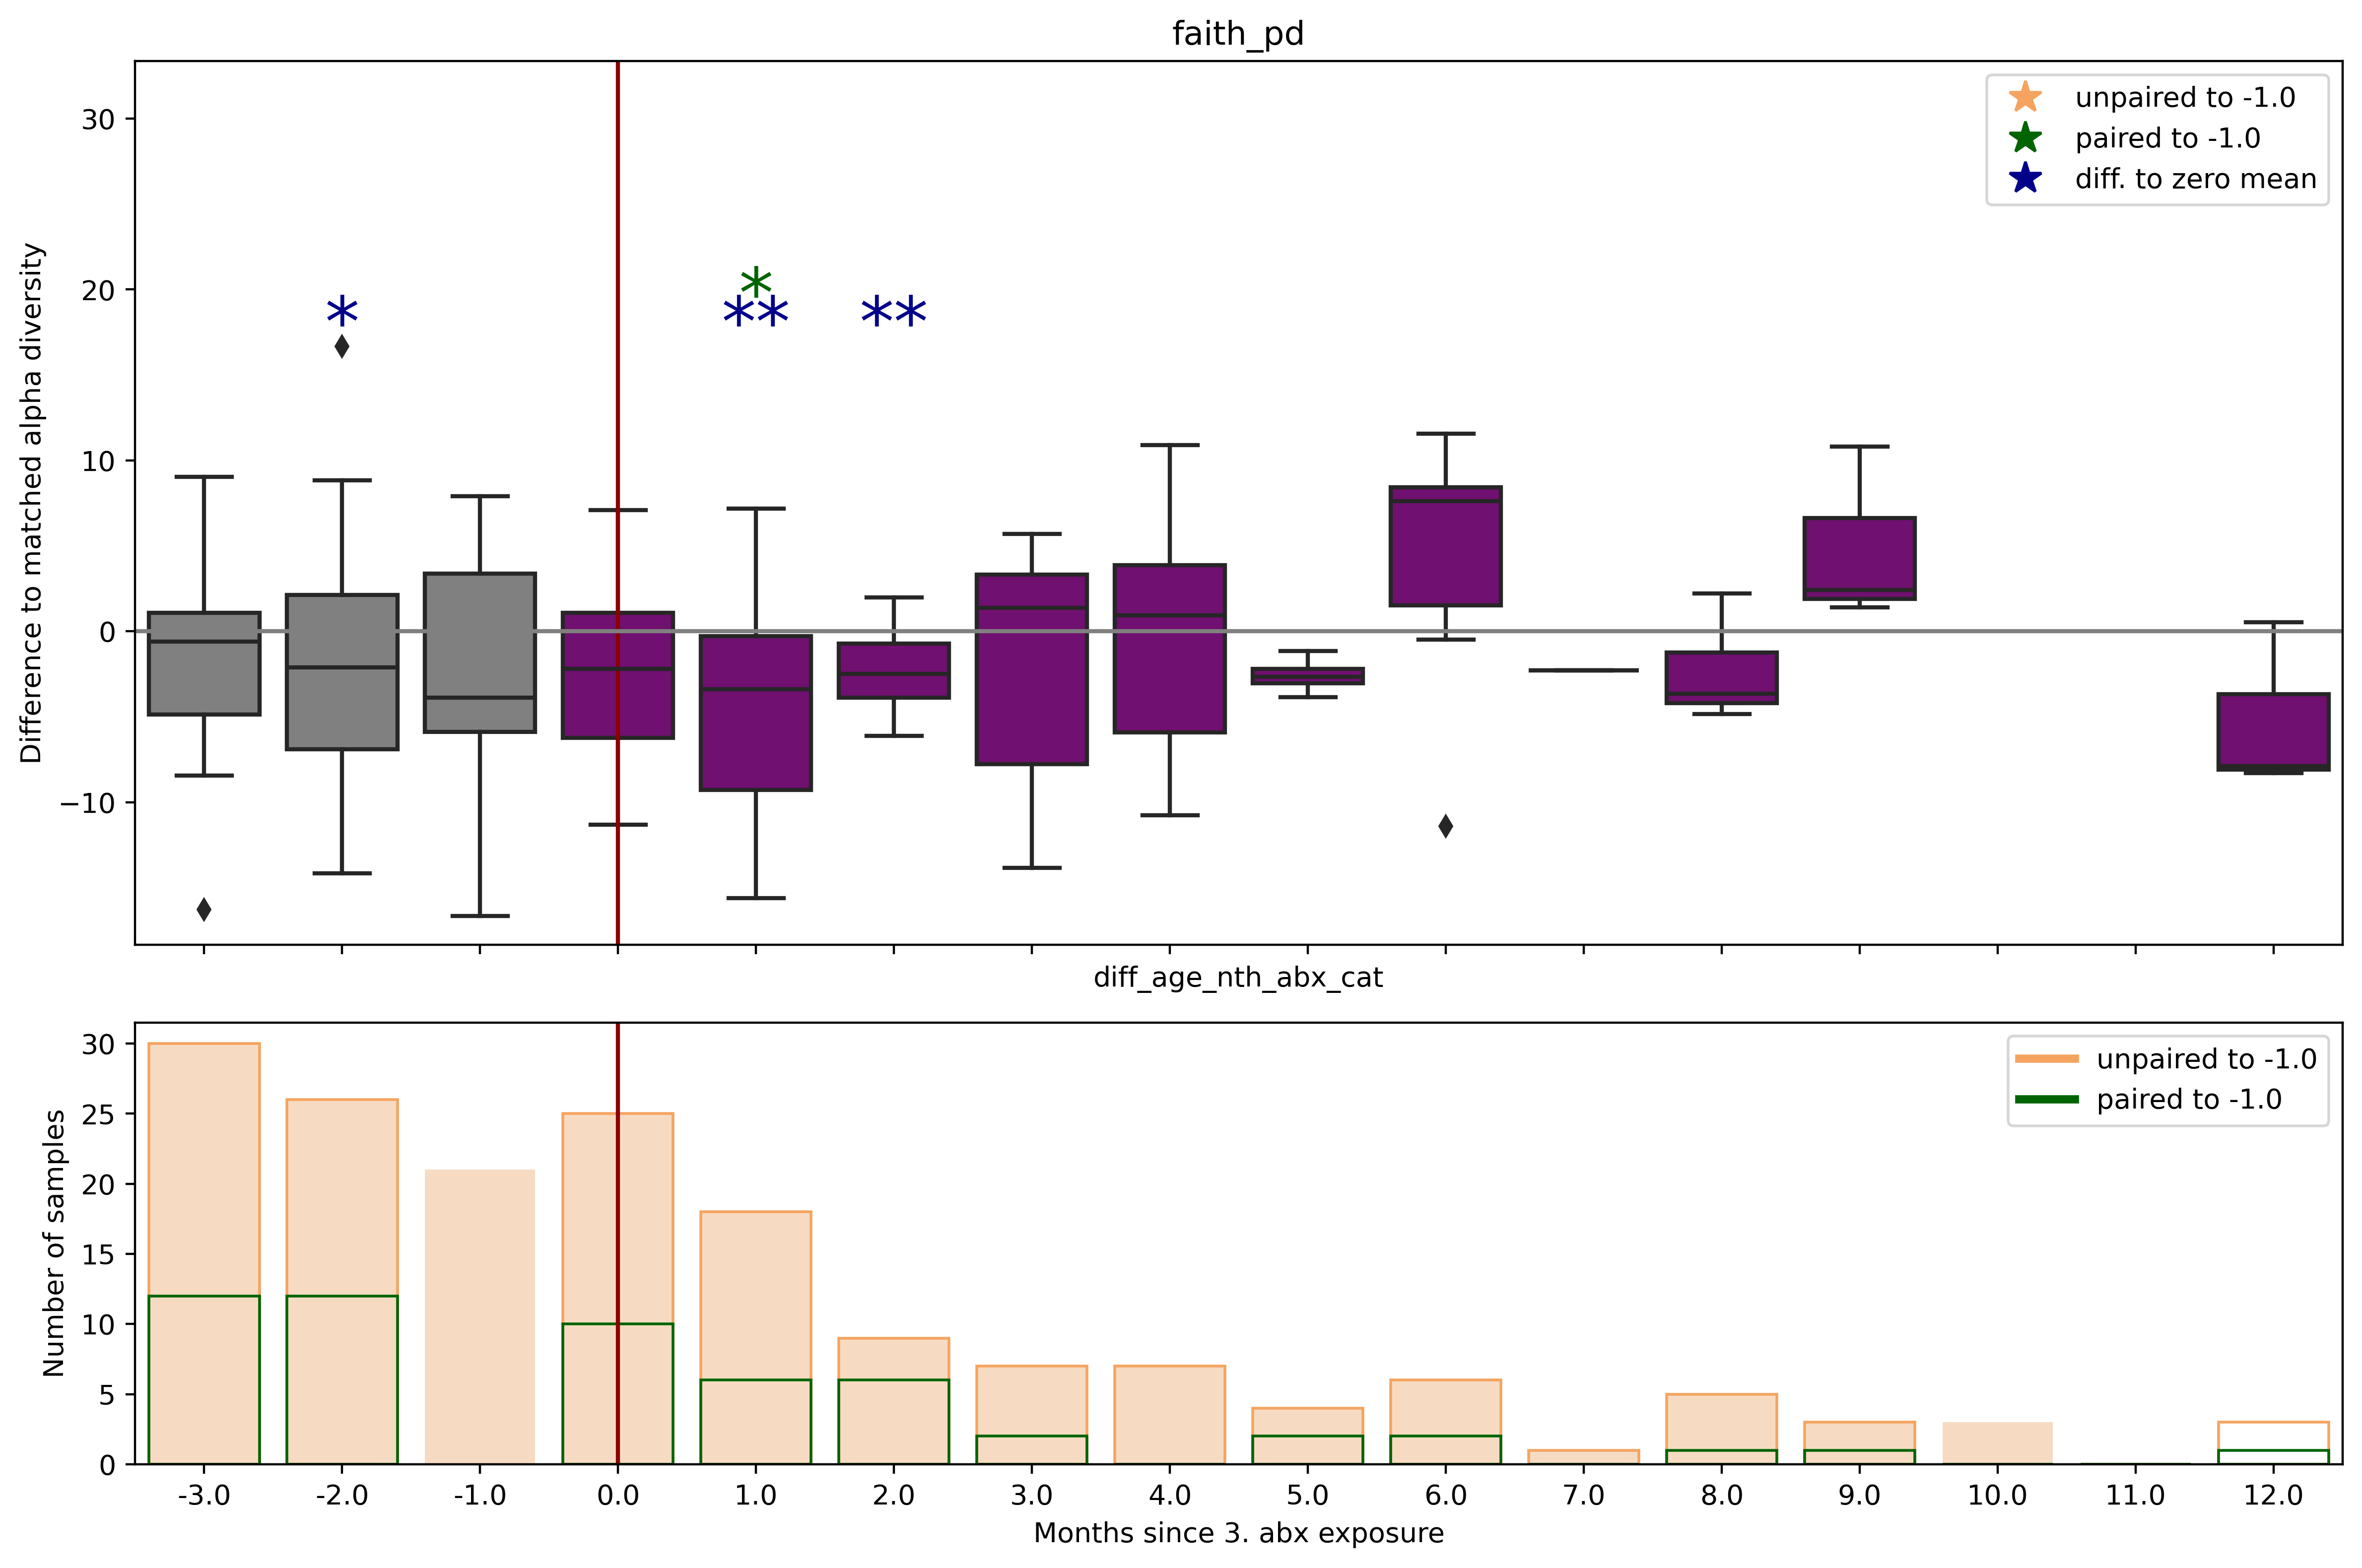

Number of samples disregarded because of lacking reference in noabx: 0


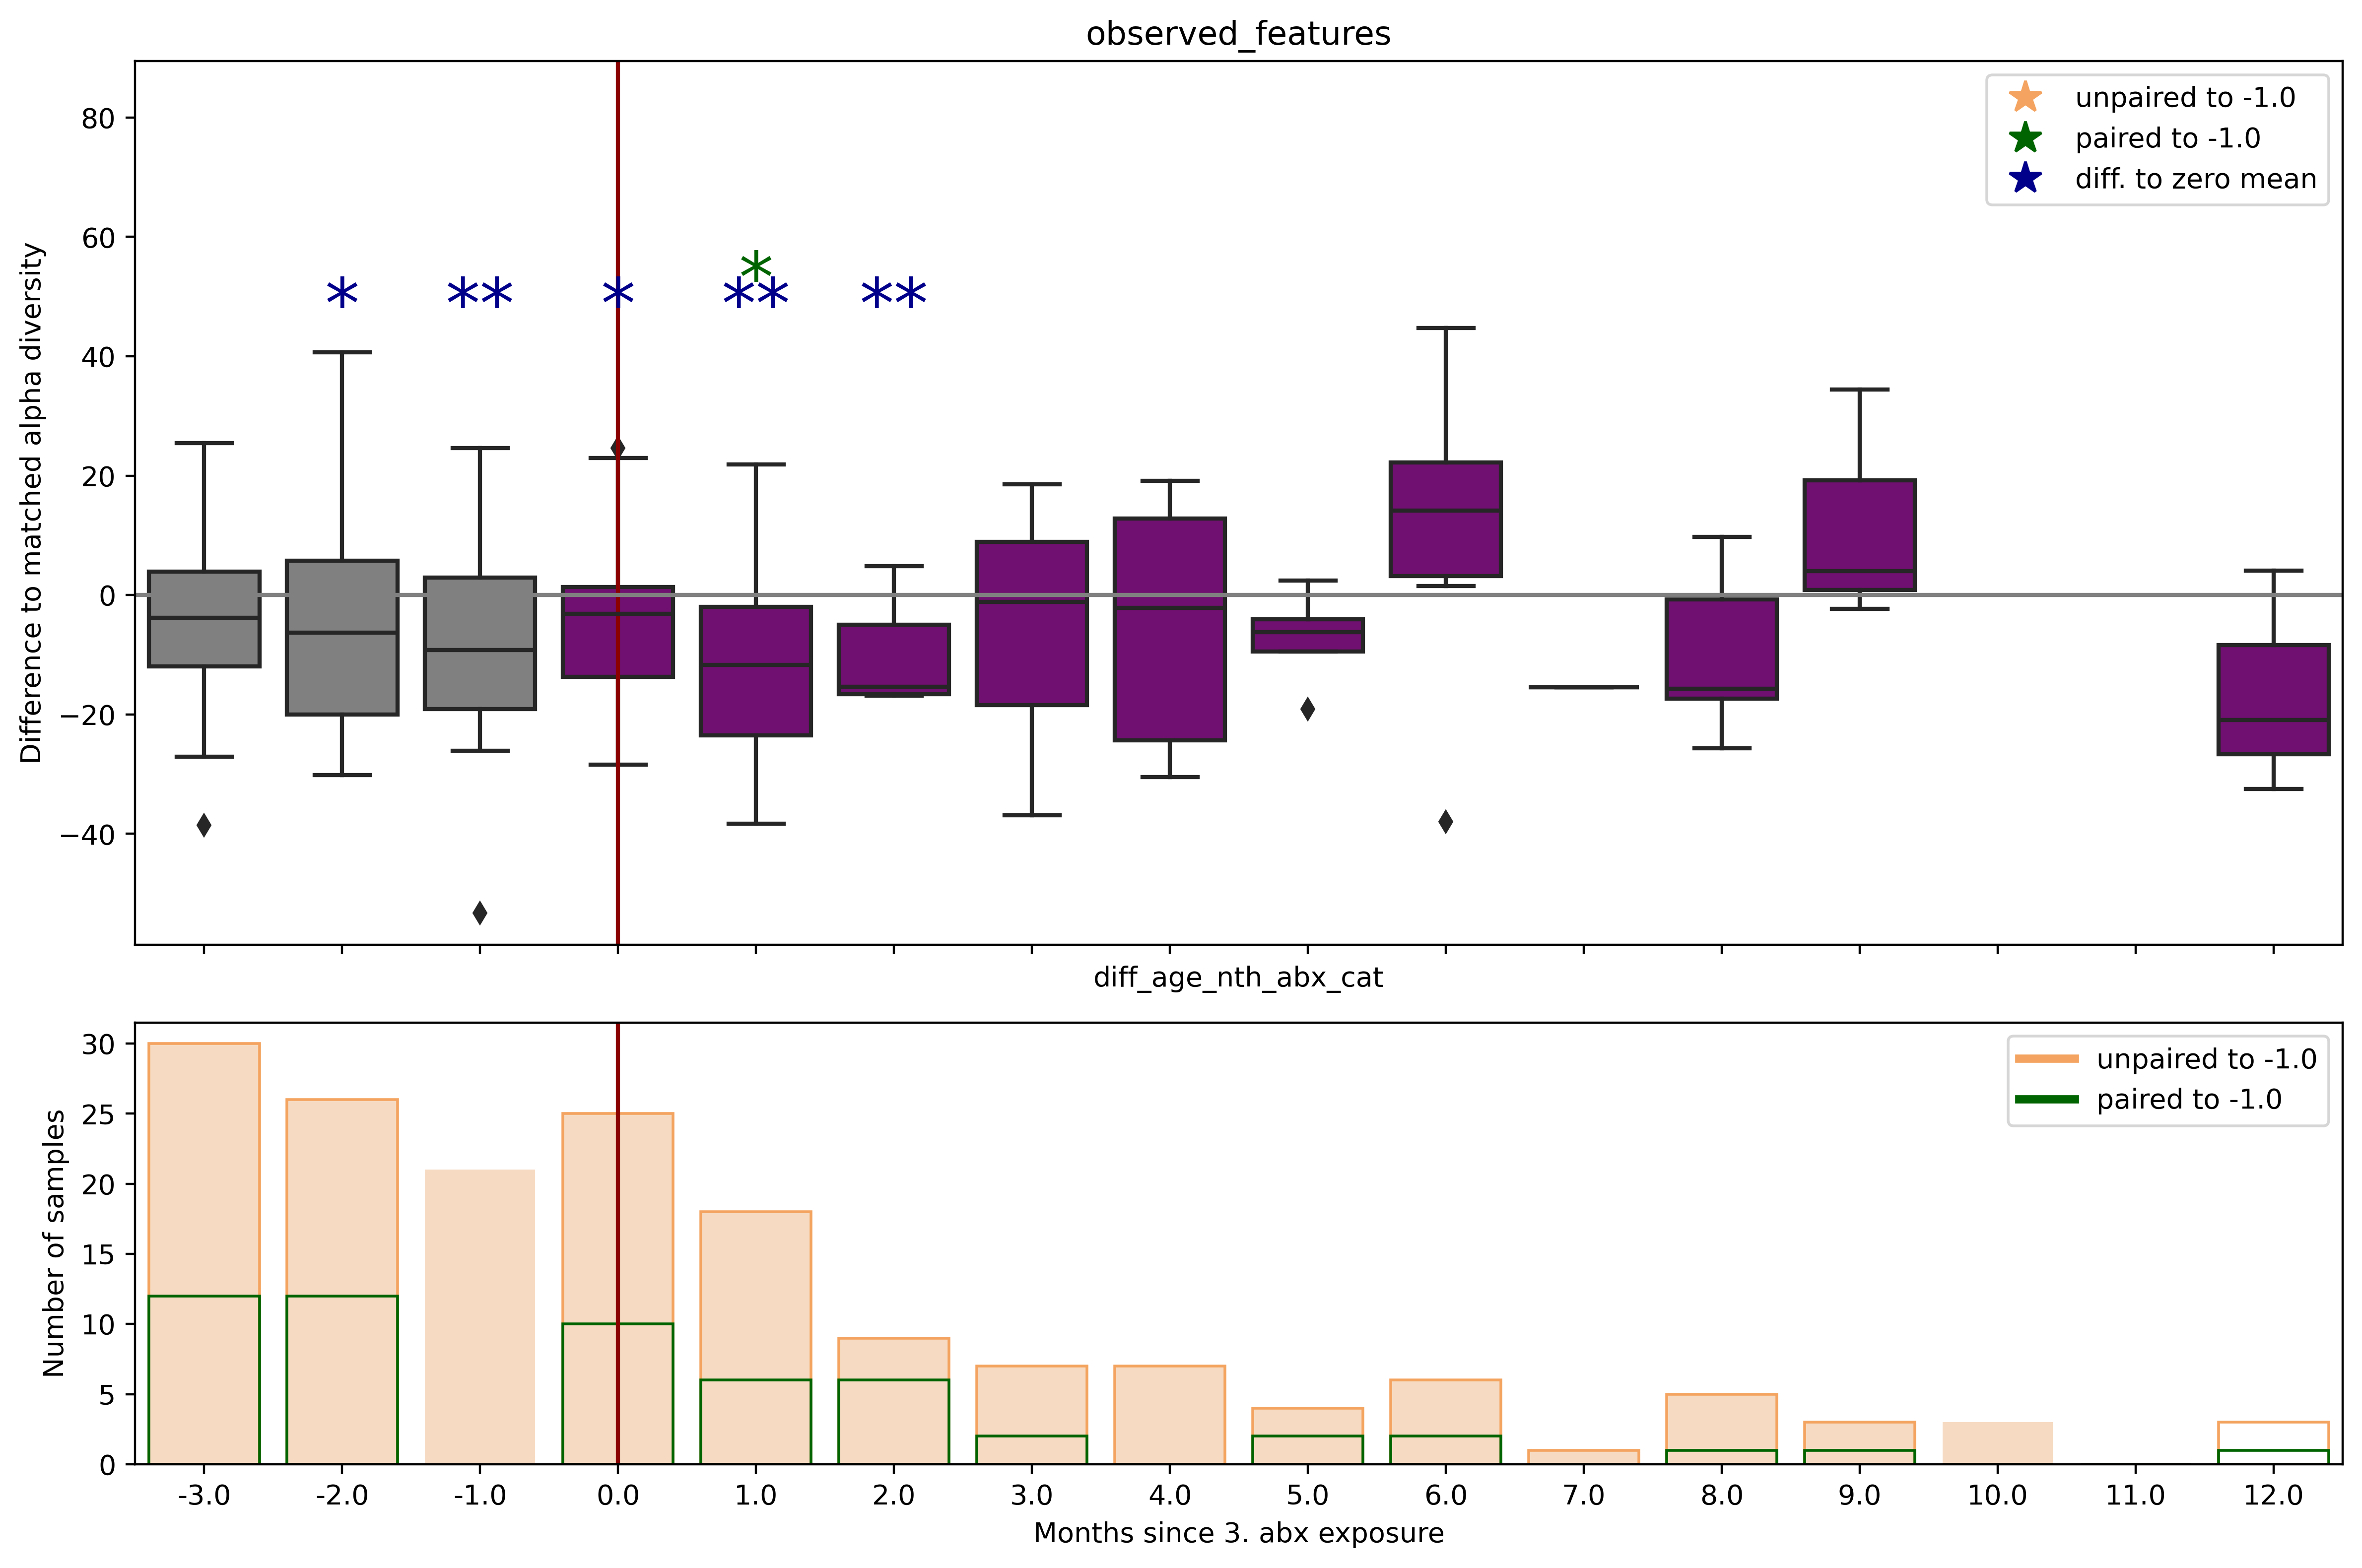

Number of samples disregarded because of lacking reference in noabx: 0


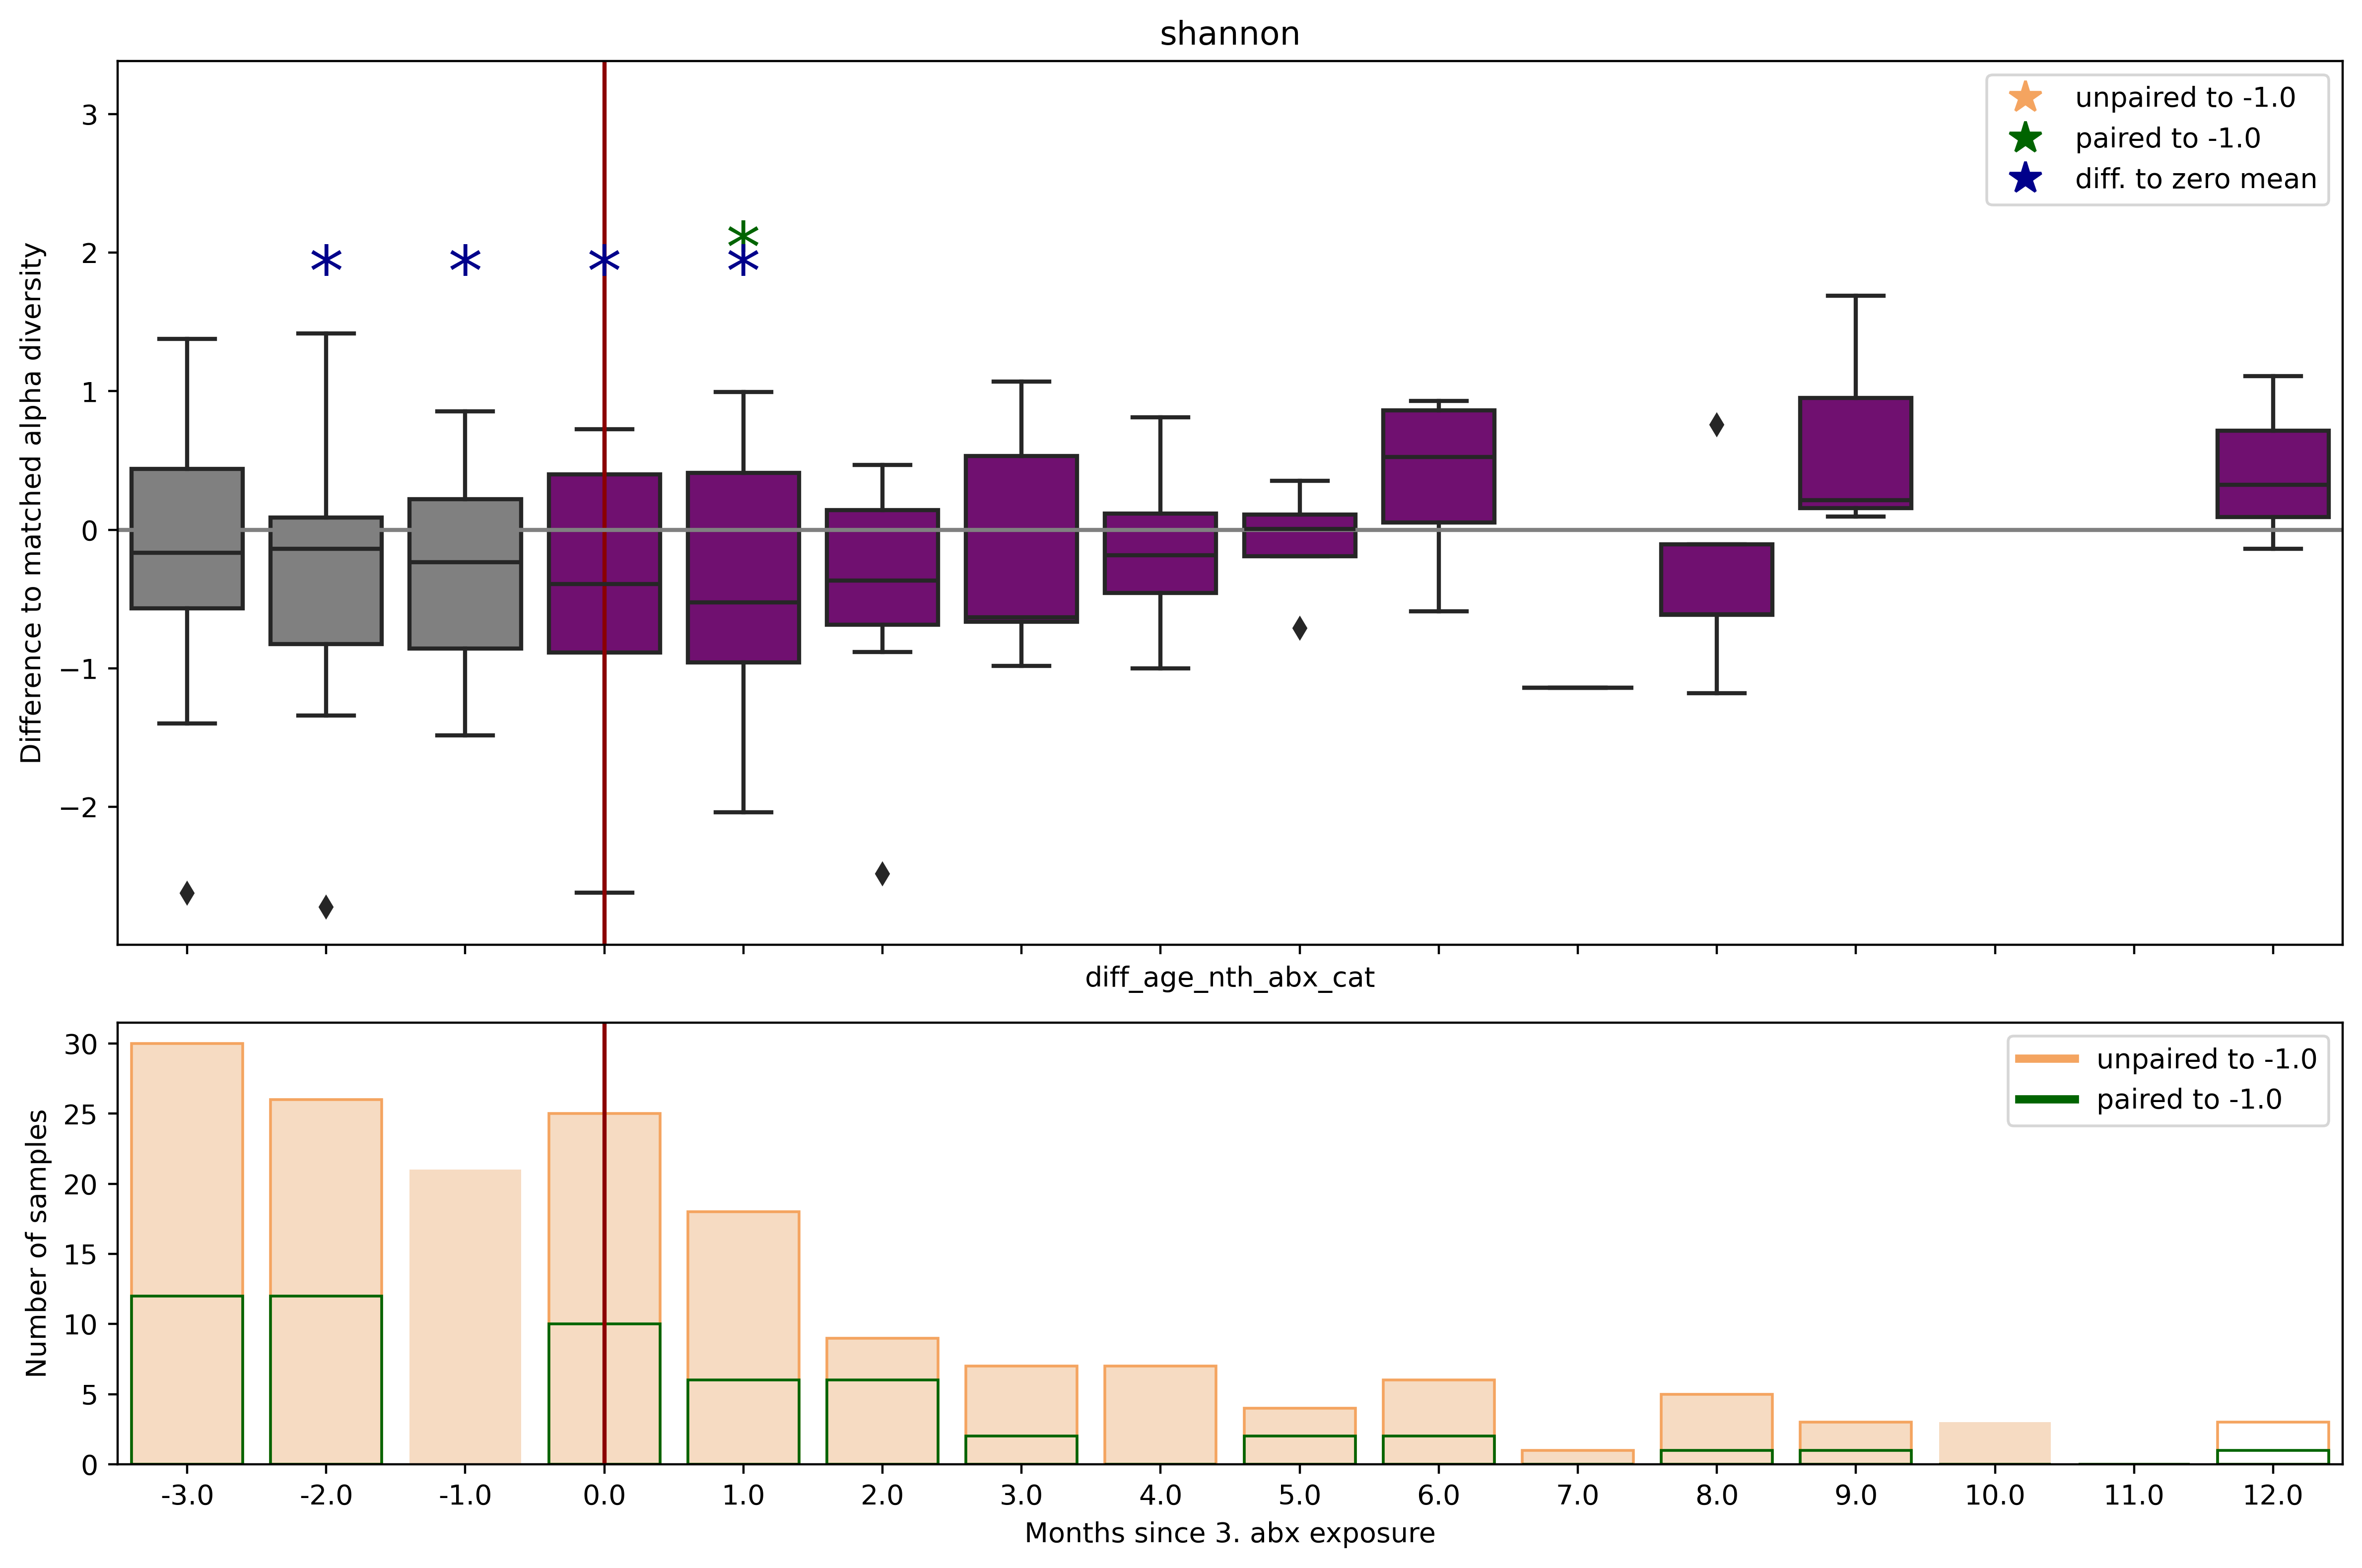

In [20]:
fig_3rd, dic_kw_3rd = calculate_nth_abx_effect_on_diversity(
    md_df,
    abx_df,
    3,
    path_to_output,
    cov_groups=matching_vars,
)

Conclusion:
* By plotting simply diversity after abx exposure across all age ranges and other covariates (milk + delivery mode) the effects of abx exposure are less distinct after matching by covariates.


* [Cross-sectional study by Li et al. 2023](https://www.nature.com/articles/s41467-023-44289-6) showed that abx exposure had an effect on infant gut microbiome only up to 1 month after exposure (beta-diversity, cross-sectional, no diet and delivery mode matching, no counts on abx exposure). We show above that alpha diversity of microbiome is significantly changed for about a month after 1st exposure and for up to 3 months after 2nd abx exposure. 

Recommendation from insights for modelling:
* Recommendation to use **Faith PD** as alpha metrics in modelling (since all alpha diversity metrics capture similar trends and this one also includes phylogenetic information).
* Recommendation to use **path dependent model**: This analysis aimed to see how long the antibiotics effect lasts on the microbiome, specifically the summary metric alpha diversity in our particular dataset (see figures below). The analysis shows that at least for the 1st and 2nd antibiotics exposure the anomaly effect lasts for more than one timepoint. So there seem to be non-Markovian dynamics in the anomaly.